In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/

# 他社債務(60か月)

## 参考
https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering

## モジュールとCSVの読み込み

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 315342110481537073
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12974221167558850465
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA RTX A2000 Laptop GPU


In [5]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')
bureau_balance_origin = pd.read_csv('./home-credit-default-risk/bureau_balance.csv')
app_br_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train_br_all-domein_60-monthes.csv')
app_br_test_origin = pd.read_csv('./home-credit-default-risk/exports/app_test_br_all-domein_60-monthes.csv')
#POS_CASH_balance_origin = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv')
#credit_card_balance_origin = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv')
#previous_application_origin = pd.read_csv('./home-credit-default-risk/previous_application.csv')
#installments_payments_origin = pd.read_csv('./home-credit-default-risk/installments_payments.csv')
# custo data
#app_br_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_Loan_From_other_banks_cash-consumer-loans.csv')
#app_br_test_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_Loan_From_other_banks_cash-consumer-loans.csv')
#app_train_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_overdue_hist.csv')
#app_test_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_overdue_hist.csv')
#app_train_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_debt_credit_ratio_none.csv')
#app_test_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_debt_credit_ratio_none.csv')

app_train_origin.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0  ...                 0                        0.0   
1  ...                 0                        0.0   
2  ...                 0                        0.0   
3  ...                 0                        NaN   
4  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 93 columns]

## applicationの欠損値を補完

In [7]:
# applicationの欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
app_train_origin_replace = pd.DataFrame(imputer.fit_transform(app_train_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace = pd.DataFrame(imputer.fit_transform(app_test_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_13  FLAG_DOCUMENT_16  \
0               0.0  ...               0.0               0.0   
1               0.0  ...               0.0               0.0   
2               0.0  ...               0.0               0.0   
3               0.0  ...               0.0               0.0   
4               0.0  ...               0.0               0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  \
0                   0.000000                    0.000000     0.036147   
1                   0.000000                    3.000000     0.077973   
2                   0.000000                    4.000000     0.105202   
3                   0.000000                    3.000000     0.031123   
4                   0.010242                    1.748333     0.051266   

   DAYS_EMPLOYED_PERCENT  credit_annuity_ratio  credit_goods_price_ratio  \
0               0.121044             19.775662                    1.2640   
1               0.247398             74.467617                    1.2376   
2               0.222477              1.934735                    1.0528   
3               0.133515              6.378867                    1.0000   
4               0.168021             15.997755                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 91 columns]

In [8]:
# 欠損値を補完した列を再結合
app_train_origin[replace_columns] = app_train_origin_replace[replace_columns]
app_test_origin[replace_columns] = app_test_origin_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [9]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

## OriginデータのCOPY

In [10]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
bureau_balance = bureau_balance_origin.copy()
app_br_train = app_br_train_origin.copy()
app_br_test = app_br_test_origin.copy()
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [11]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

## 共通メソッド定義

In [12]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 他金融機関での借り入れ情報(bureau)前処理

In [13]:
len(app_train)

307511

In [14]:
len(app_test)

48744

In [15]:
len(app_br_train)

91932

In [16]:
len(app_br_test)

42311

In [17]:
#app_train = app_train[['SK_ID_CURR','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_test = app_test[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_train = app_train[['SK_ID_CURR','TARGET']].copy()
#app_test = app_test[['SK_ID_CURR']].copy()
len(app_test)

48744

In [18]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

In [19]:
# trainへマージ
app_train = pd.merge(app_train, app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [20]:
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  br_min_amt_annuity  br_max_amt_annuity  \
0               0.0  ...                 0.0            9364.500   
1               0.0  ...                 0.0            4261.500   
2               0.0  ...                 NaN               0.000   
3               0.0  ...                 NaN            6562.485   
4               0.0  ...                 NaN                 NaN   

   br_sum_amt_annuity  br_avg_amt_annuity  br_cnt_amt_annuity  \
0          212634.000         1236.244186               172.0   
1           12784.500          608.785714                21.0   
2               0.000            0.000000               217.0   
3          443230.785          826.923106               536.0   
4                 NaN                 NaN                 NaN   

   br_stddev_amt_annuity  br_stddev_pop_amt_annuity  br_var_pop_amt_annuity  \
0            2794.728222                2794.728222            7.810506e+06   
1            1491.214363                1491.214363            2.223720e+06   
2               0.000000                   0.000000            0.000000e+00   
3            2284.010751                2284.010751            5.216705e+06   
4                    NaN                        NaN                     NaN   

   br_var_samp_amt_annuity  br_variance_pop_amt_annuity  
0             7.856181e+06                 7.810506e+06  
1             2.334906e+06                 2.223720e+06  
2             0.000000e+00                 0.000000e+00  
3             5.226456e+06                 5.216705e+06  
4                      NaN                          NaN  

[5 rows x 202 columns]

### br_min_credit_day_overdue

In [21]:
app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

TARGET  br_min_credit_day_overdue
TARGET                     1.000000                   0.009145
br_min_credit_day_overdue  0.009145                   1.000000

In [22]:
app_train['br_min_credit_day_overdue'].isnull().sum()

215579

In [23]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [24]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [25]:
# idをint型へ戻す
#app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
#app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
#app_train.head()

In [26]:
#app_test['br_min_credit_day_overdue'].isnull().sum()

In [27]:
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

In [28]:
#kde_target('br_min_credit_day_overdue', app_train)

In [29]:
## Yao-Johnson変換
#num_cols = ['br_min_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

In [30]:
## 標準化
#num_cols = ['br_min_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_credit_day_overdue', 'TARGET']].corr()

In [31]:
columns = ['br_min_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_credit_day_overdue

In [32]:
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.000000                   0.000438
br_max_credit_day_overdue  0.000438                   1.000000

In [33]:
app_train['br_max_credit_day_overdue'].isnull().sum()

215579

The correlation between br_max_credit_day_overdue and the TARGET is 0.0004
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


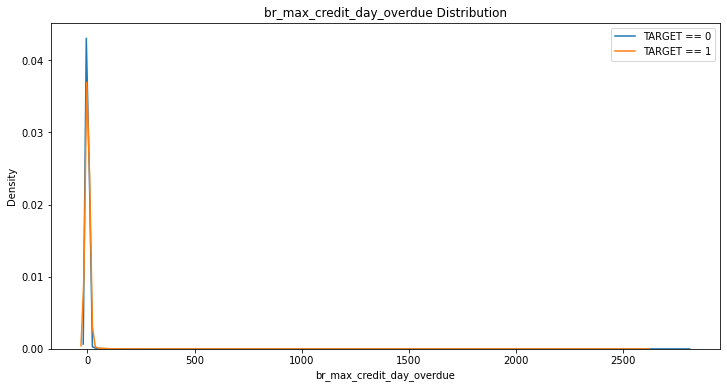

In [34]:
kde_target('br_max_credit_day_overdue', app_train)

In [35]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [36]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [37]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [38]:
#app_train['br_max_credit_day_overdue'].isnull().sum()

In [39]:
#app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

In [40]:
## Yao-Johnson変換
#num_cols = ['br_max_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_max_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [41]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

In [42]:
## 標準化
#num_cols = ['br_max_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_credit_day_overdue', 'TARGET']].corr()

In [43]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_credit_day_overdue', app_train)

In [44]:
columns = ['br_max_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_credit_day_overdue

In [45]:
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                  -0.002364
br_sum_credit_day_overdue -0.002364                   1.000000

In [46]:
app_train['br_sum_credit_day_overdue'].isnull().sum()

215579

The correlation between br_sum_credit_day_overdue and the TARGET is -0.0024
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


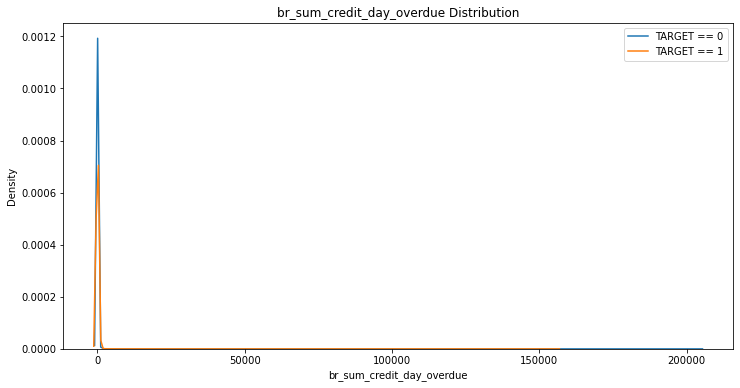

In [47]:
kde_target('br_sum_credit_day_overdue', app_train)

In [48]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_credit_day_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [49]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [50]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [51]:
#app_train['br_sum_credit_day_overdue'].isnull().sum()

In [52]:
#app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

In [53]:
## Yao-Johnson変換
#num_cols = ['br_sum_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

In [54]:
## 標準化
#num_cols = ['br_sum_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_credit_day_overdue', 'TARGET']].corr()

In [55]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_credit_day_overdue', app_train)

In [56]:
columns = ['br_sum_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_credit_day_overdue

In [57]:
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.000000                   0.003352
br_avg_credit_day_overdue  0.003352                   1.000000

In [58]:
app_train['br_avg_credit_day_overdue'].isnull().sum()

215579

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0034
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


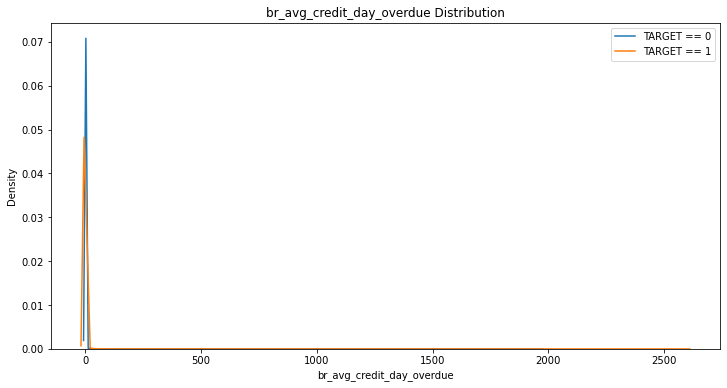

In [59]:
kde_target('br_avg_credit_day_overdue', app_train)

In [60]:
app_train['br_avg_credit_day_overdue'].isnull().sum()

215579

In [61]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_credit_day_overdue')
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [62]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [63]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [64]:
#app_train['br_avg_credit_day_overdue'].isnull().sum()

In [65]:
#app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

In [66]:
## Yao-Johnson変換
#num_cols = ['br_avg_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_avg_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [67]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

In [68]:
## 標準化
#num_cols = ['br_avg_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_credit_day_overdue', 'TARGET']].corr()

In [69]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_credit_day_overdue', app_train)

In [70]:
columns = ['br_avg_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_credit_day_overdue

In [71]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.040412
br_cnt_credit_day_overdue -0.040412                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


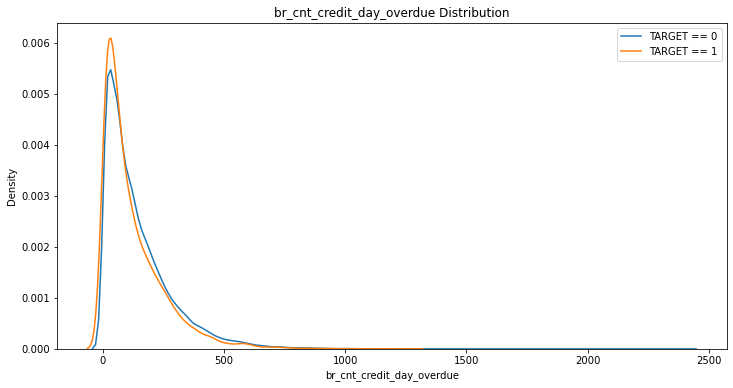

In [72]:
kde_target('br_cnt_credit_day_overdue', app_train)

In [73]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_credit_day_overdue  
0  52.715068                 172.000000  
1  49.490411                  21.000000  
2  54.898630                 217.000000  
3  38.290411                 536.000000  
4  35.726027                 192.700818  

[5 rows x 92 columns]

In [74]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [75]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [76]:
app_train['br_cnt_credit_day_overdue'].isnull().sum()

0

In [77]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.048315
br_cnt_credit_day_overdue -0.048315                   1.000000

In [78]:
## Yao-Johnson変換
num_cols = ['br_cnt_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.061147
br_cnt_credit_day_overdue -0.061147                   1.000000

In [79]:
## 標準化
num_cols = ['br_cnt_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_credit_day_overdue', 'TARGET']].corr()

br_cnt_credit_day_overdue    TARGET
br_cnt_credit_day_overdue                   1.000000 -0.061147
TARGET                                     -0.061147  1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


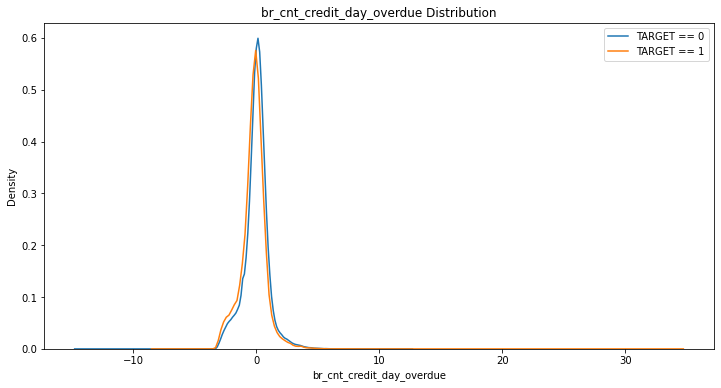

In [80]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_credit_day_overdue', app_train)

### br_stddev_credit_day_overdue

In [81]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.00000                      -0.00256
br_stddev_credit_day_overdue -0.00256                       1.00000

In [82]:
app_train['br_stddev_credit_day_overdue'].isnull().sum()

215579

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0026
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


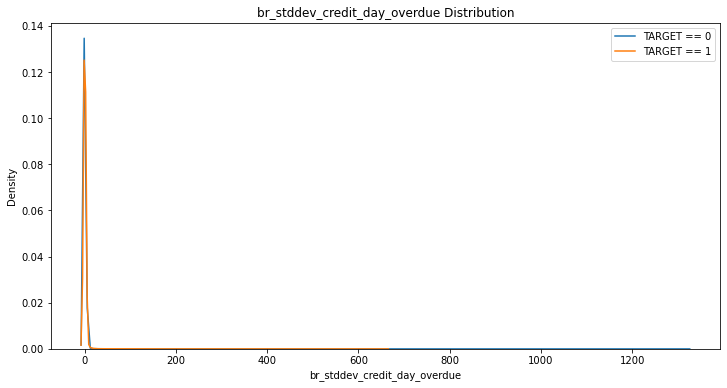

In [83]:
kde_target('br_stddev_credit_day_overdue', app_train)

In [84]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_credit_day_overdue  
0  52.715068                      0.000000  
1  49.490411                      0.000000  
2  54.898630                      0.000000  
3  38.290411                      0.000000  
4  35.726027                      0.717279  

[5 rows x 92 columns]

In [85]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [86]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [87]:
app_train['br_stddev_credit_day_overdue'].isnull().sum()

0

In [88]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                     -0.003967
br_stddev_credit_day_overdue -0.003967                      1.000000

In [89]:
## Yao-Johnson変換
num_cols = ['br_stddev_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                     -0.012694
br_stddev_credit_day_overdue -0.012694                      1.000000

In [90]:
## 標準化
num_cols = ['br_stddev_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_credit_day_overdue', 'TARGET']].corr()

br_stddev_credit_day_overdue    TARGET
br_stddev_credit_day_overdue                      1.000000 -0.012694
TARGET                                           -0.012694  1.000000

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0127
Median value for loan that was not repaid = -0.0550
Median value for loan that was repaid =     -0.0044


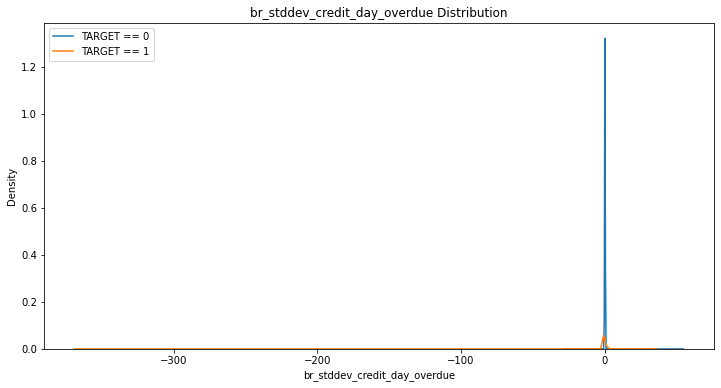

In [91]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_credit_day_overdue', app_train)

### br_stddev_pop_credit_day_overdue

In [92]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.00000                          -0.00256
br_stddev_pop_credit_day_overdue -0.00256                           1.00000

In [93]:
app_train['br_stddev_pop_credit_day_overdue'].isnull().sum()

215579

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0026
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


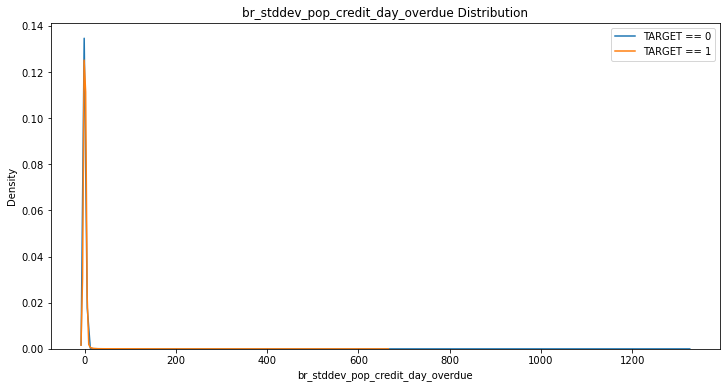

In [94]:
kde_target('br_stddev_pop_credit_day_overdue', app_train)

In [95]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_credit_day_overdue  
0  52.715068                          0.000000  
1  49.490411                          0.000000  
2  54.898630                          0.000000  
3  38.290411                          0.000000  
4  35.726027                          0.717279  

[5 rows x 92 columns]

In [96]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [97]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [98]:
app_train['br_stddev_pop_credit_day_overdue'].isnull().sum()

0

In [99]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                         -0.003967
br_stddev_pop_credit_day_overdue -0.003967                          1.000000

In [100]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                         -0.012694
br_stddev_pop_credit_day_overdue -0.012694                          1.000000

In [101]:
## 標準化
num_cols = ['br_stddev_pop_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0127
Median value for loan that was not repaid = -0.0550
Median value for loan that was repaid =     -0.0044


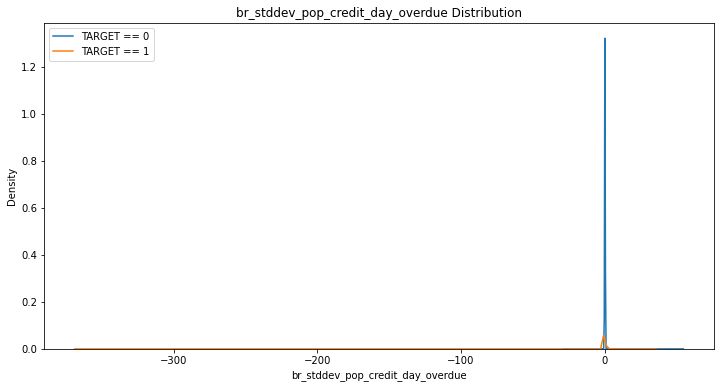

In [102]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_credit_day_overdue', app_train)

### br_var_pop_credit_day_overdue

In [103]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                      -0.004867
br_var_pop_credit_day_overdue -0.004867                       1.000000

In [104]:
app_train['br_var_pop_credit_day_overdue'].isnull().sum()

215579

The correlation between br_var_pop_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


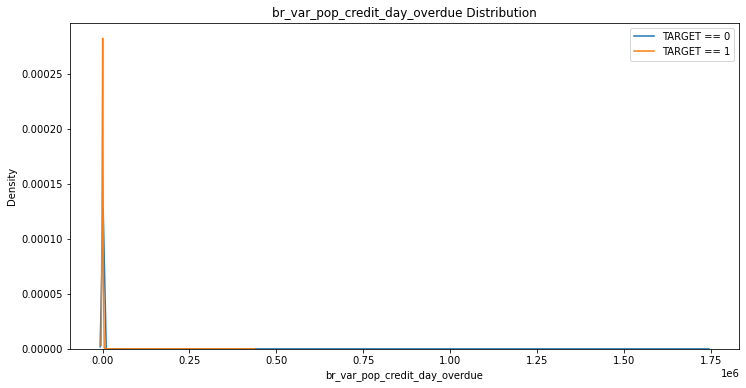

In [105]:
kde_target('br_var_pop_credit_day_overdue', app_train)

In [106]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [107]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [108]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [109]:
app_train['br_var_pop_credit_day_overdue'].isnull().sum()

215579

In [110]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                      -0.004867
br_var_pop_credit_day_overdue -0.004867                       1.000000

In [111]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [112]:
## 標準化
#num_cols = ['br_var_pop_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_credit_day_overdue', 'TARGET']].corr()

In [113]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_credit_day_overdue', app_train)

In [114]:
columns = ['br_var_pop_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_credit_day_overdue

In [115]:
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                       -0.004863
br_var_samp_credit_day_overdue -0.004863                        1.000000

In [116]:
app_train['br_var_samp_credit_day_overdue'].isnull().sum()

215579

The correlation between br_var_samp_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


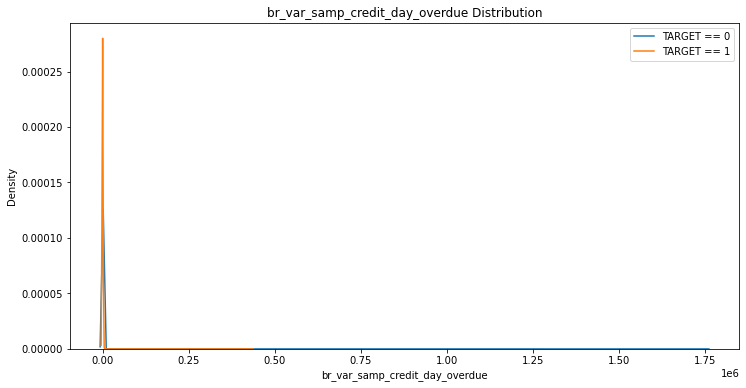

In [117]:
kde_target('br_var_samp_credit_day_overdue', app_train)

In [118]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [119]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [120]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [121]:
#app_train['br_var_samp_credit_day_overdue'].isnull().sum()

In [122]:
#app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

In [123]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [124]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

In [125]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_credit_day_overdue', app_train)

In [126]:
columns = ['br_var_samp_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_credit_day_overdue

In [127]:
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue -0.004867   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                       -0.004867  
br_variance_pop_credit_day_overdue                            1.000000

In [128]:
app_train['br_variance_pop_credit_day_overdue'].isnull().sum()

215579

The correlation between br_variance_pop_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


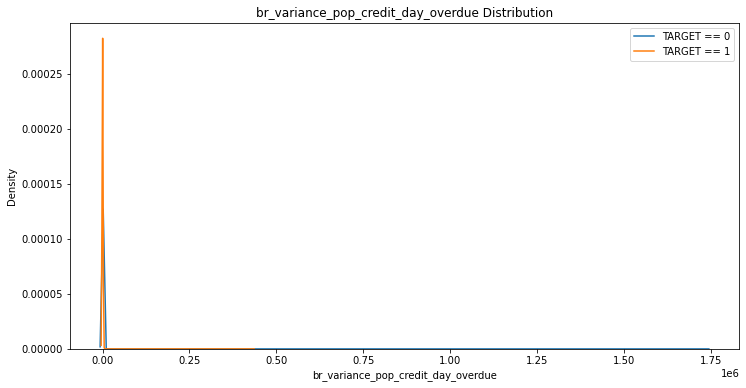

In [129]:
kde_target('br_variance_pop_credit_day_overdue', app_train)

In [130]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [131]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [132]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [133]:
#app_train['br_variance_pop_credit_day_overdue'].isnull().sum()

In [134]:
#app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

In [135]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [136]:
## 標準化
#num_cols = ['br_variance_pop_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_credit_day_overdue', 'TARGET']].corr()

In [137]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_credit_day_overdue', app_train)

In [138]:
columns = ['br_variance_pop_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_days_credit_enddate

In [139]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.037033
br_min_days_credit_enddate  0.037033                    1.000000

In [140]:
app_train['br_min_days_credit_enddate'].isnull().sum()

215579

The correlation between br_min_days_credit_enddate and the TARGET is 0.0370
Median value for loan that was not repaid = -843.0000
Median value for loan that was repaid =     -1117.0000


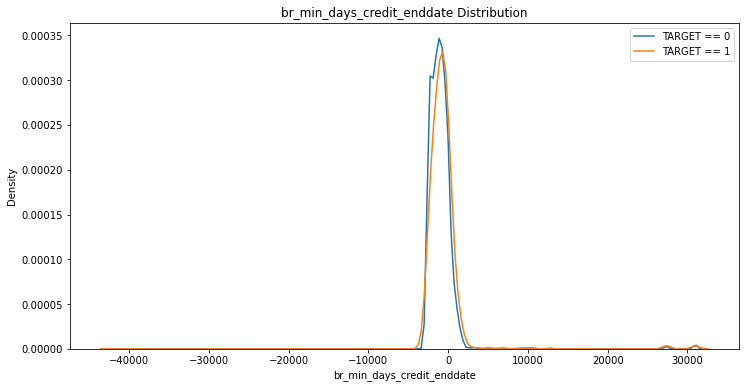

In [141]:
kde_target('br_min_days_credit_enddate', app_train)

In [142]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_credit_enddate')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_days_credit_enddate  
0  52.715068                -1329.000000  
1  49.490411                 -128.000000  
2  54.898630                -1707.000000  
3  38.290411                -1862.000000  
4  35.726027                -1023.565976  

[5 rows x 92 columns]

In [143]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [144]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [145]:
app_train['br_min_days_credit_enddate'].isnull().sum()

0

In [146]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.040183
br_min_days_credit_enddate  0.040183                    1.000000

In [147]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [148]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.065153
br_min_days_credit_enddate  0.065153                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0652
Median value for loan that was not repaid = 0.3099
Median value for loan that was repaid =     0.0384


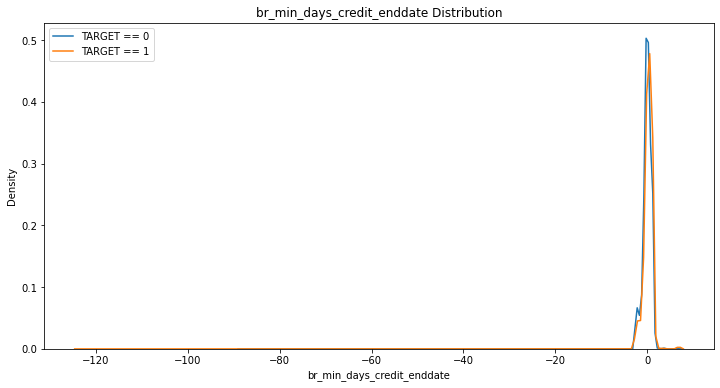

In [149]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_enddate', app_train)

### br_max_days_credit_enddate

In [150]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.036183
br_max_days_credit_enddate  0.036183                    1.000000

In [151]:
app_train['br_max_days_credit_enddate'].isnull().sum()

215579

The correlation between br_max_days_credit_enddate and the TARGET is 0.0362
Median value for loan that was not repaid = 1114.0000
Median value for loan that was repaid =     924.0000


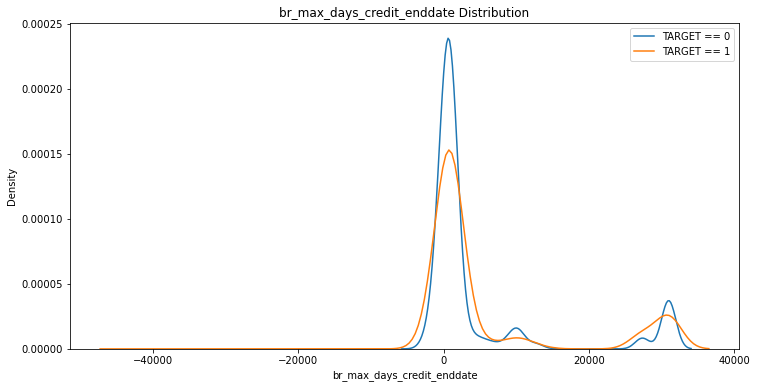

In [152]:
kde_target('br_max_days_credit_enddate', app_train)

In [153]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_credit_enddate')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_days_credit_enddate  
0  52.715068                 1778.000000  
1  49.490411                 1324.000000  
2  54.898630                 -567.000000  
3  38.290411                30885.000000  
4  35.726027                 5406.274462  

[5 rows x 92 columns]

In [154]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [155]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [156]:
app_train['br_max_days_credit_enddate'].isnull().sum()

0

In [157]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.026057
br_max_days_credit_enddate  0.026057                    1.000000

In [158]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.026247
br_max_days_credit_enddate  0.026247                    1.000000

In [159]:
## 標準化
num_cols = ['br_max_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_credit_enddate', 'TARGET']].corr()

br_max_days_credit_enddate    TARGET
br_max_days_credit_enddate                    1.000000  0.026247
TARGET                                        0.026247  1.000000

The correlation between br_max_days_credit_enddate and the TARGET is 0.0262
Median value for loan that was not repaid = 0.0882
Median value for loan that was repaid =     0.0422


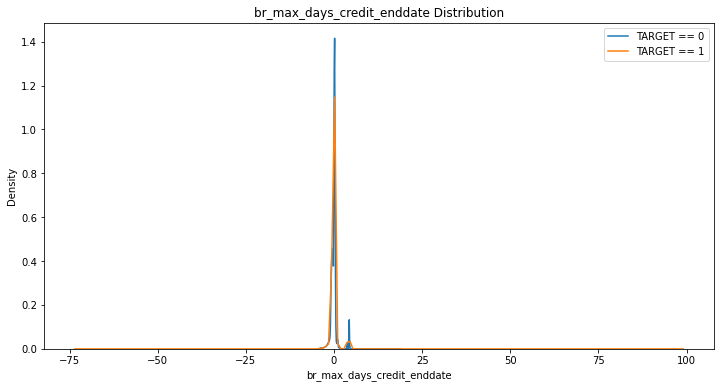

In [160]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_enddate', app_train)

The correlation between br_max_days_credit_enddate and the TARGET is 0.0262
Median value for loan that was not repaid = 0.0882
Median value for loan that was repaid =     0.0422


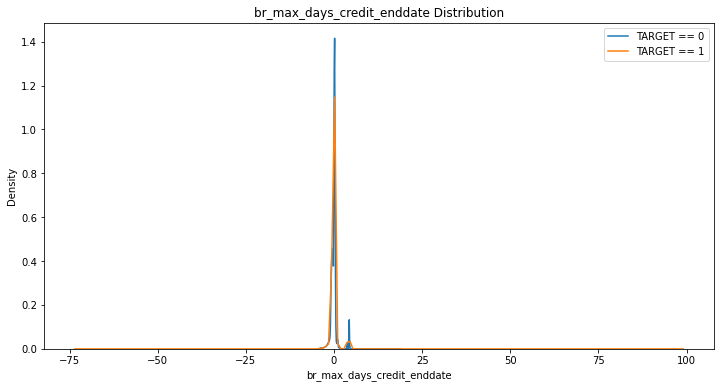

In [161]:
kde_target('br_max_days_credit_enddate', app_train)

### br_sum_days_credit_enddate

In [162]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.024731
br_sum_days_credit_enddate  0.024731                    1.000000

In [163]:
app_train['br_sum_days_credit_enddate'].isnull().sum()

215579

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0247
Median value for loan that was not repaid = 11.0000
Median value for loan that was repaid =     -12434.0000


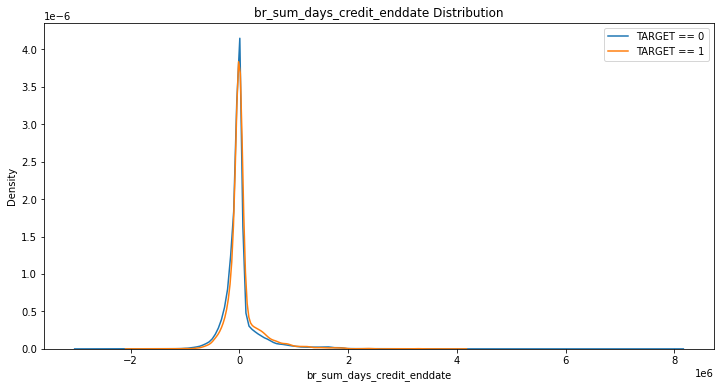

In [164]:
kde_target('br_sum_days_credit_enddate', app_train)

In [165]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_days_credit_enddate  
0  52.715068               -7.843700e+04  
1  49.490411                5.322000e+03  
2  54.898630               -2.343210e+05  
3  38.290411                1.382079e+06  
4  35.726027                2.547419e+04  

[5 rows x 92 columns]

In [166]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [167]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [168]:
app_train['br_sum_days_credit_enddate'].isnull().sum()

0

In [169]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.021651
br_sum_days_credit_enddate  0.021651                    1.000000

In [170]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.027587
br_sum_days_credit_enddate  0.027587                    1.000000

In [171]:
## 標準化
num_cols = ['br_sum_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_credit_enddate', 'TARGET']].corr()

br_sum_days_credit_enddate    TARGET
br_sum_days_credit_enddate                    1.000000  0.027587
TARGET                                        0.027587  1.000000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0276
Median value for loan that was not repaid = 0.1102
Median value for loan that was repaid =     0.0703


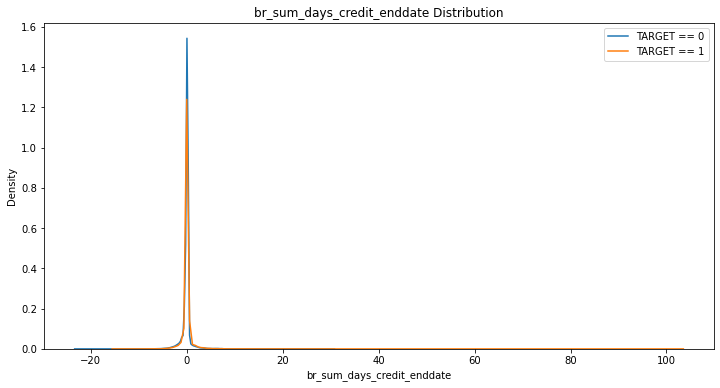

In [172]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_enddate', app_train)

### br_avg_days_credit_enddate

In [173]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.043261
br_avg_days_credit_enddate  0.043261                    1.000000

In [174]:
app_train['br_avg_days_credit_enddate'].isnull().sum()

215579

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0433
Median value for loan that was not repaid = 2.1707
Median value for loan that was repaid =     -224.0000


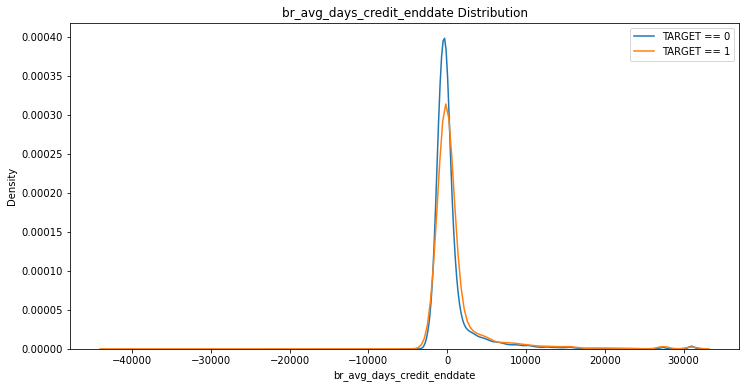

In [175]:
kde_target('br_avg_days_credit_enddate', app_train)

In [176]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_days_credit_enddate  
0  52.715068                 -456.029100  
1  49.490411                  253.428600  
2  54.898630                -1079.820300  
3  38.290411                 2820.569400  
4  35.726027                  474.699933  

[5 rows x 92 columns]

In [177]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [178]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [179]:
app_train['br_avg_days_credit_enddate'].isnull().sum()

0

In [180]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.040887
br_avg_days_credit_enddate  0.040887                    1.000000

In [181]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.046157
br_avg_days_credit_enddate  0.046157                    1.000000

In [182]:
## 標準化
num_cols = ['br_avg_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_credit_enddate', 'TARGET']].corr()

br_avg_days_credit_enddate    TARGET
br_avg_days_credit_enddate                    1.000000  0.046157
TARGET                                        0.046157  1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0462
Median value for loan that was not repaid = 0.1924
Median value for loan that was repaid =     0.0968


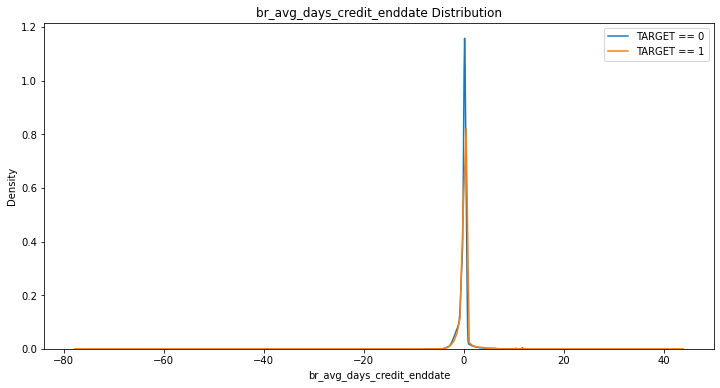

In [183]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_enddate', app_train)

### br_cnt_days_credit_enddate

In [184]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.043187
br_cnt_days_credit_enddate -0.043187                    1.000000

In [185]:
app_train['br_cnt_days_credit_enddate'].isnull().sum()

215579

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0432
Median value for loan that was not repaid = 74.0000
Median value for loan that was repaid =     96.0000


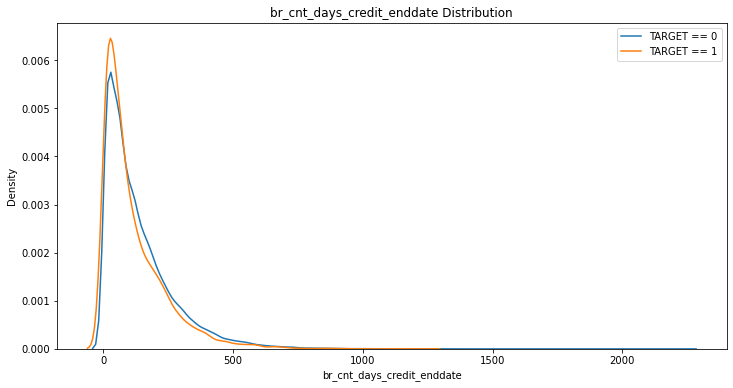

In [186]:
kde_target('br_cnt_days_credit_enddate', app_train)

In [187]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_days_credit_enddate  
0  52.715068                  172.000000  
1  49.490411                   21.000000  
2  54.898630                  217.000000  
3  38.290411                  490.000000  
4  35.726027                  183.608154  

[5 rows x 92 columns]

In [188]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [189]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [190]:
app_train['br_cnt_days_credit_enddate'].isnull().sum()

0

In [191]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.051836
br_cnt_days_credit_enddate -0.051836                    1.000000

In [192]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.065311
br_cnt_days_credit_enddate -0.065311                    1.000000

In [193]:
## 標準化
num_cols = ['br_cnt_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_credit_enddate', 'TARGET']].corr()

br_cnt_days_credit_enddate    TARGET
br_cnt_days_credit_enddate                    1.000000 -0.065311
TARGET                                       -0.065311  1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0653
Median value for loan that was not repaid = -0.1416
Median value for loan that was repaid =     0.0786


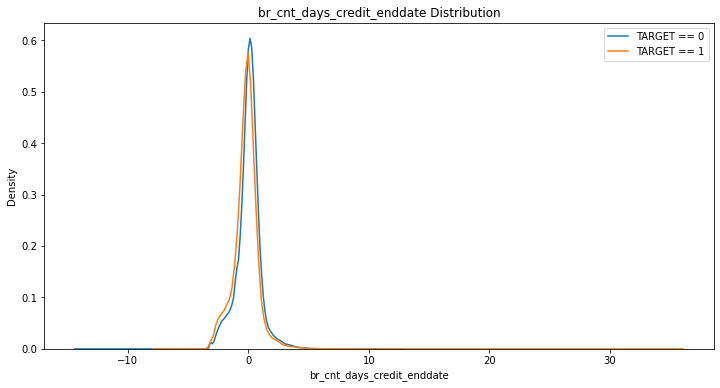

In [194]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_enddate', app_train)

### br_stddev_days_credit_enddate

In [195]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

TARGET  br_stddev_days_credit_enddate
TARGET                         1.000000                       0.025279
br_stddev_days_credit_enddate  0.025279                       1.000000

In [196]:
app_train['br_stddev_days_credit_enddate'].isnull().sum()

215579

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0253
Median value for loan that was not repaid = 667.5509
Median value for loan that was repaid =     672.7729


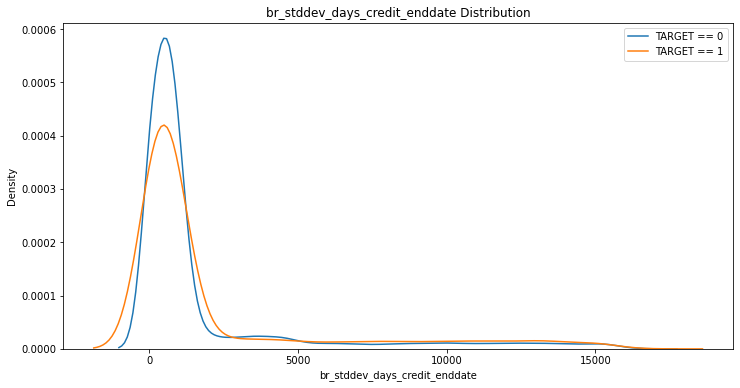

In [197]:
kde_target('br_stddev_days_credit_enddate', app_train)

In [198]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_days_credit_enddate  
0  52.715068                     744.580906  
1  49.490411                     604.498105  
2  54.898630                     430.636106  
3  38.290411                   10509.599376  
4  35.726027                    2070.611367  

[5 rows x 92 columns]

In [199]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [200]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [201]:
app_train['br_stddev_days_credit_enddate'].isnull().sum()

0

In [202]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

TARGET  br_stddev_days_credit_enddate
TARGET                         1.000000                       0.033268
br_stddev_days_credit_enddate  0.033268                       1.000000

In [203]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

In [204]:
## 標準化
num_cols = ['br_stddev_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_credit_enddate', 'TARGET']].corr()

br_stddev_days_credit_enddate    TARGET
br_stddev_days_credit_enddate                       1.000000  0.033268
TARGET                                              0.033268  1.000000

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0333
Median value for loan that was not repaid = -0.0245
Median value for loan that was repaid =     -0.1320


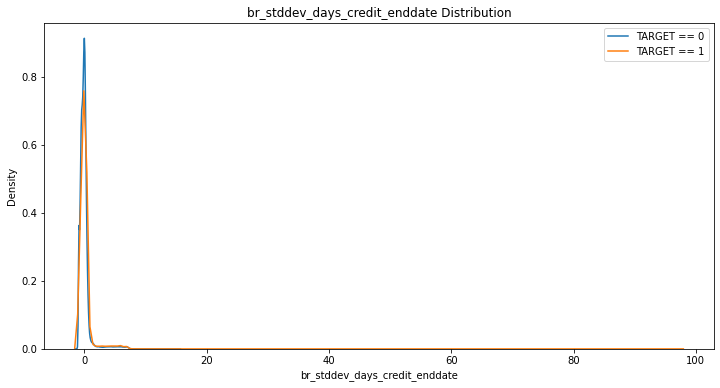

In [205]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_enddate', app_train)

### br_stddev_pop_days_credit_enddate

In [206]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

TARGET  br_stddev_pop_days_credit_enddate
TARGET                             1.000000                           0.025279
br_stddev_pop_days_credit_enddate  0.025279                           1.000000

In [207]:
app_train['br_stddev_pop_days_credit_enddate'].isnull().sum()

215579

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0253
Median value for loan that was not repaid = 667.5509
Median value for loan that was repaid =     672.7729


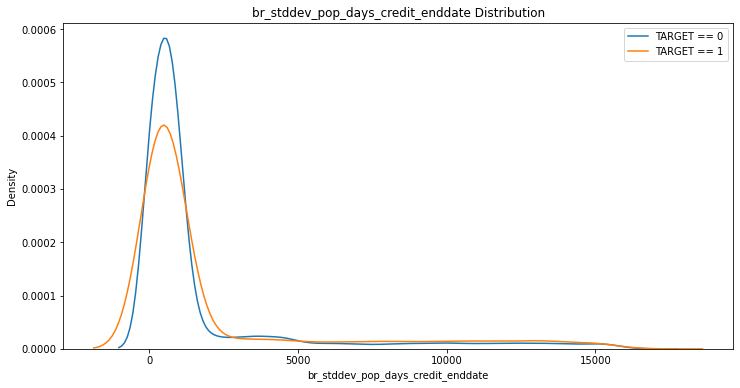

In [208]:
kde_target('br_stddev_pop_days_credit_enddate', app_train)

In [209]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_days_credit_enddate  
0  52.715068                         744.580906  
1  49.490411                         604.498105  
2  54.898630                         430.636106  
3  38.290411                       10509.599376  
4  35.726027                        2070.611367  

[5 rows x 92 columns]

In [210]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [211]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [212]:
app_train['br_stddev_pop_days_credit_enddate'].isnull().sum()

0

In [213]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

TARGET  br_stddev_pop_days_credit_enddate
TARGET                             1.000000                           0.033268
br_stddev_pop_days_credit_enddate  0.033268                           1.000000

In [214]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

In [215]:
## 標準化
num_cols = ['br_stddev_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_credit_enddate', 'TARGET']].corr()

br_stddev_pop_days_credit_enddate    TARGET
br_stddev_pop_days_credit_enddate                           1.000000  0.033268
TARGET                                                      0.033268  1.000000

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0333
Median value for loan that was not repaid = -0.0245
Median value for loan that was repaid =     -0.1320


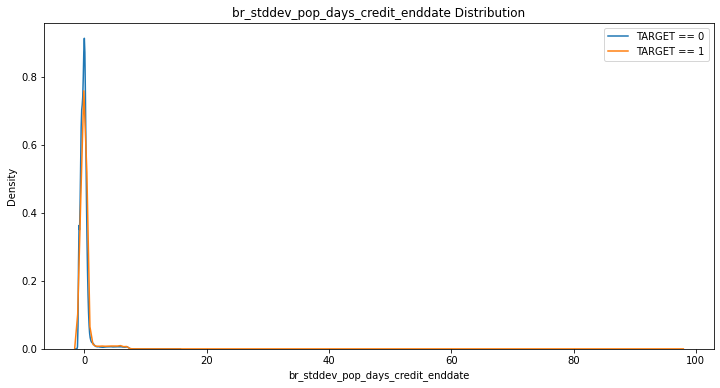

In [216]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_enddate', app_train)

### br_var_pop_days_credit_enddate

In [217]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.025917
br_var_pop_days_credit_enddate  0.025917                        1.000000

In [218]:
app_train['br_var_pop_days_credit_enddate'].isnull().sum()

215579

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0259
Median value for loan that was not repaid = 445624.1613
Median value for loan that was repaid =     452623.4119


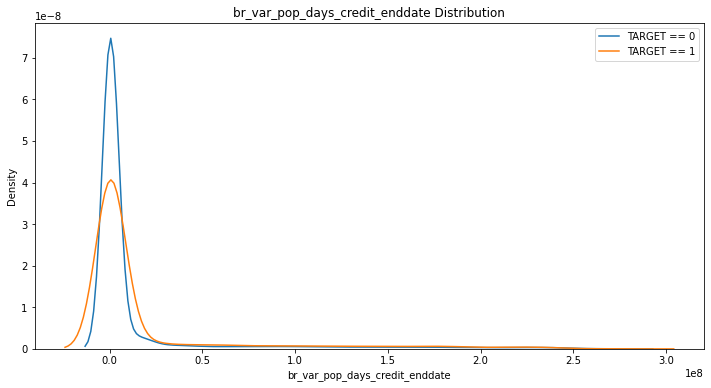

In [219]:
kde_target('br_var_pop_days_credit_enddate', app_train)

In [220]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_days_credit_enddate  
0  52.715068                    5.544007e+05  
1  49.490411                    3.654180e+05  
2  54.898630                    1.854475e+05  
3  38.290411                    1.104517e+08  
4  35.726027                    1.585426e+07  

[5 rows x 92 columns]

In [221]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [222]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [223]:
app_train['br_var_pop_days_credit_enddate'].isnull().sum()

0

In [224]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.00000                         0.02152
br_var_pop_days_credit_enddate  0.02152                         1.00000

In [225]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

In [226]:
## 標準化
num_cols = ['br_var_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_credit_enddate', 'TARGET']].corr()

br_var_pop_days_credit_enddate   TARGET
br_var_pop_days_credit_enddate                         1.00000  0.02152
TARGET                                                 0.02152  1.00000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0215
Median value for loan that was not repaid = 0.0020
Median value for loan that was repaid =     -0.0382


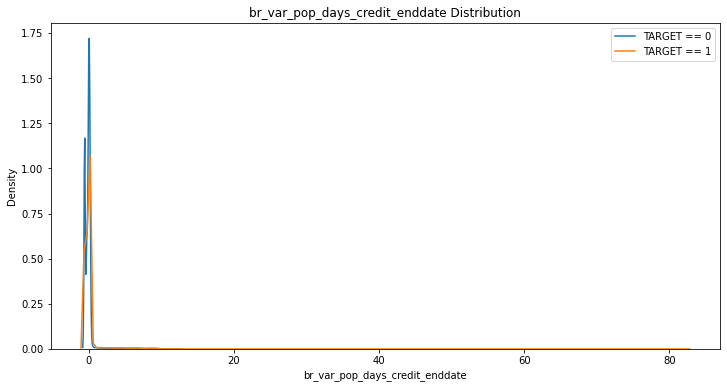

In [227]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_enddate', app_train)

### br_var_samp_days_credit_enddate

In [228]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

TARGET  br_var_samp_days_credit_enddate
TARGET                           1.000000                         0.026529
br_var_samp_days_credit_enddate  0.026529                         1.000000

In [229]:
app_train['br_var_samp_days_credit_enddate'].isnull().sum()

215579

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0265
Median value for loan that was not repaid = 451188.8648
Median value for loan that was repaid =     458383.1710


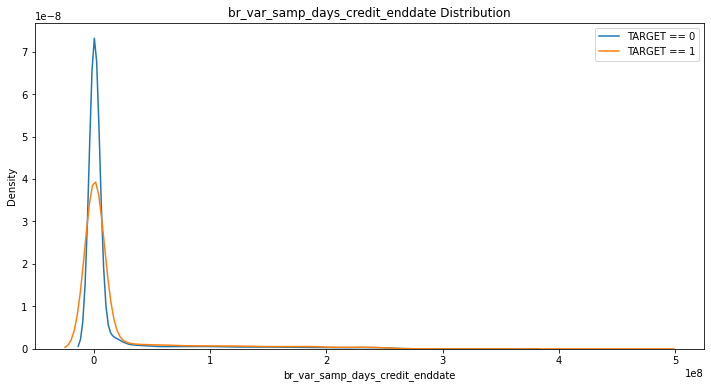

In [230]:
kde_target('br_var_samp_days_credit_enddate', app_train)

In [231]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_credit_enddate')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_days_credit_enddate  
0  52.715068                     5.576428e+05  
1  49.490411                     3.836889e+05  
2  54.898630                     1.863060e+05  
3  38.290411                     1.106776e+08  
4  35.726027                     1.599523e+07  

[5 rows x 92 columns]

In [232]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [233]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [234]:
app_train['br_var_samp_days_credit_enddate'].isnull().sum()

0

In [235]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

TARGET  br_var_samp_days_credit_enddate
TARGET                           1.000000                         0.022111
br_var_samp_days_credit_enddate  0.022111                         1.000000

In [236]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

In [237]:
## 標準化
num_cols = ['br_var_samp_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_credit_enddate', 'TARGET']].corr()

br_var_samp_days_credit_enddate    TARGET
br_var_samp_days_credit_enddate                         1.000000  0.022111
TARGET                                                  0.022111  1.000000

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0221
Median value for loan that was not repaid = 0.0024
Median value for loan that was repaid =     -0.0392


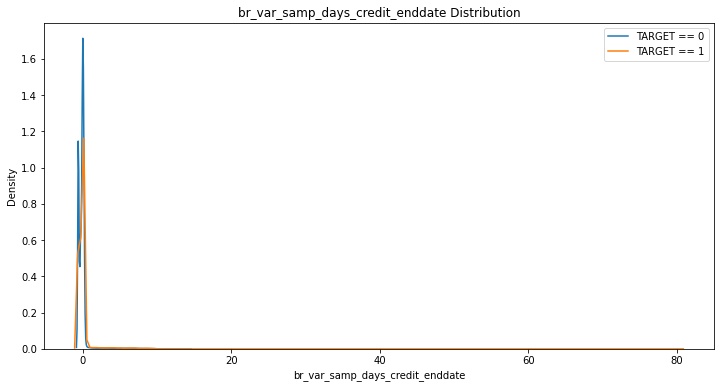

In [238]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_enddate', app_train)

### br_variance_pop_days_credit_enddate

In [239]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_days_credit_enddate  0.025917   

                                     br_variance_pop_days_credit_enddate  
TARGET                                                          0.025917  
br_variance_pop_days_credit_enddate                             1.000000

In [240]:
app_train['br_variance_pop_days_credit_enddate'].isnull().sum()

215579

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0259
Median value for loan that was not repaid = 445624.1613
Median value for loan that was repaid =     452623.4119


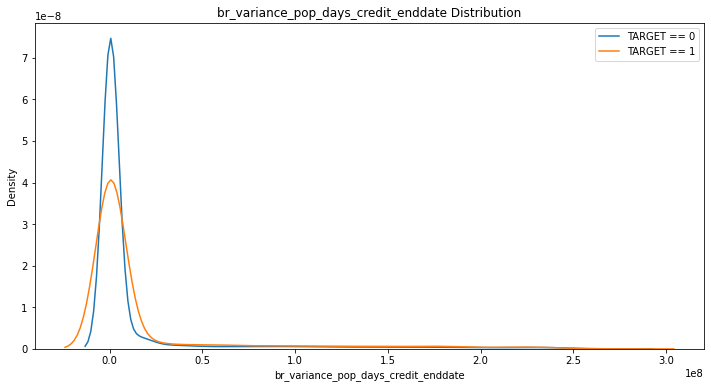

In [241]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

In [242]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_credit_enddate')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_days_credit_enddate  
0  52.715068                         5.544007e+05  
1  49.490411                         3.654180e+05  
2  54.898630                         1.854475e+05  
3  38.290411                         1.104517e+08  
4  35.726027                         1.585426e+07  

[5 rows x 92 columns]

In [243]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [244]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [245]:
app_train['br_variance_pop_days_credit_enddate'].isnull().sum()

0

In [246]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

TARGET  \
TARGET                               1.00000   
br_variance_pop_days_credit_enddate  0.02152   

                                     br_variance_pop_days_credit_enddate  
TARGET                                                           0.02152  
br_variance_pop_days_credit_enddate                              1.00000

In [247]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

In [248]:
## 標準化
num_cols = ['br_variance_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_credit_enddate', 'TARGET']].corr()

br_variance_pop_days_credit_enddate  \
br_variance_pop_days_credit_enddate                              1.00000   
TARGET                                                           0.02152   

                                      TARGET  
br_variance_pop_days_credit_enddate  0.02152  
TARGET                               1.00000

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0215
Median value for loan that was not repaid = 0.0020
Median value for loan that was repaid =     -0.0382


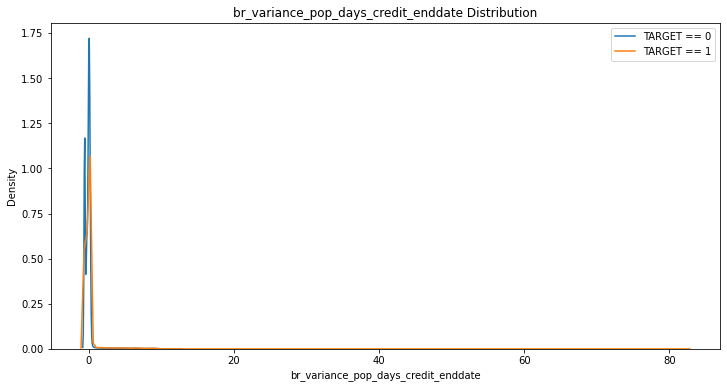

In [249]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

### br_min_days_enddate_fact

In [250]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.066363
br_min_days_enddate_fact  0.066363                  1.000000

In [251]:
app_train['br_min_days_enddate_fact'].isnull().sum()

215579

The correlation between br_min_days_enddate_fact and the TARGET is 0.0664
Median value for loan that was not repaid = -885.0000
Median value for loan that was repaid =     -1141.0000


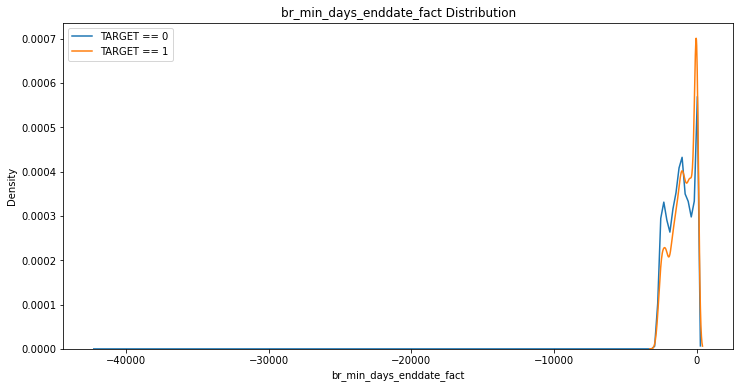

In [252]:
kde_target('br_min_days_enddate_fact', app_train)

In [253]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_days_enddate_fact  
0  52.715068              -1328.000000  
1  49.490411               -123.000000  
2  54.898630              -1334.000000  
3  38.290411              -1862.000000  
4  35.726027              -1279.823663  

[5 rows x 92 columns]

In [254]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [255]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [256]:
app_train['br_min_days_enddate_fact'].isnull().sum()

0

In [257]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.090787
br_min_days_enddate_fact  0.090787                  1.000000

In [258]:
## Yao-Johnson変換
num_cols = ['br_min_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_min_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.00000                   0.09236
br_min_days_enddate_fact  0.09236                   1.00000

In [259]:
## 標準化
num_cols = ['br_min_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_days_enddate_fact', 'TARGET']].corr()

br_min_days_enddate_fact   TARGET
br_min_days_enddate_fact                   1.00000  0.09236
TARGET                                     0.09236  1.00000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0924
Median value for loan that was not repaid = 0.2450
Median value for loan that was repaid =     -0.1087


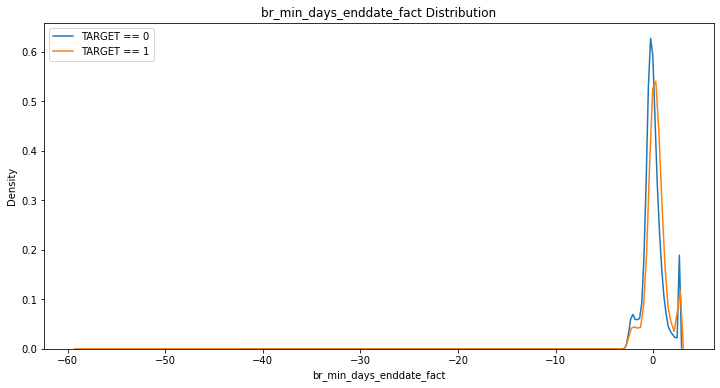

In [260]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_enddate_fact', app_train)

### br_max_days_enddate_fact

In [261]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.035493
br_max_days_enddate_fact  0.035493                  1.000000

In [262]:
app_train['br_max_days_enddate_fact'].isnull().sum()

215579

The correlation between br_max_days_enddate_fact and the TARGET is 0.0355
Median value for loan that was not repaid = -218.0000
Median value for loan that was repaid =     -272.0000


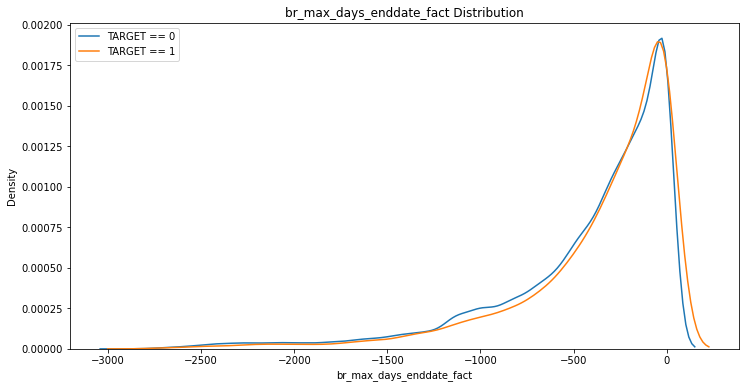

In [263]:
kde_target('br_max_days_enddate_fact', app_train)

In [264]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_days_enddate_fact  
0  52.715068               -544.000000  
1  49.490411               -123.000000  
2  54.898630               -549.000000  
3  38.290411               -687.000000  
4  35.726027               -441.385853  

[5 rows x 92 columns]

In [265]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [266]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [267]:
app_train['br_max_days_enddate_fact'].isnull().sum()

0

In [268]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.065527
br_max_days_enddate_fact  0.065527                  1.000000

In [269]:
## Yao-Johnson変換
num_cols = ['br_max_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_max_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.0000                    0.0672
br_max_days_enddate_fact  0.0672                    1.0000

In [270]:
## 標準化
num_cols = ['br_max_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_enddate_fact', 'TARGET']].corr()

br_max_days_enddate_fact  TARGET
br_max_days_enddate_fact                    1.0000  0.0672
TARGET                                      0.0672  1.0000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0672
Median value for loan that was not repaid = 0.2566
Median value for loan that was repaid =     -0.0230


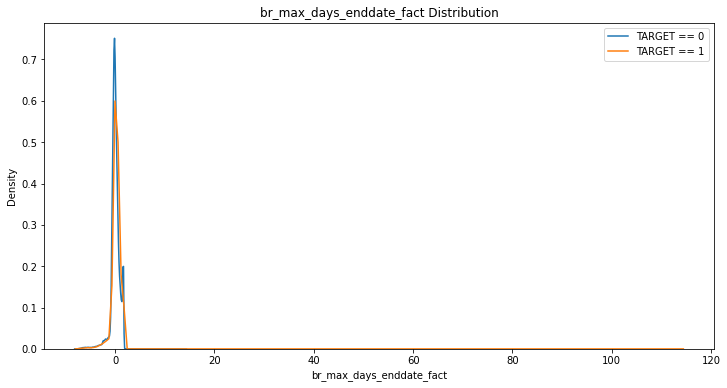

In [271]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_enddate_fact', app_train)

### br_sum_days_enddate_fact

In [272]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.052929
br_sum_days_enddate_fact  0.052929                  1.000000

In [273]:
app_train['br_sum_days_enddate_fact'].isnull().sum()

215579

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0529
Median value for loan that was not repaid = -31709.0000
Median value for loan that was repaid =     -60254.0000


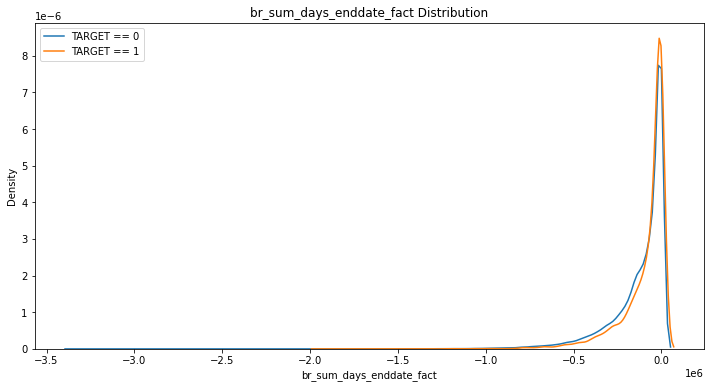

In [274]:
kde_target('br_sum_days_enddate_fact', app_train)

In [275]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_days_enddate_fact  
0  52.715068            -127179.000000  
1  49.490411              -1599.000000  
2  54.898630            -230587.000000  
3  38.290411            -478968.000000  
4  35.726027            -199321.269562  

[5 rows x 92 columns]

In [276]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [277]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [278]:
app_train['br_sum_days_enddate_fact'].isnull().sum()

0

In [279]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.052538
br_sum_days_enddate_fact  0.052538                  1.000000

In [280]:
## Yao-Johnson変換
num_cols = ['br_sum_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.057998
br_sum_days_enddate_fact  0.057998                  1.000000

In [281]:
## 標準化
num_cols = ['br_sum_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_enddate_fact', 'TARGET']].corr()

br_sum_days_enddate_fact    TARGET
br_sum_days_enddate_fact                  1.000000  0.057998
TARGET                                    0.057998  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0580
Median value for loan that was not repaid = 0.1819
Median value for loan that was repaid =     -0.0122


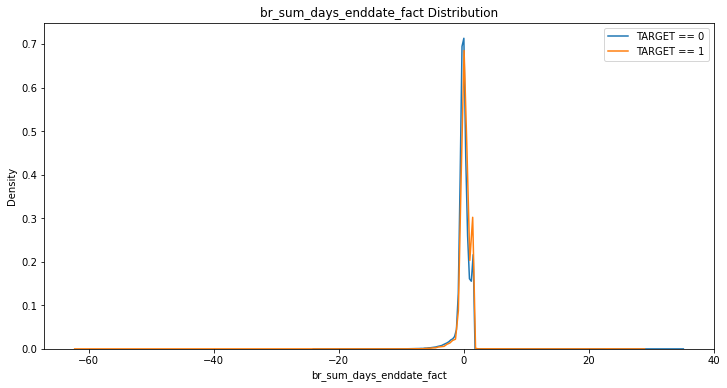

In [282]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_enddate_fact', app_train)

### br_avg_days_enddate_fact

In [283]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.00000                   0.06598
br_avg_days_enddate_fact  0.06598                   1.00000

In [284]:
app_train['br_avg_days_enddate_fact'].isnull().sum()

215579

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0660
Median value for loan that was not repaid = -641.5000
Median value for loan that was repaid =     -816.2619


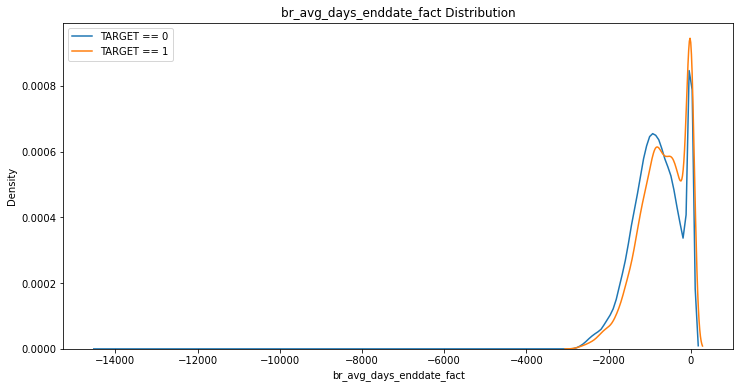

In [285]:
kde_target('br_avg_days_enddate_fact', app_train)

In [286]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_days_enddate_fact  
0  52.715068               -908.421400  
1  49.490411               -123.000000  
2  54.898630              -1062.612900  
3  38.290411              -1326.781200  
4  35.726027               -936.199912  

[5 rows x 92 columns]

In [287]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [288]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [289]:
app_train['br_avg_days_enddate_fact'].isnull().sum()

0

In [290]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.00000                   0.09681
br_avg_days_enddate_fact  0.09681                   1.00000

In [291]:
## Yao-Johnson変換
num_cols = ['br_avg_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.097116
br_avg_days_enddate_fact  0.097116                  1.000000

In [292]:
## 標準化
num_cols = ['br_avg_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_enddate_fact', 'TARGET']].corr()

br_avg_days_enddate_fact    TARGET
br_avg_days_enddate_fact                  1.000000  0.097116
TARGET                                    0.097116  1.000000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0971
Median value for loan that was not repaid = 0.2689
Median value for loan that was repaid =     -0.1144


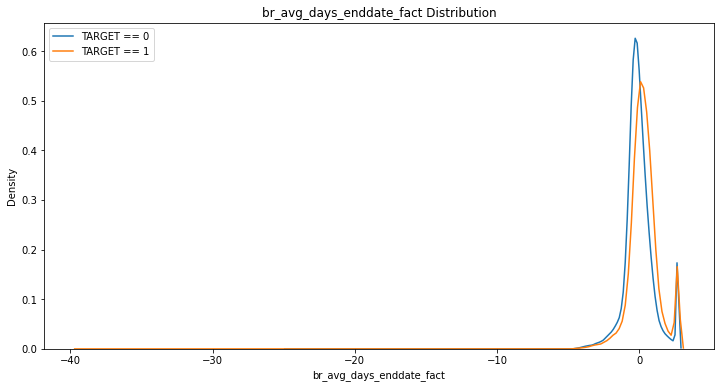

In [293]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_enddate_fact', app_train)

### br_cnt_days_enddate_fact

In [294]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.049224
br_cnt_days_enddate_fact -0.049224                  1.000000

In [295]:
app_train['br_cnt_days_enddate_fact'].isnull().sum()

215579

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0492
Median value for loan that was not repaid = 50.0000
Median value for loan that was repaid =     67.0000


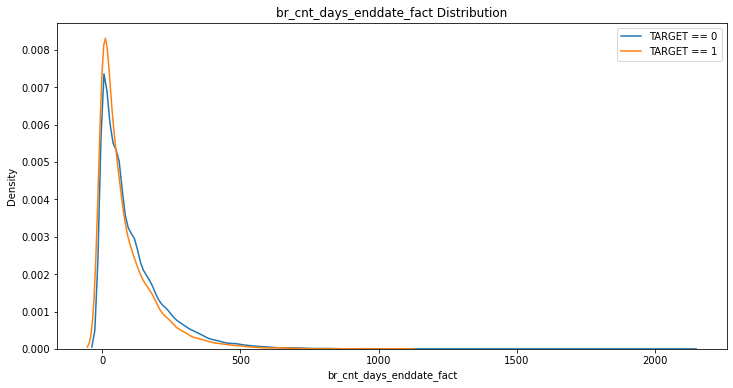

In [296]:
kde_target('br_cnt_days_enddate_fact', app_train)

In [297]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_days_enddate_fact  
0  52.715068                140.000000  
1  49.490411                 13.000000  
2  54.898630                217.000000  
3  38.290411                361.000000  
4  35.726027                147.883987  

[5 rows x 92 columns]

In [298]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [299]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [300]:
app_train['br_cnt_days_enddate_fact'].isnull().sum()

0

In [301]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.060977
br_cnt_days_enddate_fact -0.060977                  1.000000

In [302]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.072848
br_cnt_days_enddate_fact -0.072848                  1.000000

In [303]:
## 標準化
num_cols = ['br_cnt_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_enddate_fact', 'TARGET']].corr()

br_cnt_days_enddate_fact    TARGET
br_cnt_days_enddate_fact                  1.000000 -0.072848
TARGET                                   -0.072848  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0728
Median value for loan that was not repaid = -0.1563
Median value for loan that was repaid =     0.0910


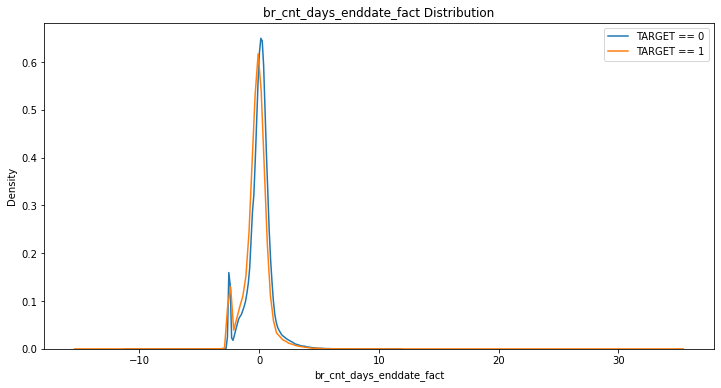

In [304]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_enddate_fact', app_train)

### br_stddev_days_enddate_fact

In [305]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.049746
br_stddev_days_enddate_fact -0.049746                     1.000000

In [306]:
app_train['br_stddev_days_enddate_fact'].isnull().sum()

215579

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0497
Median value for loan that was not repaid = 119.0580
Median value for loan that was repaid =     220.7851


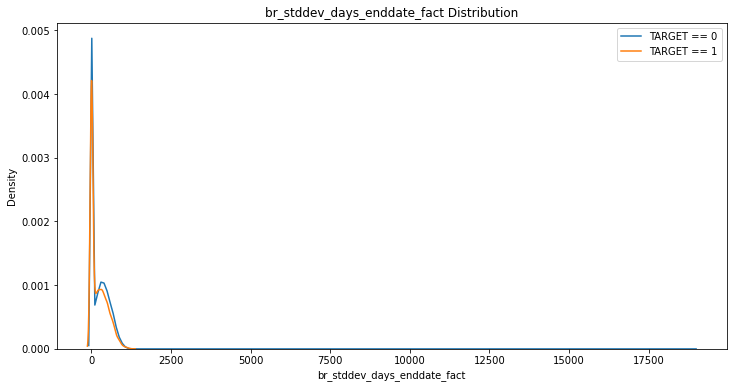

In [307]:
kde_target('br_stddev_days_enddate_fact', app_train)

In [308]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_days_enddate_fact  
0  52.715068                   345.364343  
1  49.490411                     0.000000  
2  54.898630                   308.087407  
3  38.290411                   457.494428  
4  35.726027                   307.337466  

[5 rows x 92 columns]

In [309]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [310]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [311]:
app_train['br_stddev_days_enddate_fact'].isnull().sum()

0

In [312]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.062284
br_stddev_days_enddate_fact -0.062284                     1.000000

In [313]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.065152
br_stddev_days_enddate_fact -0.065152                     1.000000

In [314]:
## 標準化
num_cols = ['br_stddev_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_enddate_fact', 'TARGET']].corr()

br_stddev_days_enddate_fact    TARGET
br_stddev_days_enddate_fact                     1.000000 -0.065152
TARGET                                         -0.065152  1.000000

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0652
Median value for loan that was not repaid = -0.0960
Median value for loan that was repaid =     0.1468


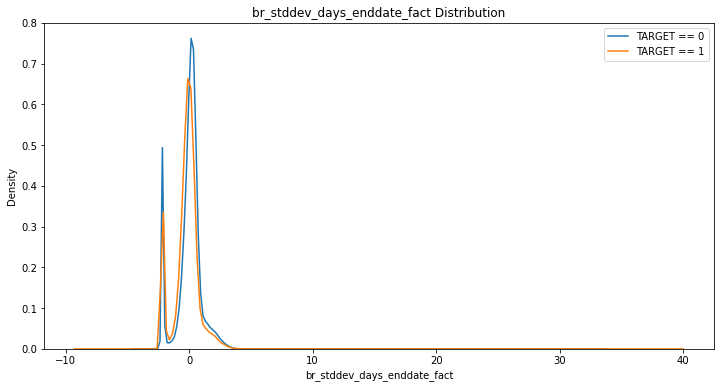

In [315]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_enddate_fact', app_train)

### br_stddev_pop_days_enddate_fact

In [316]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.049746
br_stddev_pop_days_enddate_fact -0.049746                         1.000000

In [317]:
app_train['br_stddev_pop_days_enddate_fact'].isnull().sum()

215579

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0497
Median value for loan that was not repaid = 119.0580
Median value for loan that was repaid =     220.7851


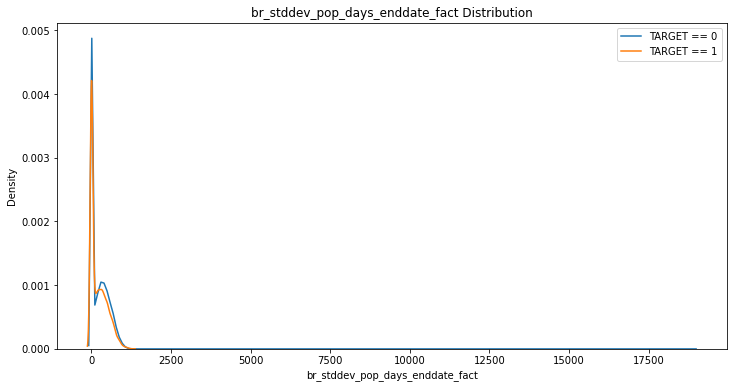

In [318]:
kde_target('br_stddev_pop_days_enddate_fact', app_train)

In [319]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_days_enddate_fact  
0  52.715068                       345.364343  
1  49.490411                         0.000000  
2  54.898630                       308.087407  
3  38.290411                       457.494428  
4  35.726027                       307.337466  

[5 rows x 92 columns]

In [320]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [321]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [322]:
app_train['br_stddev_pop_days_enddate_fact'].isnull().sum()

0

In [323]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.062284
br_stddev_pop_days_enddate_fact -0.062284                         1.000000

In [324]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.065152
br_stddev_pop_days_enddate_fact -0.065152                         1.000000

In [325]:
## 標準化
num_cols = ['br_stddev_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_enddate_fact', 'TARGET']].corr()

br_stddev_pop_days_enddate_fact    TARGET
br_stddev_pop_days_enddate_fact                         1.000000 -0.065152
TARGET                                                 -0.065152  1.000000

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0652
Median value for loan that was not repaid = -0.0960
Median value for loan that was repaid =     0.1468


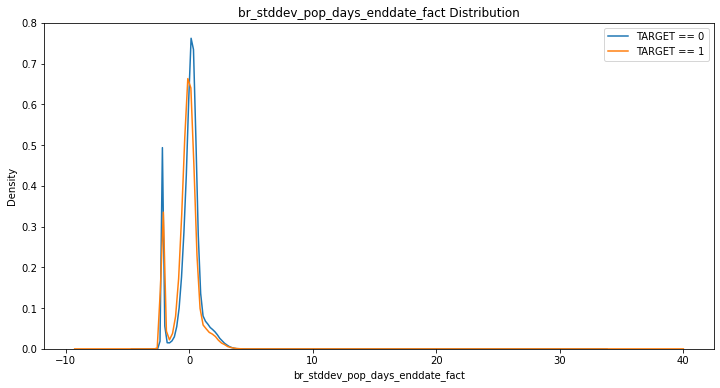

In [326]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_enddate_fact', app_train)

### br_var_pop_days_enddate_fact

In [327]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.008187
br_var_pop_days_enddate_fact -0.008187                      1.000000

In [328]:
app_train['br_var_pop_days_enddate_fact'].isnull().sum()

215579

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14174.8069
Median value for loan that was repaid =     48746.0656


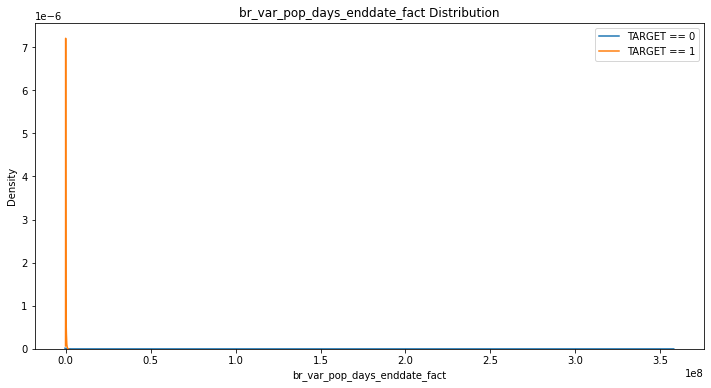

In [329]:
kde_target('br_var_pop_days_enddate_fact', app_train)

In [330]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_days_enddate_fact  
0  52.715068                 119276.529541  
1  49.490411                      0.000000  
2  54.898630                  94917.850156  
3  38.290411                 209301.151557  
4  35.726027                 181424.360971  

[5 rows x 92 columns]

In [331]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [332]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [333]:
app_train['br_var_pop_days_enddate_fact'].isnull().sum()

0

In [334]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.008672
br_var_pop_days_enddate_fact -0.008672                      1.000000

In [335]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.049275
br_var_pop_days_enddate_fact -0.049275                      1.000000

In [336]:
## 標準化
num_cols = ['br_var_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_enddate_fact', 'TARGET']].corr()

br_var_pop_days_enddate_fact    TARGET
br_var_pop_days_enddate_fact                      1.000000 -0.049275
TARGET                                           -0.049275  1.000000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0493
Median value for loan that was not repaid = 0.0076
Median value for loan that was repaid =     0.1744


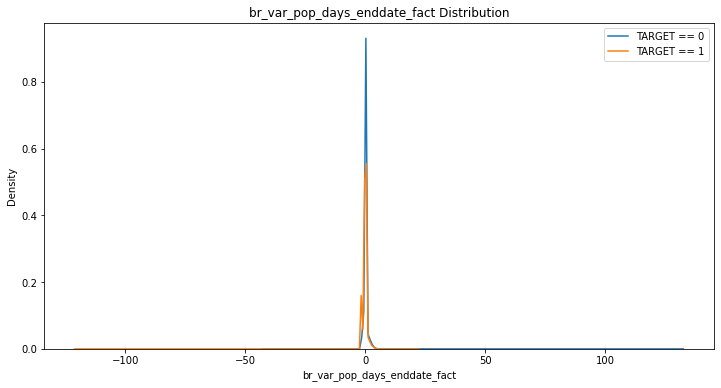

In [337]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_enddate_fact', app_train)

### br_var_samp_days_enddate_fact

In [338]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.008178
br_var_samp_days_enddate_fact -0.008178                       1.000000

In [339]:
app_train['br_var_samp_days_enddate_fact'].isnull().sum()

215579

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14635.2498
Median value for loan that was repaid =     49640.2576


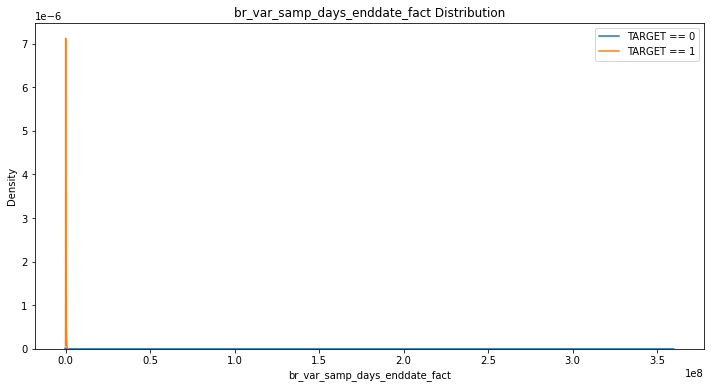

In [340]:
kde_target('br_var_samp_days_enddate_fact', app_train)

In [341]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_days_enddate_fact  
0  52.715068                  120134.634070  
1  49.490411                       0.000000  
2  54.898630                   95357.284648  
3  38.290411                  209882.543644  
4  35.726027                  182420.429395  

[5 rows x 92 columns]

In [342]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [343]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [344]:
app_train['br_var_samp_days_enddate_fact'].isnull().sum()

0

In [345]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.008668
br_var_samp_days_enddate_fact -0.008668                       1.000000

In [346]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.049394
br_var_samp_days_enddate_fact -0.049394                       1.000000

In [347]:
## 標準化
num_cols = ['br_var_samp_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_enddate_fact', 'TARGET']].corr()

br_var_samp_days_enddate_fact    TARGET
br_var_samp_days_enddate_fact                       1.000000 -0.049394
TARGET                                             -0.049394  1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0494
Median value for loan that was not repaid = 0.0213
Median value for loan that was repaid =     0.1869


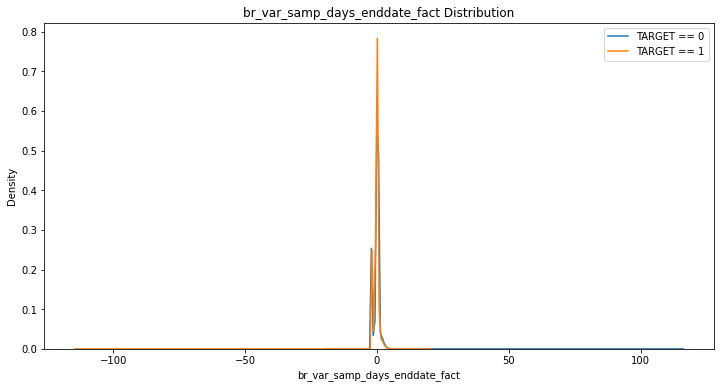

In [348]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_enddate_fact', app_train)

### br_variance_pop_days_enddate_fact

In [349]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.008187
br_variance_pop_days_enddate_fact -0.008187                           1.000000

In [350]:
app_train['br_variance_pop_days_enddate_fact'].isnull().sum()

215579

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14174.8069
Median value for loan that was repaid =     48746.0656


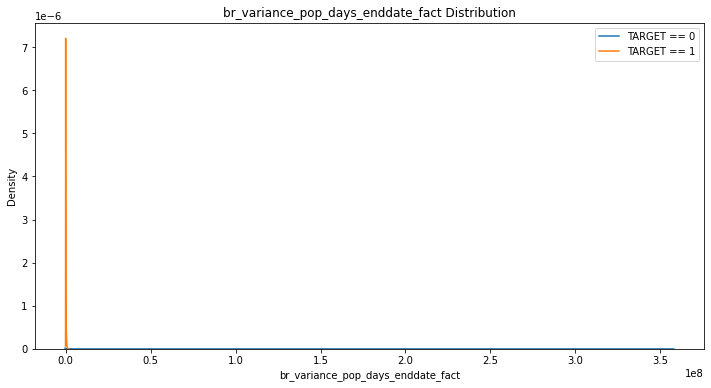

In [351]:
kde_target('br_variance_pop_days_enddate_fact', app_train)

In [352]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_days_enddate_fact  
0  52.715068                      119276.529541  
1  49.490411                           0.000000  
2  54.898630                       94917.850156  
3  38.290411                      209301.151557  
4  35.726027                      181424.360971  

[5 rows x 92 columns]

In [353]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [354]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [355]:
app_train['br_variance_pop_days_enddate_fact'].isnull().sum()

0

In [356]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.008672
br_variance_pop_days_enddate_fact -0.008672                           1.000000

In [357]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.049275
br_variance_pop_days_enddate_fact -0.049275                           1.000000

In [358]:
## 標準化
num_cols = ['br_variance_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_enddate_fact', 'TARGET']].corr()

br_variance_pop_days_enddate_fact    TARGET
br_variance_pop_days_enddate_fact                           1.000000 -0.049275
TARGET                                                     -0.049275  1.000000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0493
Median value for loan that was not repaid = 0.0076
Median value for loan that was repaid =     0.1744


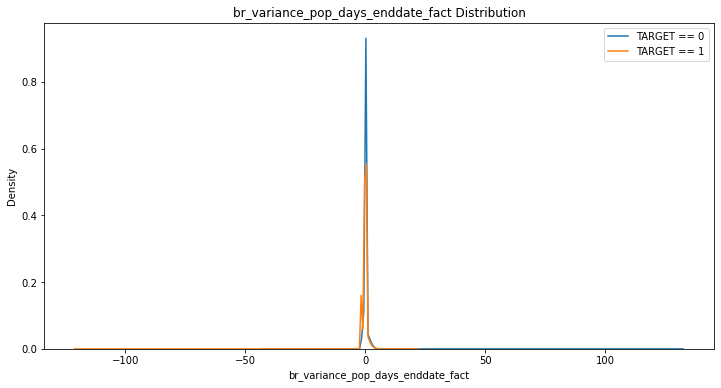

In [359]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_enddate_fact', app_train)

### br_min_amt_credit_max_overdue

In [360]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.002691
br_min_amt_credit_max_overdue  0.002691                       1.000000

In [361]:
app_train['br_min_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0027
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


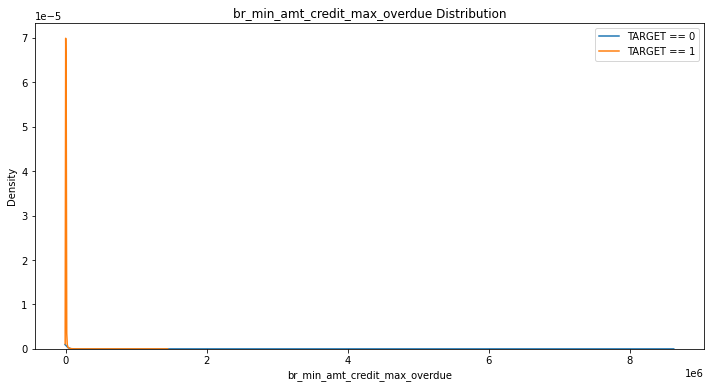

In [362]:
kde_target('br_min_amt_credit_max_overdue', app_train)

In [363]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [364]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [365]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [366]:
#app_train['br_min_amt_credit_max_overdue'].isnull().sum()

In [367]:
#app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

In [368]:
#num_cols = ['br_min_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_min_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

In [369]:
## 標準化
#num_cols = ['br_min_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_max_overdue', 'TARGET']].corr()

In [370]:
#kde_target('br_min_amt_credit_max_overdue', app_train)

In [371]:
columns = ['br_min_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_max_overdue

In [372]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.000000                       0.000545
br_max_amt_credit_max_overdue  0.000545                       1.000000

In [373]:
app_train['br_max_amt_credit_max_overdue'].isnull().sum()

215579

In [374]:
#kde_target('br_max_amt_credit_max_overdue', app_train)

In [375]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [376]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [377]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [378]:
#app_train['br_max_amt_credit_max_overdue'].isnull().sum()

In [379]:
#app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

In [380]:
#num_cols = ['br_max_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_max_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

In [381]:
## 標準化
#num_cols = ['br_max_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_max_overdue', 'TARGET']].corr()

In [382]:
#kde_target('br_max_amt_credit_max_overdue', app_train)

In [383]:
columns = ['br_max_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_max_overdue

In [384]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                      -0.000177
br_sum_amt_credit_max_overdue -0.000177                       1.000000

In [385]:
app_train['br_sum_amt_credit_max_overdue'].isnull().sum()

215579

In [386]:
#kde_target('br_sum_amt_credit_max_overdue', app_train)

In [387]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [388]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [389]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [390]:
#app_train['br_sum_amt_credit_max_overdue'].isnull().sum()

In [391]:
#app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

In [392]:
#num_cols = ['br_sum_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

In [393]:
## 標準化
#num_cols = ['br_sum_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_max_overdue', 'TARGET']].corr()

In [394]:
#kde_target('br_sum_amt_credit_max_overdue', app_train)

In [395]:
columns = ['br_sum_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_credit_max_overdue

In [396]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                      -0.000019
br_avg_amt_credit_max_overdue -0.000019                       1.000000

In [397]:
app_train['br_avg_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_avg_amt_credit_max_overdue and the TARGET is -0.0000
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


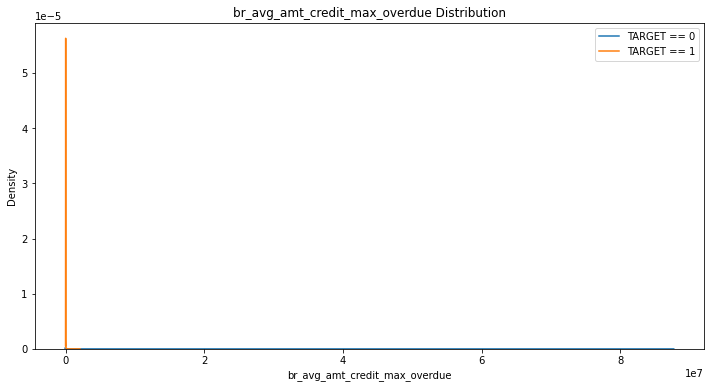

In [398]:
kde_target('br_avg_amt_credit_max_overdue', app_train)

In [399]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_max_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_amt_credit_max_overdue  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                   19305.000000  
3  38.290411                       0.000000  
4  35.726027                    3072.974928  

[5 rows x 92 columns]

In [400]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [401]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [402]:
app_train['br_avg_amt_credit_max_overdue'].isnull().sum()

0

In [403]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                      -0.000118
br_avg_amt_credit_max_overdue -0.000118                       1.000000

In [404]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                       0.009894
br_avg_amt_credit_max_overdue  0.009894                       1.000000

In [405]:
## 標準化
num_cols = ['br_avg_amt_credit_max_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_max_overdue', 'TARGET']].corr()

br_avg_amt_credit_max_overdue    TARGET
br_avg_amt_credit_max_overdue                       1.000000  0.009894
TARGET                                              0.009894  1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is 0.0099
Median value for loan that was not repaid = 0.3705
Median value for loan that was repaid =     0.3557


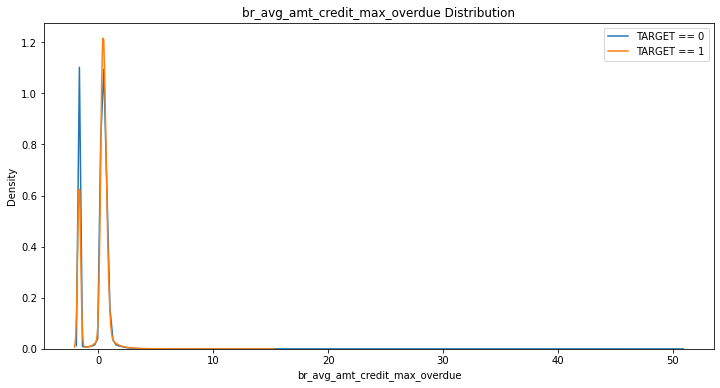

In [406]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_max_overdue', app_train)

### br_cnt_amt_credit_max_overdue

In [407]:
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                      -0.019445
br_cnt_amt_credit_max_overdue -0.019445                       1.000000

In [408]:
app_train['br_cnt_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is -0.0194
Median value for loan that was not repaid = 16.0000
Median value for loan that was repaid =     19.0000


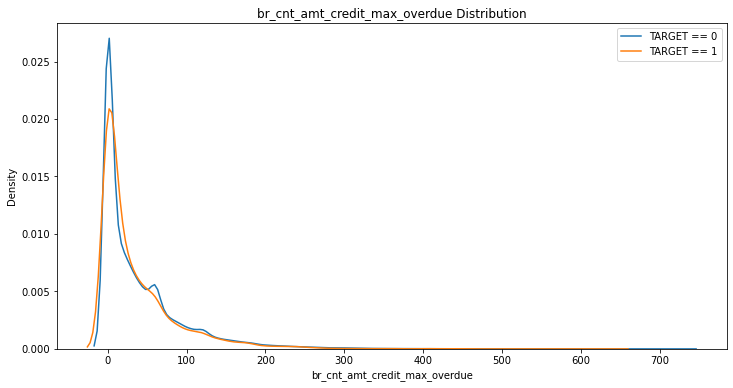

In [409]:
kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [410]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_cnt_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [411]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [412]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [413]:
#app_train['br_cnt_amt_credit_max_overdue'].isnull().sum()

In [414]:
#app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

In [415]:
## Yao-Johnson変換
#num_cols = ['br_cnt_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_cnt_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_cnt_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

In [416]:
## 標準化
#num_cols = ['br_cnt_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_cnt_amt_credit_max_overdue', 'TARGET']].corr()

In [417]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [418]:
columns = ['br_cnt_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_amt_credit_max_overdue

In [419]:
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                          0.000837
br_stddev_amt_credit_max_overdue  0.000837                          1.000000

In [420]:
app_train['br_stddev_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


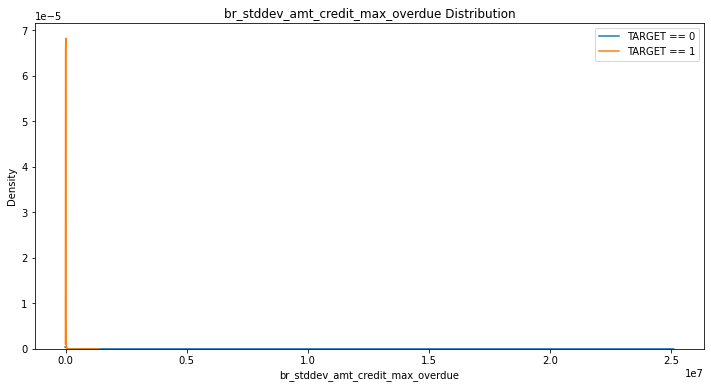

In [421]:
kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [422]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [423]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [424]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [425]:
#app_train['br_stddev_amt_credit_max_overdue'].isnull().sum()

In [426]:
#app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

In [427]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

In [428]:
## 標準化
#num_cols = ['br_stddev_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_max_overdue', 'TARGET']].corr()

In [429]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [430]:
columns = ['br_stddev_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_max_overdue

In [431]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue  0.000837   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                            0.000837  
br_stddev_pop_amt_credit_max_overdue                              1.000000

In [432]:
app_train['br_stddev_pop_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


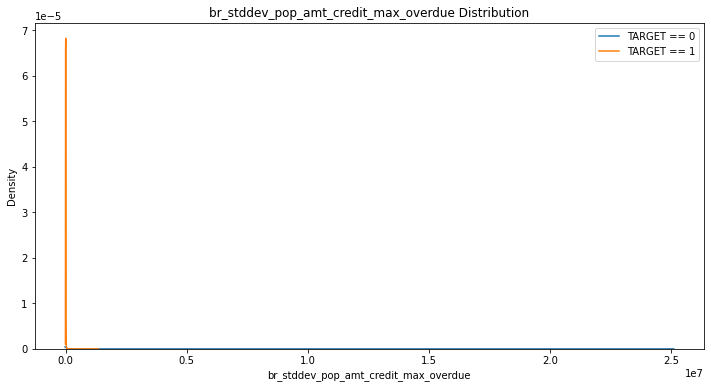

In [433]:
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [434]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [435]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [436]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [437]:
#app_train['br_stddev_pop_amt_credit_max_overdue'].isnull().sum()

In [438]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

In [439]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [440]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

In [441]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [442]:
columns = ['br_stddev_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_max_overdue

In [443]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                          -0.000962
br_var_pop_amt_credit_max_overdue -0.000962                           1.000000

In [444]:
app_train['br_var_pop_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


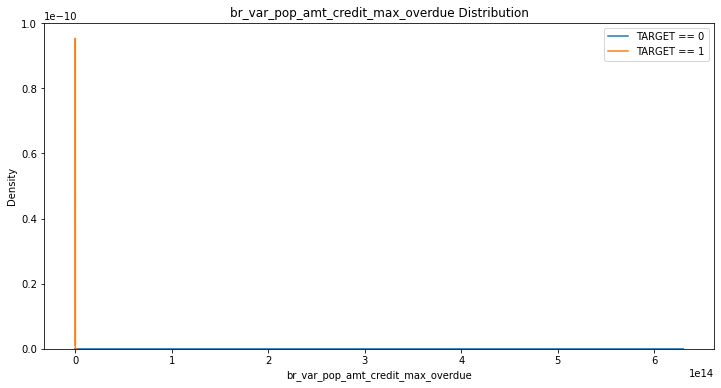

In [445]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [446]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [447]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [448]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [449]:
#app_train['br_var_pop_amt_credit_max_overdue'].isnull().sum()

In [450]:
#app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

In [451]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

In [452]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_max_overdue', 'TARGET']].corr()

In [453]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [454]:
columns = ['br_var_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_max_overdue

In [455]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue -0.000962   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                       -0.000962  
br_var_samp_amt_credit_max_overdue                            1.000000

In [456]:
app_train['br_var_samp_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


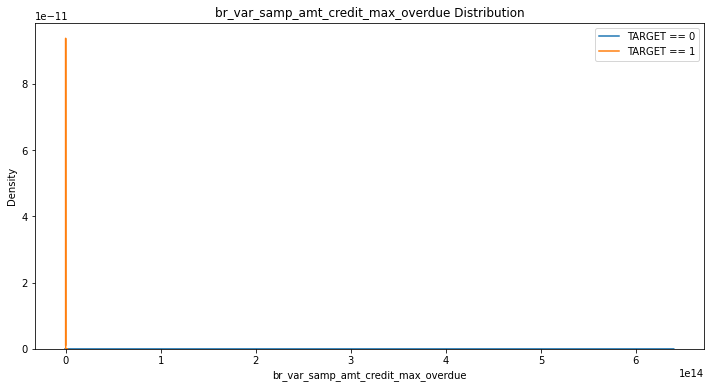

In [457]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [458]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [459]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [460]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [461]:
#app_train['br_var_samp_amt_credit_max_overdue'].isnull().sum()

In [462]:
#app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

In [463]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

In [464]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_max_overdue', 'TARGET']].corr()

In [465]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [466]:
columns = ['br_var_samp_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_max_overdue

In [467]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue -0.000962   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                               -0.000962  
br_variance_pop_amt_credit_max_overdue                                1.000000

In [468]:
app_train['br_variance_pop_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


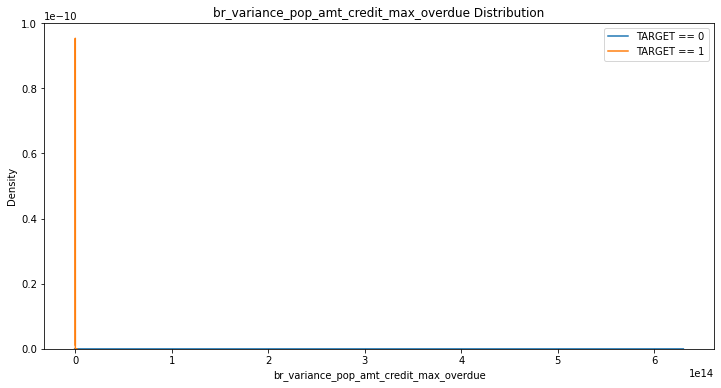

In [469]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [470]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_credit_day_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [471]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [472]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [473]:
#app_train['br_variance_pop_amt_credit_max_overdue'].isnull().sum()

In [474]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

In [475]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

In [476]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_max_overdue', 'TARGET']].corr()

In [477]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [478]:
columns = ['br_variance_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_cnt_credit_prolong

In [479]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.005553
br_min_cnt_credit_prolong  0.005553                   1.000000

In [480]:
app_train['br_min_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0056
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


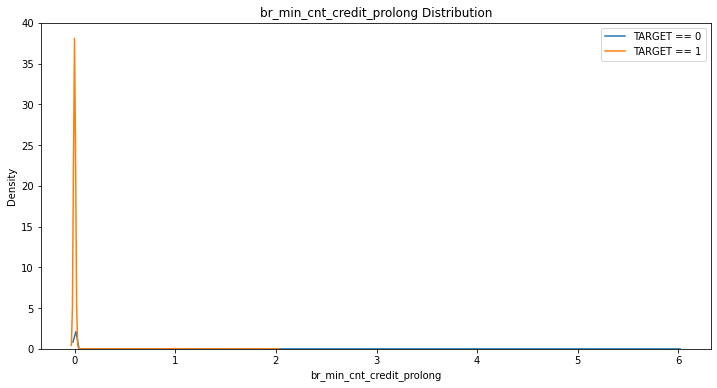

In [481]:
kde_target('br_min_cnt_credit_prolong', app_train)

In [482]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_cnt_credit_prolong  
0  52.715068                   0.000000  
1  49.490411                   0.000000  
2  54.898630                   0.000000  
3  38.290411                   0.000000  
4  35.726027                   0.000589  

[5 rows x 92 columns]

In [483]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [484]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [485]:
app_train['br_min_cnt_credit_prolong'].isnull().sum()

0

In [486]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.005063
br_min_cnt_credit_prolong  0.005063                   1.000000

In [487]:
## Yao-Johnson変換
num_cols = ['br_min_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_min_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.031651
br_min_cnt_credit_prolong  0.031651                   1.000000

In [488]:
## 標準化
num_cols = ['br_min_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_cnt_credit_prolong', 'TARGET']].corr()

br_min_cnt_credit_prolong    TARGET
br_min_cnt_credit_prolong                   1.000000  0.031651
TARGET                                      0.031651  1.000000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0317
Median value for loan that was not repaid = 0.0814
Median value for loan that was repaid =     -0.0955


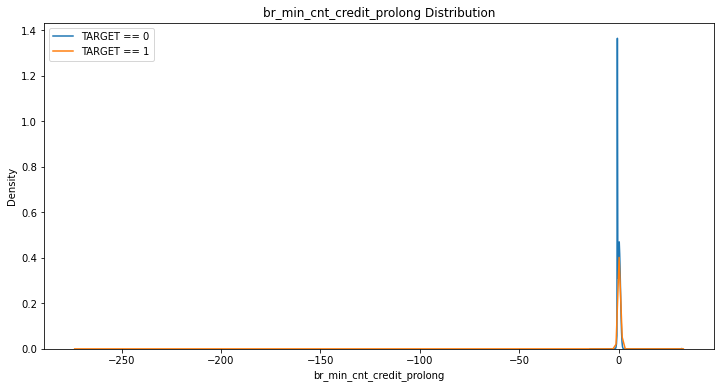

In [489]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_cnt_credit_prolong', app_train)

### br_max_cnt_credit_prolong

In [490]:
## 目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.007141
br_max_cnt_credit_prolong  0.007141                   1.000000

In [491]:
app_train['br_max_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0071
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


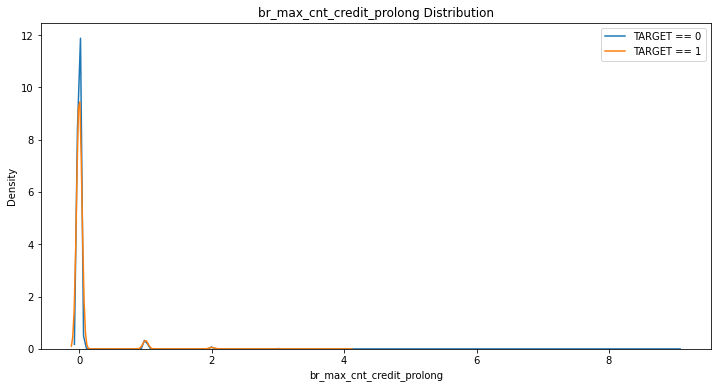

In [492]:
## 特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

In [493]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [494]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [495]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [496]:
#app_train['br_max_cnt_credit_prolong'].isnull().sum()

In [497]:
#app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

In [498]:
## Yao-Johnson変換
#num_cols = ['br_max_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_max_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

In [499]:
## 標準化
#num_cols = ['br_max_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_cnt_credit_prolong', 'TARGET']].corr()

In [500]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_cnt_credit_prolong', app_train)

In [ ]:
columns = ['br_max_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_cnt_credit_prolong

In [501]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.000000                  -0.002808
br_sum_cnt_credit_prolong -0.002808                   1.000000

In [502]:
app_train['br_sum_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_sum_cnt_credit_prolong and the TARGET is -0.0028
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


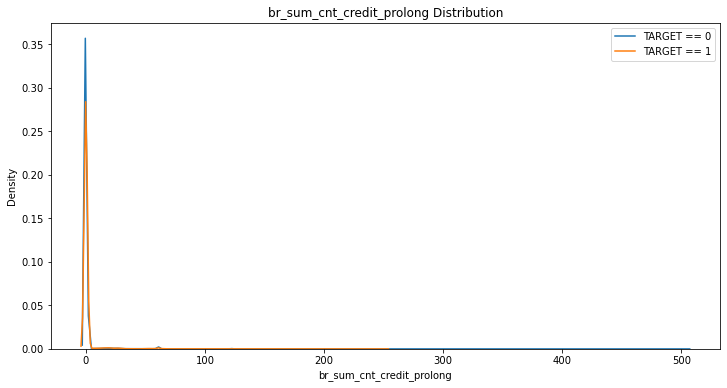

In [503]:
## 特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

In [504]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [505]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [506]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [507]:
#app_train['br_sum_cnt_credit_prolong'].isnull().sum()

In [508]:
#app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

In [509]:
## Yao-Johnson変換
#num_cols = ['br_sum_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_sum_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

In [510]:
## 標準化
#num_cols = ['br_sum_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_cnt_credit_prolong', 'TARGET']].corr()

In [511]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_cnt_credit_prolong', app_train)

In [512]:
columns = ['br_sum_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_cnt_credit_prolong

In [513]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.007663
br_avg_cnt_credit_prolong  0.007663                   1.000000

In [514]:
app_train['br_avg_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0077
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


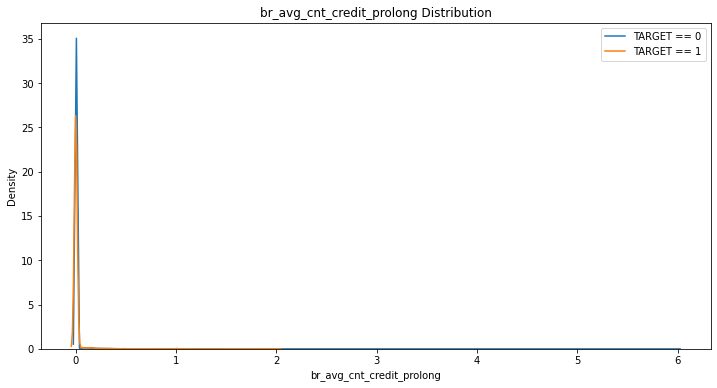

In [515]:
## 特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

In [516]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_cnt_credit_prolong  
0  52.715068                    0.00000  
1  49.490411                    0.00000  
2  54.898630                    0.00000  
3  38.290411                    0.00000  
4  35.726027                    0.00229  

[5 rows x 92 columns]

In [517]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [518]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [519]:
app_train['br_avg_cnt_credit_prolong'].isnull().sum()

0

In [520]:
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.007103
br_avg_cnt_credit_prolong  0.007103                   1.000000

In [521]:
## Yao-Johnson変換
num_cols = ['br_avg_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_avg_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.021714
br_avg_cnt_credit_prolong  0.021714                   1.000000

In [522]:
## 標準化
num_cols = ['br_avg_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_cnt_credit_prolong', 'TARGET']].corr()

br_avg_cnt_credit_prolong    TARGET
br_avg_cnt_credit_prolong                   1.000000  0.021714
TARGET                                      0.021714  1.000000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0217
Median value for loan that was not repaid = 0.4400
Median value for loan that was repaid =     0.2887


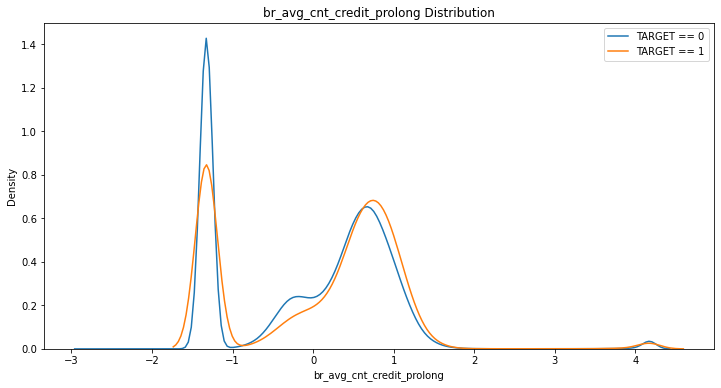

In [523]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

### br_cnt_cnt_credit_prolong

In [524]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.040412
br_cnt_cnt_credit_prolong -0.040412                   1.000000

In [525]:
app_train['br_cnt_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


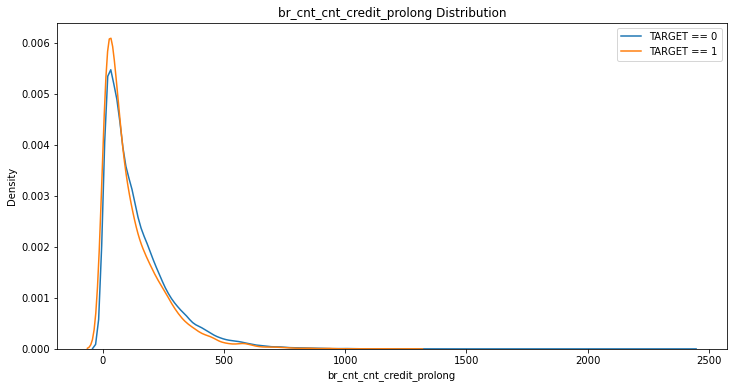

In [526]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

In [527]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_cnt_credit_prolong  
0  52.715068                 172.000000  
1  49.490411                  21.000000  
2  54.898630                 217.000000  
3  38.290411                 536.000000  
4  35.726027                 192.700818  

[5 rows x 92 columns]

In [528]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [529]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [530]:
app_train['br_cnt_cnt_credit_prolong'].isnull().sum()

0

In [531]:
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.048315
br_cnt_cnt_credit_prolong -0.048315                   1.000000

In [532]:
## Yao-Johnson変換
num_cols = ['br_cnt_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_cnt_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.061147
br_cnt_cnt_credit_prolong -0.061147                   1.000000

In [533]:
## 標準化
num_cols = ['br_cnt_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_cnt_credit_prolong', 'TARGET']].corr()

br_cnt_cnt_credit_prolong    TARGET
br_cnt_cnt_credit_prolong                   1.000000 -0.061147
TARGET                                     -0.061147  1.000000

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


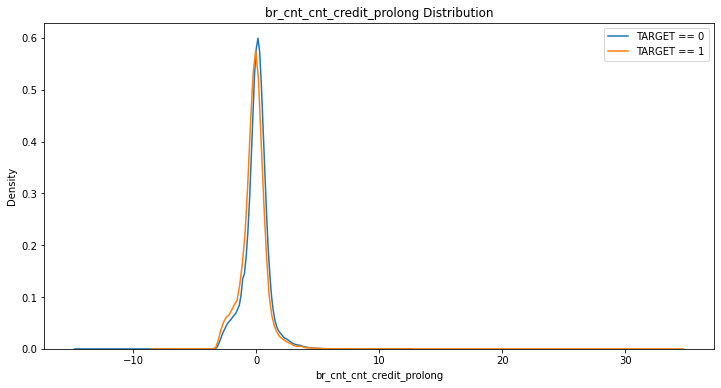

In [534]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

### br_stddev_cnt_credit_prolong

In [535]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.005682
br_stddev_cnt_credit_prolong  0.005682                      1.000000

In [536]:
app_train['br_stddev_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


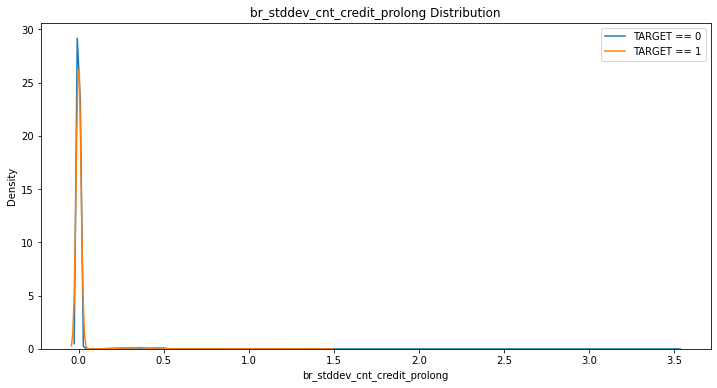

In [537]:
## 特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

In [538]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [539]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [540]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [541]:
#app_train['br_stddev_cnt_credit_prolong'].isnull().sum()

In [542]:
#app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

In [543]:
## Yao-Johnson変換
#num_cols = ['br_stddev_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

In [544]:
## 標準化
#num_cols = ['br_stddev_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_cnt_credit_prolong', 'TARGET']].corr()

In [545]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_cnt_credit_prolong', app_train)

In [546]:
columns = ['br_stddev_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_cnt_credit_prolong

In [547]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.005682
br_stddev_pop_cnt_credit_prolong  0.005682                          1.000000

In [548]:
app_train['br_stddev_pop_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


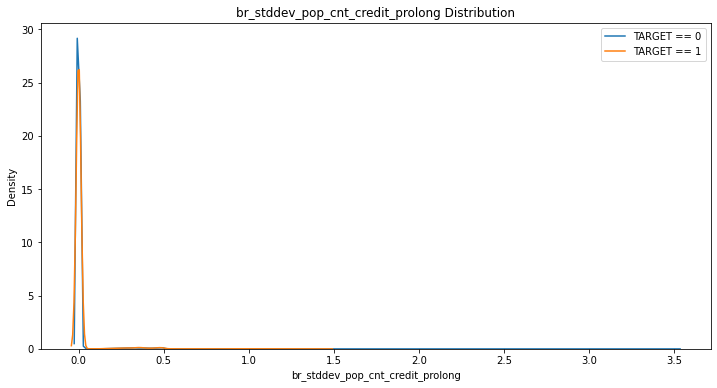

In [549]:
## 特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

In [550]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_cnt_credit_prolong  
0  52.715068                          0.000000  
1  49.490411                          0.000000  
2  54.898630                          0.000000  
3  38.290411                          0.000000  
4  35.726027                          0.003026  

[5 rows x 92 columns]

In [551]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [552]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [553]:
app_train['br_stddev_pop_cnt_credit_prolong'].isnull().sum()

0

In [554]:
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.004294
br_stddev_pop_cnt_credit_prolong  0.004294                          1.000000

In [555]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.005856
br_stddev_pop_cnt_credit_prolong  0.005856                          1.000000

In [556]:
## 標準化
num_cols = ['br_stddev_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_cnt_credit_prolong', 'TARGET']].corr()

br_stddev_pop_cnt_credit_prolong    TARGET
br_stddev_pop_cnt_credit_prolong                          1.000000  0.005856
TARGET                                                    0.005856  1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0059
Median value for loan that was not repaid = 0.3860
Median value for loan that was repaid =     0.3360


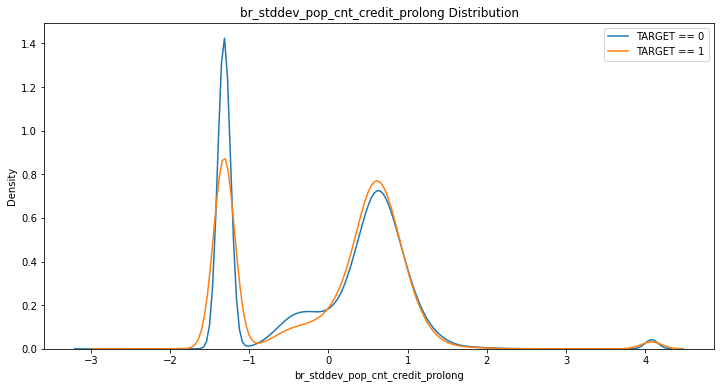

In [557]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

### br_var_pop_cnt_credit_prolong

In [558]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.000646
br_var_pop_cnt_credit_prolong  0.000646                       1.000000

In [559]:
app_train['br_var_pop_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0006
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


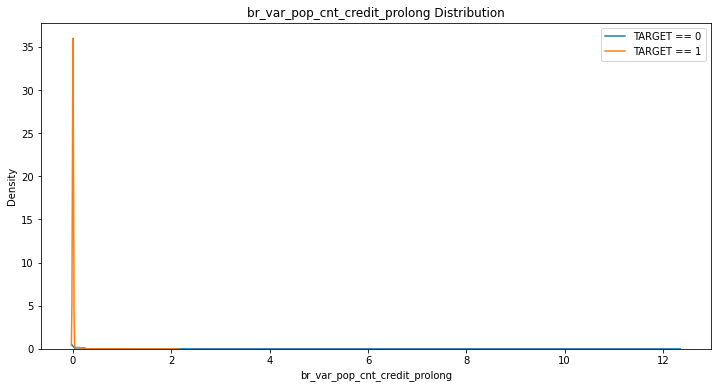

In [560]:
## 特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

In [561]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_cnt_credit_prolong  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                       0.000000  
3  38.290411                       0.000000  
4  35.726027                       0.001408  

[5 rows x 92 columns]

In [562]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [563]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [564]:
app_train['br_var_pop_cnt_credit_prolong'].isnull().sum()

0

In [565]:
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.000998
br_var_pop_cnt_credit_prolong  0.000998                       1.000000

In [566]:
## Yao-Johnson変換
num_cols = ['br_var_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.005925
br_var_pop_cnt_credit_prolong  0.005925                       1.000000

In [567]:
## 標準化
num_cols = ['br_var_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_cnt_credit_prolong', 'TARGET']].corr()

br_var_pop_cnt_credit_prolong    TARGET
br_var_pop_cnt_credit_prolong                       1.000000  0.005925
TARGET                                              0.005925  1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0059
Median value for loan that was not repaid = 0.3962
Median value for loan that was repaid =     0.3592


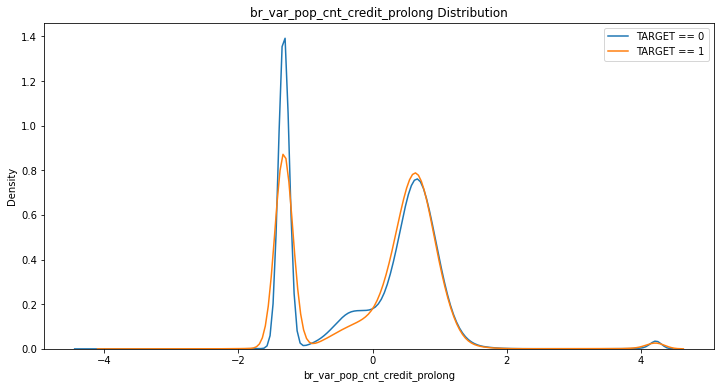

In [568]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

### br_var_samp_cnt_credit_prolong

In [569]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.000765
br_var_samp_cnt_credit_prolong  0.000765                        1.000000

In [570]:
app_train['br_var_samp_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


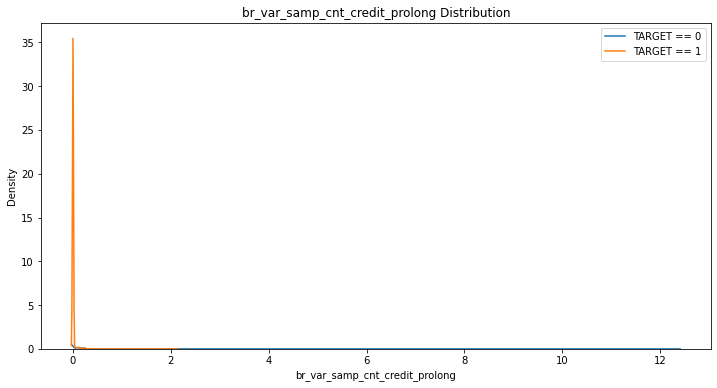

In [571]:
## 特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

In [572]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_cnt_credit_prolong  
0  52.715068                        0.000000  
1  49.490411                        0.000000  
2  54.898630                        0.000000  
3  38.290411                        0.000000  
4  35.726027                        0.001425  

[5 rows x 92 columns]

In [573]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [574]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [575]:
app_train['br_var_samp_cnt_credit_prolong'].isnull().sum()

0

In [576]:
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.001106
br_var_samp_cnt_credit_prolong  0.001106                        1.000000

In [577]:
## Yao-Johnson変換
num_cols = ['br_var_samp_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.00000                         0.00634
br_var_samp_cnt_credit_prolong  0.00634                         1.00000

In [578]:
## 標準化
num_cols = ['br_var_samp_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_cnt_credit_prolong', 'TARGET']].corr()

br_var_samp_cnt_credit_prolong   TARGET
br_var_samp_cnt_credit_prolong                         1.00000  0.00634
TARGET                                                 0.00634  1.00000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0063
Median value for loan that was not repaid = 0.4009
Median value for loan that was repaid =     0.3622


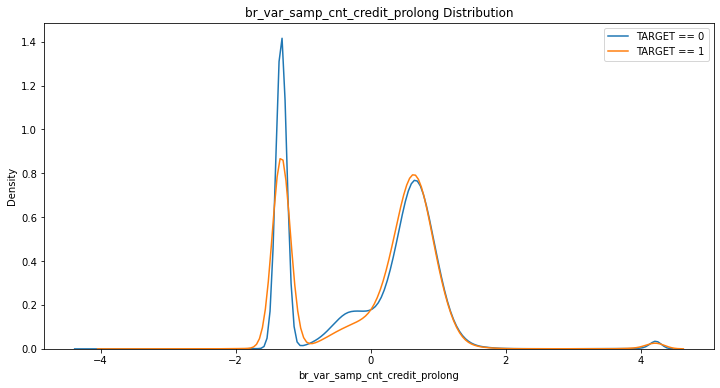

In [579]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

### br_variance_pop_cnt_credit_prolong

In [580]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.000646   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.000646  
br_variance_pop_cnt_credit_prolong                            1.000000

In [581]:
app_train['br_variance_pop_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0006
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


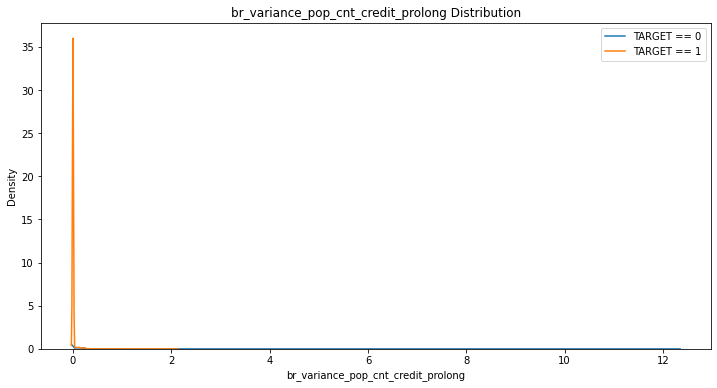

In [582]:
## 特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

In [583]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_cnt_credit_prolong  
0  52.715068                            0.000000  
1  49.490411                            0.000000  
2  54.898630                            0.000000  
3  38.290411                            0.000000  
4  35.726027                            0.001408  

[5 rows x 92 columns]

In [584]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [585]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [586]:
app_train['br_variance_pop_cnt_credit_prolong'].isnull().sum()

0

In [587]:
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.000998   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.000998  
br_variance_pop_cnt_credit_prolong                            1.000000

In [588]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.005925   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.005925  
br_variance_pop_cnt_credit_prolong                            1.000000

In [589]:
## 標準化
num_cols = ['br_variance_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_cnt_credit_prolong', 'TARGET']].corr()

br_variance_pop_cnt_credit_prolong  \
br_variance_pop_cnt_credit_prolong                            1.000000   
TARGET                                                        0.005925   

                                      TARGET  
br_variance_pop_cnt_credit_prolong  0.005925  
TARGET                              1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0059
Median value for loan that was not repaid = 0.3962
Median value for loan that was repaid =     0.3592


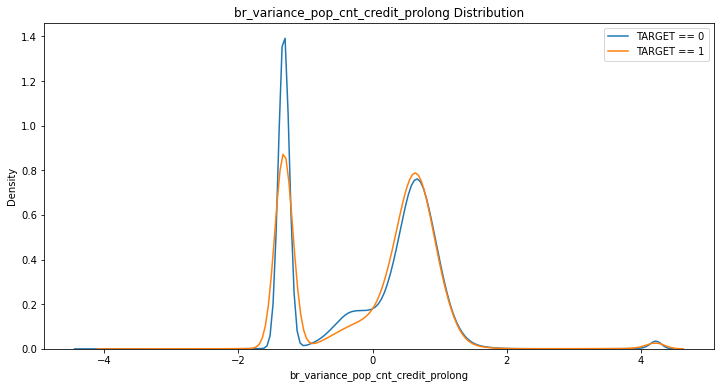

In [590]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

### br_min_amt_credit_sum

In [591]:
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.000000              -0.013165
br_min_amt_credit_sum -0.013165               1.000000

In [592]:
app_train['br_min_amt_credit_sum'].isnull().sum()

215579

The correlation between br_min_amt_credit_sum and the TARGET is -0.0132
Median value for loan that was not repaid = 36000.0000
Median value for loan that was repaid =     43128.0000


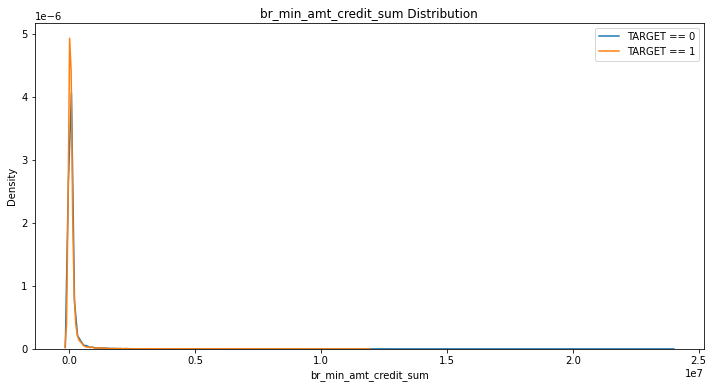

In [593]:
kde_target('br_min_amt_credit_sum', app_train)

In [594]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [595]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [596]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [597]:
#app_train['br_min_amt_credit_sum'].isnull().sum()

In [598]:
#app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

In [599]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

In [600]:
## 標準化
#num_cols = ['br_min_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum', 'TARGET']].corr()

In [601]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum', app_train)

In [602]:
columns = ['br_min_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_sum

In [603]:
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.018822
br_max_amt_credit_sum -0.018822               1.000000

In [604]:
app_train['br_max_amt_credit_sum'].isnull().sum()

215579

The correlation between br_max_amt_credit_sum and the TARGET is -0.0188
Median value for loan that was not repaid = 450000.0000
Median value for loan that was repaid =     454500.0000


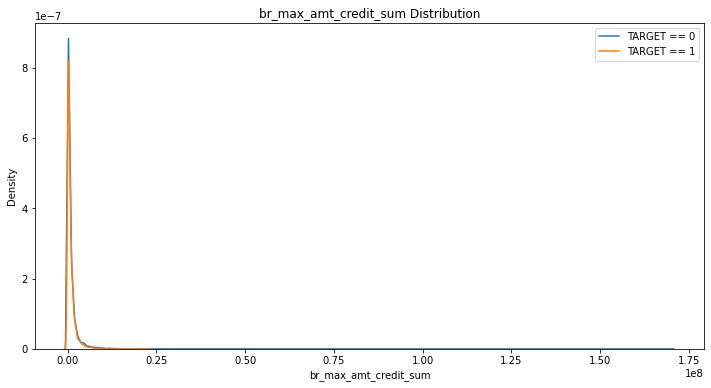

In [605]:
kde_target('br_max_amt_credit_sum', app_train)

In [606]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [607]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [608]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [609]:
#app_train['br_max_amt_credit_sum'].isnull().sum()

In [610]:
#app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

In [611]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

In [612]:
## 標準化
#num_cols = ['br_max_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_sum', 'TARGET']].corr()

In [613]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum', app_train)

In [614]:
columns = ['br_max_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_sum

In [615]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.029583
br_sum_amt_credit_sum -0.029583               1.000000

In [616]:
app_train['br_sum_amt_credit_sum'].isnull().sum()

215579

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0296
Median value for loan that was not repaid = 15241648.8600
Median value for loan that was repaid =     20821472.8200


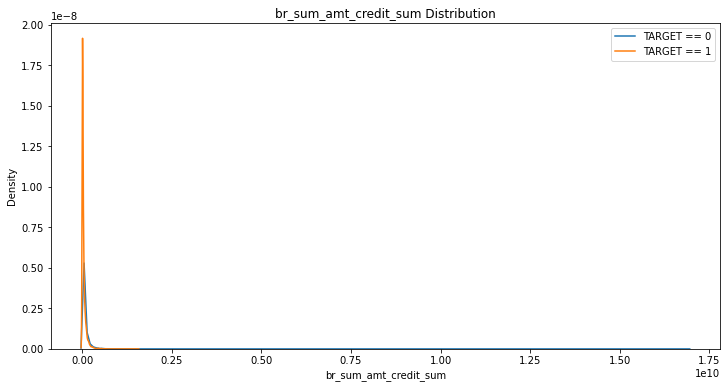

In [617]:
kde_target('br_sum_amt_credit_sum', app_train)

In [618]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_amt_credit_sum  
0  52.715068           2.778080e+07  
1  49.490411           3.693978e+06  
2  54.898630           1.182793e+08  
3  38.290411           6.035430e+07  
4  35.726027           8.070155e+07  

[5 rows x 92 columns]

In [619]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [620]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [621]:
app_train['br_sum_amt_credit_sum'].isnull().sum()

0

In [622]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.018828
br_sum_amt_credit_sum -0.018828               1.000000

In [623]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.026953
br_sum_amt_credit_sum -0.026953               1.000000

In [624]:
## 標準化
num_cols = ['br_sum_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_amt_credit_sum', 'TARGET']].corr()

br_sum_amt_credit_sum    TARGET
br_sum_amt_credit_sum               1.000000 -0.026953
TARGET                             -0.026953  1.000000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0270
Median value for loan that was not repaid = -0.1597
Median value for loan that was repaid =     -0.0875


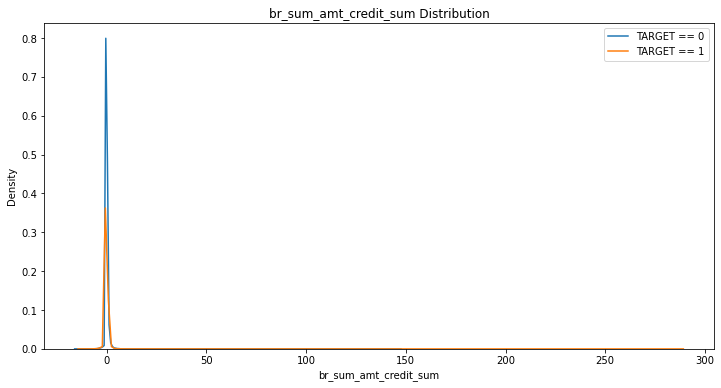

In [625]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum', app_train)

### br_avg_amt_credit_sum

In [626]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.024909
br_avg_amt_credit_sum -0.024909               1.000000

In [627]:
app_train['br_avg_amt_credit_sum'].isnull().sum()

215579

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0249
Median value for loan that was not repaid = 177727.9592
Median value for loan that was repaid =     193234.7520


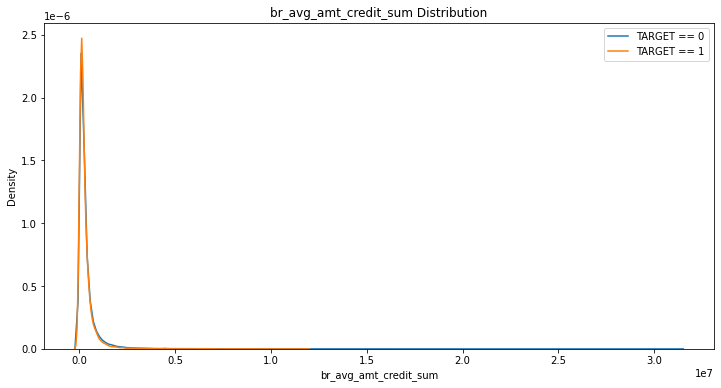

In [628]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

In [629]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_amt_credit_sum  
0  52.715068          161516.250000  
1  49.490411          175903.714286  
2  54.898630          545065.863594  
3  38.290411          112601.301716  
4  35.726027          415196.384613  

[5 rows x 92 columns]

In [630]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [631]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [632]:
app_train['br_avg_amt_credit_sum'].isnull().sum()

0

In [633]:
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.009137
br_avg_amt_credit_sum -0.009137               1.000000

In [634]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.011536
br_avg_amt_credit_sum -0.011536               1.000000

In [635]:
## 標準化
num_cols = ['br_avg_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_sum', 'TARGET']].corr()

br_avg_amt_credit_sum    TARGET
br_avg_amt_credit_sum               1.000000 -0.011536
TARGET                             -0.011536  1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0115
Median value for loan that was not repaid = -0.1154
Median value for loan that was repaid =     -0.1036


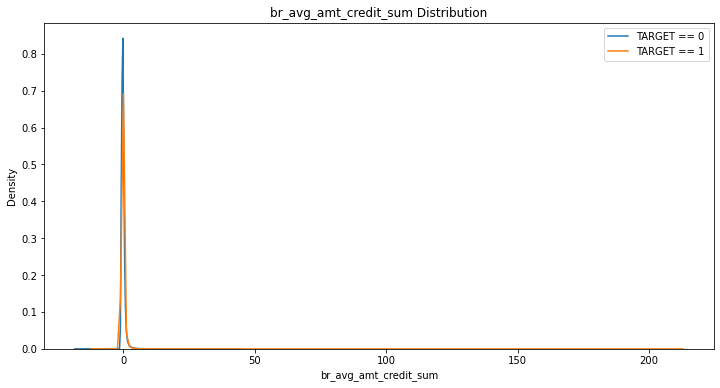

In [636]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

### br_cnt_amt_credit_sum

In [637]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.040412
br_cnt_amt_credit_sum -0.040412               1.000000

In [638]:
app_train['br_cnt_amt_credit_sum'].isnull().sum()

215579

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


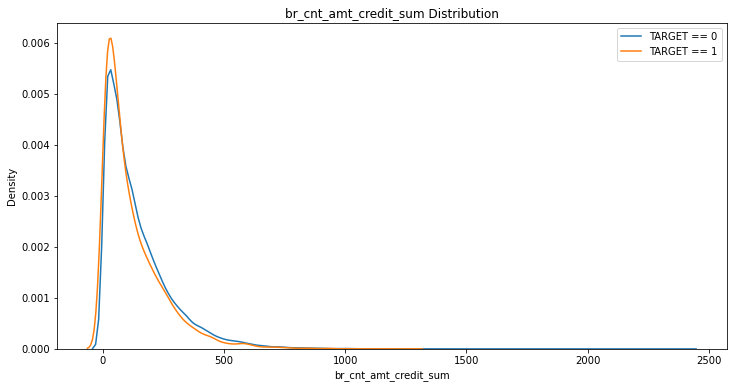

In [639]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

In [640]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum  
0  52.715068             172.000000  
1  49.490411              21.000000  
2  54.898630             217.000000  
3  38.290411             536.000000  
4  35.726027             192.700974  

[5 rows x 92 columns]

In [641]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [642]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [643]:
app_train['br_cnt_amt_credit_sum'].isnull().sum()

0

In [644]:
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.048315
br_cnt_amt_credit_sum -0.048315               1.000000

In [645]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.061147
br_cnt_amt_credit_sum -0.061147               1.000000

In [646]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum', 'TARGET']].corr()

br_cnt_amt_credit_sum    TARGET
br_cnt_amt_credit_sum               1.000000 -0.061147
TARGET                             -0.061147  1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


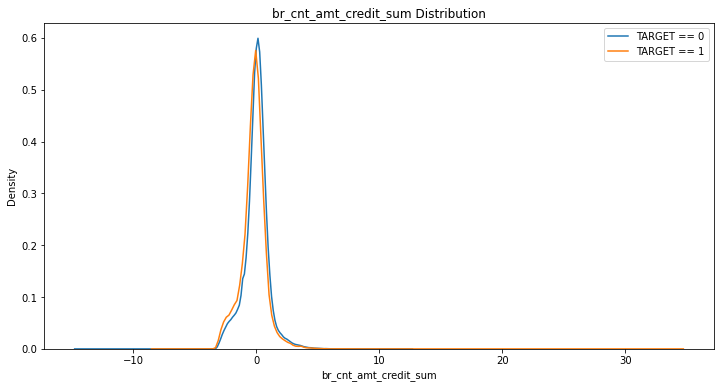

In [647]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

### br_stddev_amt_credit_sum

In [648]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.000000                 -0.018673
br_stddev_amt_credit_sum -0.018673                  1.000000

In [649]:
app_train['br_stddev_amt_credit_sum'].isnull().sum()

215579

The correlation between br_stddev_amt_credit_sum and the TARGET is -0.0187
Median value for loan that was not repaid = 115148.8013
Median value for loan that was repaid =     121694.9680


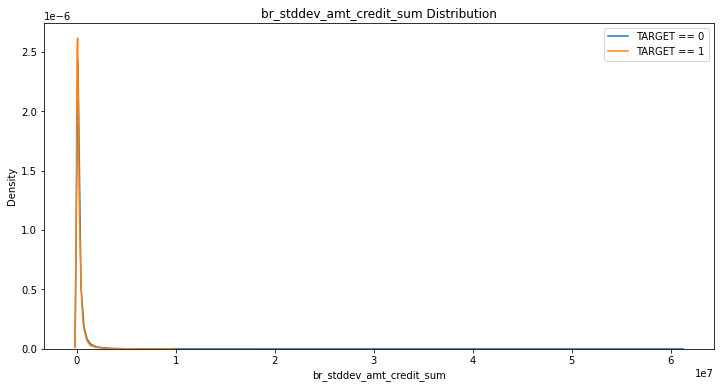

In [650]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

In [ ]:
#########

In [651]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_amt_credit_sum  
0  52.715068                  96896.059573  
1  49.490411                 219852.847988  
2  54.898630                 492595.629954  
3  38.290411                  96219.671997  
4  35.726027                 374828.892859  

[5 rows x 92 columns]

In [652]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [653]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [654]:
app_train['br_stddev_amt_credit_sum'].isnull().sum()

215579

In [655]:
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.000000                 -0.018673
br_stddev_amt_credit_sum -0.018673                  1.000000

In [656]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.000000                 -0.019537
br_stddev_amt_credit_sum -0.019537                  1.000000

In [657]:
## 標準化
num_cols = ['br_stddev_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_amt_credit_sum', 'TARGET']].corr()

br_stddev_amt_credit_sum    TARGET
br_stddev_amt_credit_sum                  1.000000 -0.019537
TARGET                                   -0.019537  1.000000

The correlation between br_stddev_amt_credit_sum and the TARGET is -0.0195
Median value for loan that was not repaid = 0.0865
Median value for loan that was repaid =     0.1129


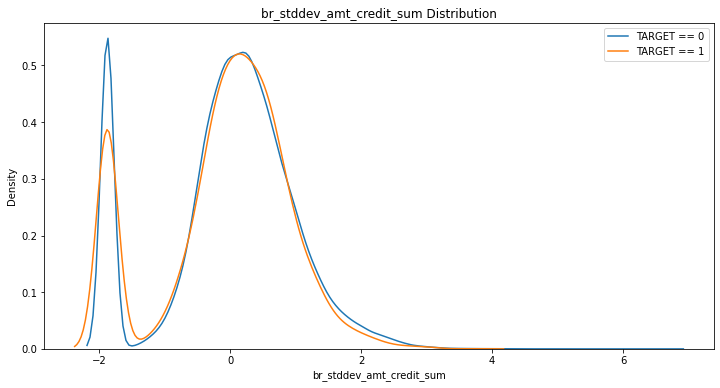

In [658]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

In [659]:
#######################################

In [660]:
#######################################

In [661]:
#######################################

In [662]:
#######################################

In [663]:
#######################################

In [664]:
#######################################

### br_stddev_pop_amt_credit_sum

In [665]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

TARGET  br_stddev_pop_amt_credit_sum
TARGET                        1.000000                     -0.007223
br_stddev_pop_amt_credit_sum -0.007223                      1.000000

In [666]:
app_train['br_stddev_pop_amt_credit_sum'].isnull().sum()

0

The correlation between br_stddev_pop_amt_credit_sum and the TARGET is -0.0072
Median value for loan that was not repaid = 210147.0728
Median value for loan that was repaid =     216432.9809


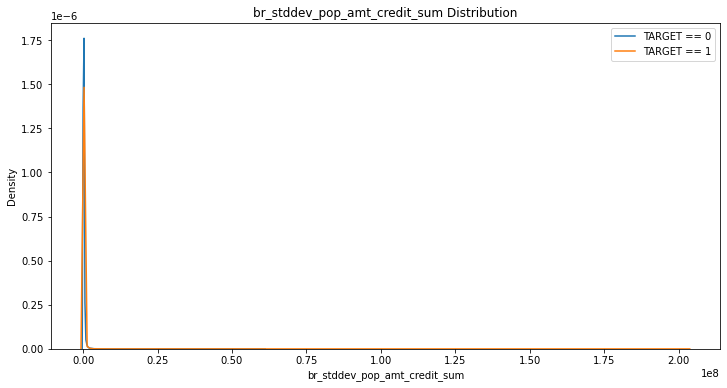

In [667]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum', app_train)

In [668]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [669]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [670]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [671]:
#app_train['br_stddev_pop_amt_credit_sum'].isnull().sum()

In [672]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

In [673]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

In [674]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum', 'TARGET']].corr()

In [675]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum', app_train)

In [676]:
columns = ['br_stddev_pop_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum

In [677]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.003815
br_var_pop_amt_credit_sum -0.003815                   1.000000

In [678]:
app_train['br_var_pop_amt_credit_sum'].isnull().sum()

215579

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0038
Median value for loan that was not repaid = 13259246440.4831
Median value for loan that was repaid =     14809665239.1709


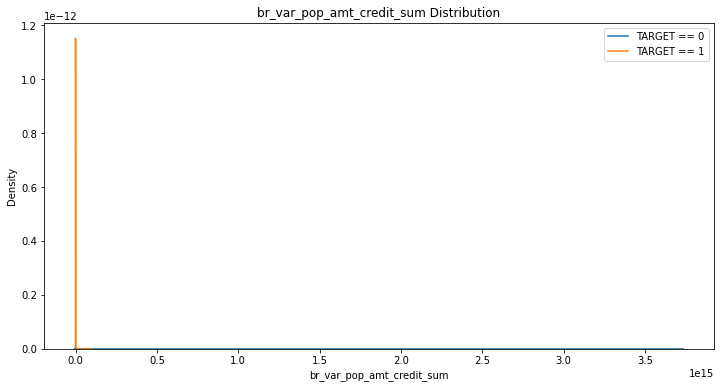

In [679]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

In [680]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()


In [681]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()


In [682]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [683]:
#app_train['br_var_pop_amt_credit_sum'].isnull().sum()

In [684]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

In [685]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

In [686]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum', 'TARGET']].corr()

In [687]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum', app_train)

In [688]:
columns = ['br_var_pop_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum

In [689]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.003828
br_var_samp_amt_credit_sum -0.003828                    1.000000

In [690]:
app_train['br_var_samp_amt_credit_sum'].isnull().sum()

215579

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0038
Median value for loan that was not repaid = 13489676875.7267
Median value for loan that was repaid =     15016340629.4280


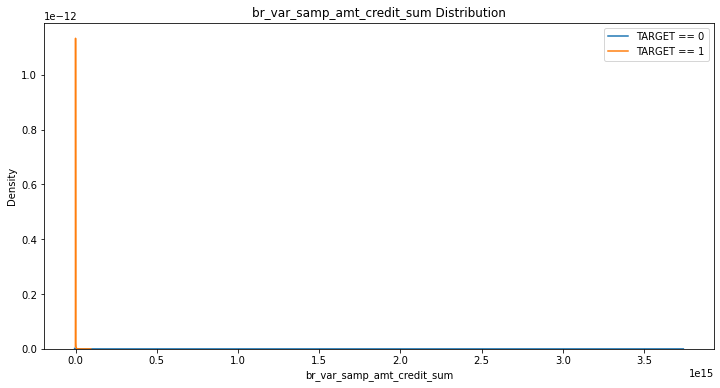

In [691]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

In [692]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [693]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [694]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [695]:
#app_train['br_var_samp_amt_credit_sum'].isnull().sum()

In [696]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

In [697]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

In [698]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum', 'TARGET']].corr()

In [699]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum', app_train)

In [700]:
columns = ['br_var_samp_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum

In [701]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.003815
br_variance_pop_amt_credit_sum -0.003815                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0038
Median value for loan that was not repaid = 13259246440.4831
Median value for loan that was repaid =     14809665239.1709


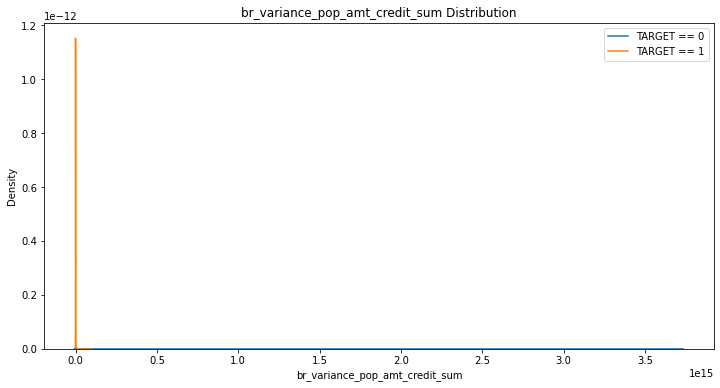

In [702]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [703]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [704]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.019536
br_variance_pop_amt_credit_sum -0.019536                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0195
Median value for loan that was not repaid = 0.0865
Median value for loan that was repaid =     0.1129


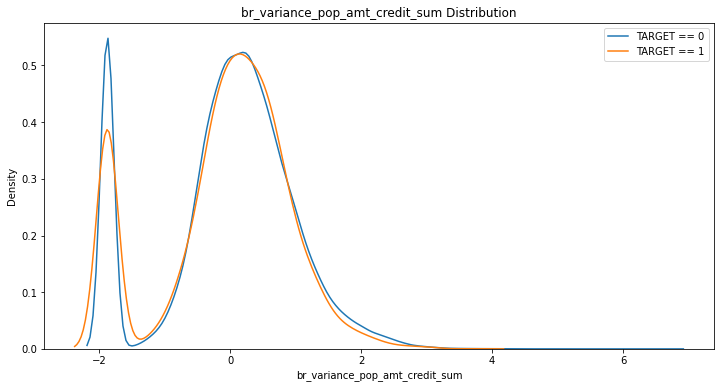

In [705]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [ ]:
#### 

### br_min_amt_credit_sum_debt

In [706]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.00000                    -0.00119
br_min_amt_credit_sum_debt -0.00119                     1.00000

In [707]:
app_train['br_min_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_min_amt_credit_sum_debt and the TARGET is -0.0012
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


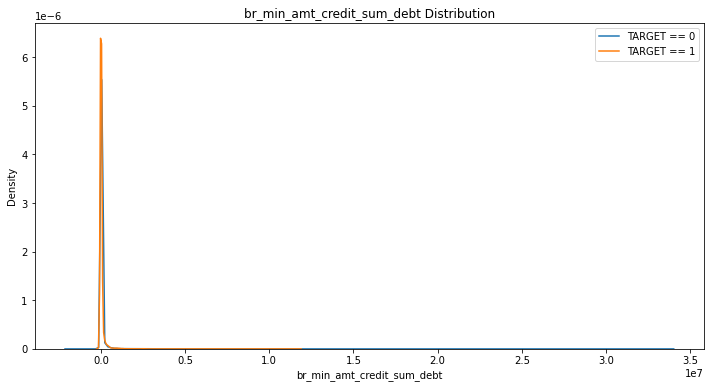

In [708]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [709]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [710]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [711]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [712]:
app_train['br_min_amt_credit_sum_debt'].isnull().sum()

215579

In [713]:
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.00000                    -0.00119
br_min_amt_credit_sum_debt -0.00119                     1.00000

In [714]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

In [715]:
## 標準化
#num_cols = ['br_min_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum_debt', 'TARGET']].corr()

In [716]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum_debt', app_train)

In [717]:
columns = ['br_min_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)


### br_max_amt_credit_sum_debt

In [718]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.000000                    0.000979
br_max_amt_credit_sum_debt  0.000979                    1.000000

In [719]:
app_train['br_max_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0010
Median value for loan that was not repaid = 216611.7750
Median value for loan that was repaid =     155250.0000


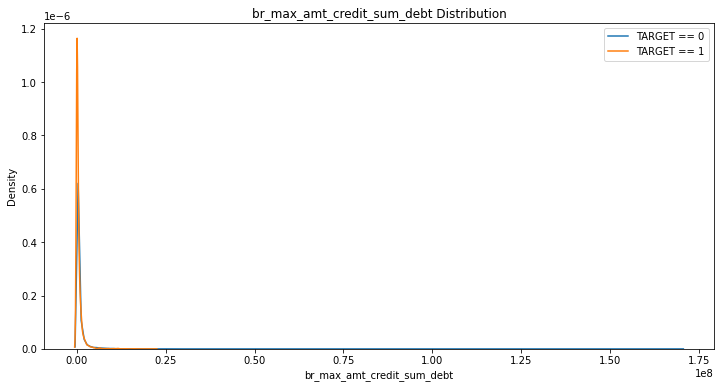

In [720]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

In [721]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [722]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [723]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [724]:
#app_train['br_max_amt_credit_sum_debt'].isnull().sum()

In [725]:
#app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

In [726]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

In [727]:
## 標準化
#num_cols = ['br_max_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_sum_debt', 'TARGET']].corr()

In [728]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum_debt', app_train)

In [729]:
columns = ['br_max_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_sum_debt

In [730]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                   -0.005482
br_sum_amt_credit_sum_debt -0.005482                    1.000000

In [731]:
app_train['br_sum_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_sum_amt_credit_sum_debt and the TARGET is -0.0055
Median value for loan that was not repaid = 2844288.0000
Median value for loan that was repaid =     2086762.5000


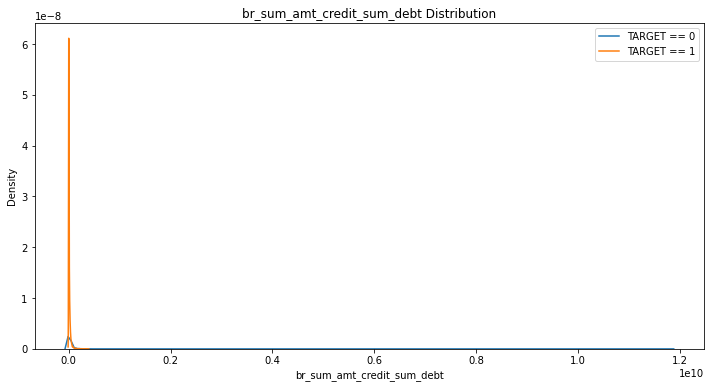

In [732]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [733]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [734]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [735]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [736]:
#app_train['br_sum_amt_credit_sum_debt'].isnull().sum()

In [737]:
#app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

In [738]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

In [739]:
## 標準化
#num_cols = ['br_sum_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_sum_debt', 'TARGET']].corr()

In [740]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_debt', app_train)

In [741]:
app_train.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)

### br_avg_amt_credit_sum_debt

In [742]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.000000                   -0.000757
br_avg_amt_credit_sum_debt -0.000757                    1.000000

In [743]:
app_train['br_avg_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_avg_amt_credit_sum_debt and the TARGET is -0.0008
Median value for loan that was not repaid = 48532.1250
Median value for loan that was repaid =     28857.4054


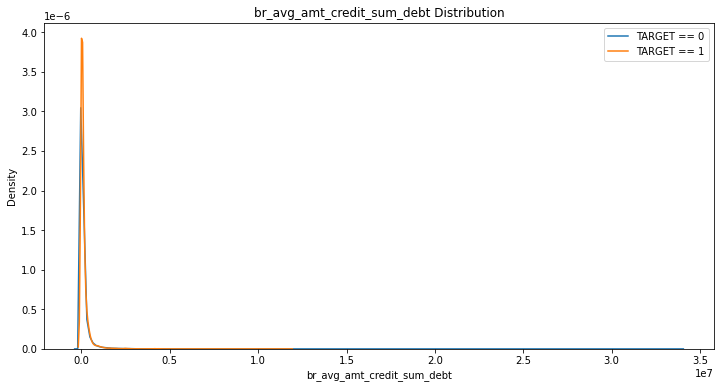

In [744]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [745]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [746]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [747]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [748]:
#app_train['br_avg_amt_credit_sum_debt'].isnull().sum()

In [749]:
#app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

In [750]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

In [751]:
## 標準化
#num_cols = ['br_avg_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_credit_sum_debt', 'TARGET']].corr()

In [752]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_debt', app_train)

In [753]:
app_train.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)

### br_cnt_amt_credit_sum_debt

In [754]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.00000                    -0.03538
br_cnt_amt_credit_sum_debt -0.03538                     1.00000

In [755]:
app_train['br_cnt_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0354
Median value for loan that was not repaid = 67.0000
Median value for loan that was repaid =     83.0000


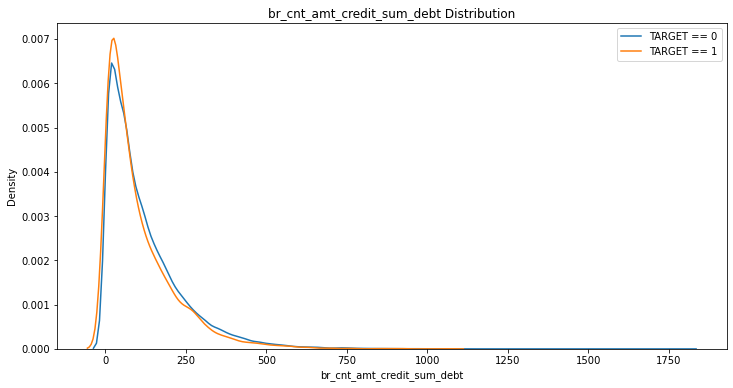

In [756]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

In [757]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_debt')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum_debt  
0  52.715068                  172.000000  
1  49.490411                   21.000000  
2  54.898630                   40.000000  
3  38.290411                  454.000000  
4  35.726027                  171.200554  

[5 rows x 92 columns]

In [758]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [759]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [760]:
app_train['br_cnt_amt_credit_sum_debt'].isnull().sum()

0

In [761]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.042451
br_cnt_amt_credit_sum_debt -0.042451                    1.000000

In [762]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.051836
br_cnt_amt_credit_sum_debt -0.051836                    1.000000

In [763]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_debt']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_debt', 'TARGET']].corr()

br_cnt_amt_credit_sum_debt    TARGET
br_cnt_amt_credit_sum_debt                    1.000000 -0.051836
TARGET                                       -0.051836  1.000000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0518
Median value for loan that was not repaid = -0.1083
Median value for loan that was repaid =     0.0654


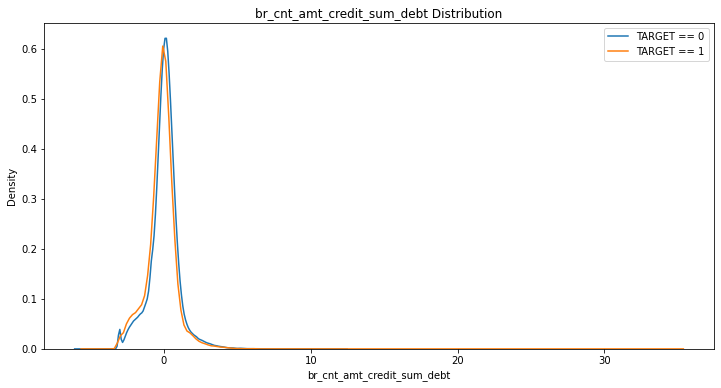

In [764]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

### br_stddev_amt_credit_sum_debt

In [765]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                      -0.000183
br_stddev_amt_credit_sum_debt -0.000183                       1.000000

In [766]:
app_train['br_stddev_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is -0.0002
Median value for loan that was not repaid = 57095.1592
Median value for loan that was repaid =     38260.2170


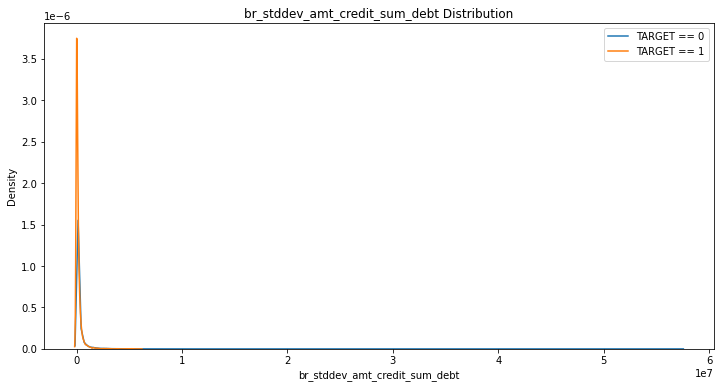

In [767]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [768]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [769]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [770]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [771]:
#app_train['br_stddev_amt_credit_sum_debt'].isnull().sum()

In [772]:
#app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

In [773]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

In [774]:
## 標準化
#num_cols = ['br_stddev_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_sum_debt', 'TARGET']].corr()

In [775]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [776]:
columns = ['br_stddev_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_sum_debt

In [777]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

TARGET  br_stddev_pop_amt_credit_sum_debt
TARGET                             1.000000                          -0.000183
br_stddev_pop_amt_credit_sum_debt -0.000183                           1.000000

In [778]:
app_train['br_stddev_pop_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_stddev_pop_amt_credit_sum_debt and the TARGET is -0.0002
Median value for loan that was not repaid = 57095.1592
Median value for loan that was repaid =     38260.2170


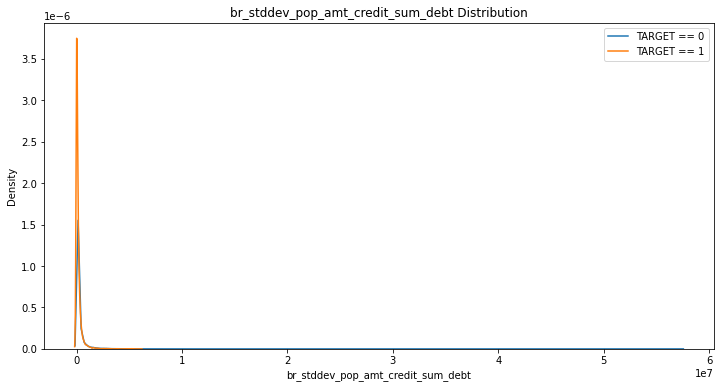

In [779]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [780]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [781]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [782]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [783]:
#app_train['br_stddev_pop_amt_credit_sum_debt'].isnull().sum()

In [784]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

In [785]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

In [786]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [787]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [788]:
columns = ['br_stddev_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum_debt

In [789]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.00000                        -0.00215
br_var_pop_amt_credit_sum_debt -0.00215                         1.00000

In [790]:
app_train['br_var_pop_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is -0.0021
Median value for loan that was not repaid = 3259857204.4701
Median value for loan that was repaid =     1463844202.8261


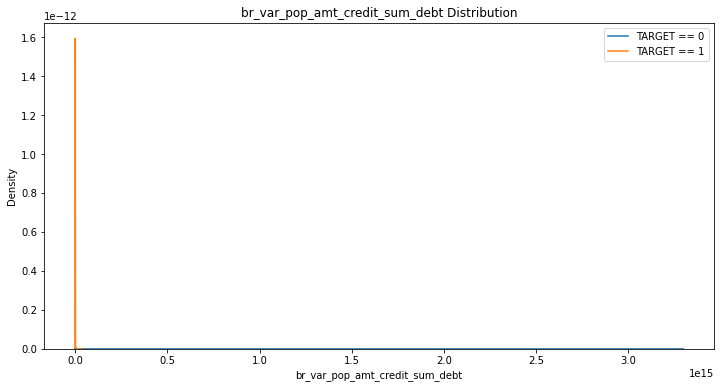

In [791]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [792]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [793]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [794]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [795]:
#app_train['br_var_pop_amt_credit_sum_debt'].isnull().sum()

In [796]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

In [797]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

In [798]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [799]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [800]:
columns = ['br_var_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum_debt

In [801]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                        -0.002157
br_var_samp_amt_credit_sum_debt -0.002157                         1.000000

In [802]:
app_train['br_var_samp_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is -0.0022
Median value for loan that was not repaid = 3334031791.3840
Median value for loan that was repaid =     1492970065.0713


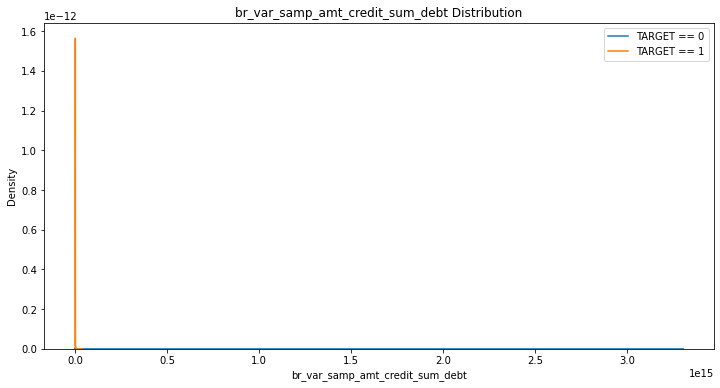

In [803]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [804]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [805]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [806]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [807]:
#app_train['br_var_samp_amt_credit_sum_debt'].isnull().sum()

In [808]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

In [809]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

In [810]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum_debt', 'TARGET']].corr()

In [811]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [812]:
columns = ['br_var_samp_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum_debt

In [813]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.00000   
br_variance_pop_amt_credit_sum_debt -0.00215   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                          -0.00215  
br_variance_pop_amt_credit_sum_debt                              1.00000

In [814]:
app_train['br_variance_pop_amt_credit_sum_debt'].isnull().sum()

215579

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is -0.0021
Median value for loan that was not repaid = 3259857204.4701
Median value for loan that was repaid =     1463844202.8261


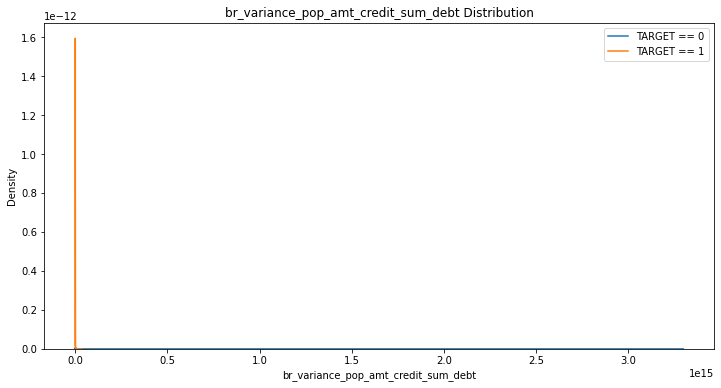

In [815]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [816]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [817]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [818]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [819]:
#app_train['br_variance_pop_amt_credit_sum_debt'].isnull().sum()

In [820]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

In [821]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

In [822]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [823]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [824]:
columns = ['br_variance_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_amt_credit_sum_limit

In [825]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.000000                    -0.005803
br_min_amt_credit_sum_limit -0.005803                     1.000000

In [826]:
app_train['br_min_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0058
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


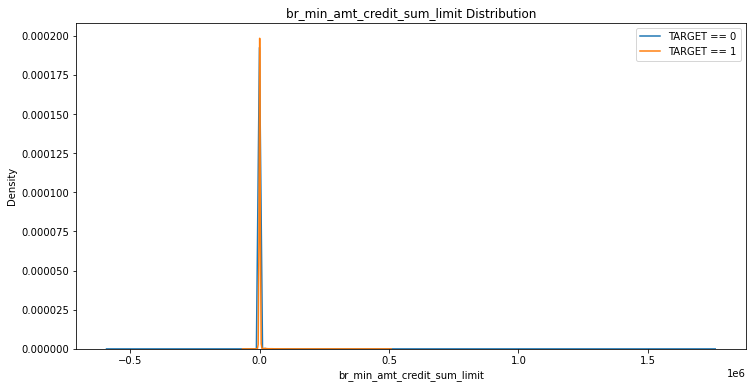

In [827]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [828]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [829]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [830]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [831]:
#app_train['br_min_amt_credit_sum_limit'].isnull().sum()

In [832]:
#app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

In [833]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

In [834]:
## 標準化
#num_cols = ['br_min_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum_limit', 'TARGET']].corr()

In [835]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum_limit', app_train)

In [836]:
columns = ['br_min_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_sum_limit

In [837]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.00000                     -0.01289
br_max_amt_credit_sum_limit -0.01289                      1.00000

In [838]:
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.00000                     -0.01289
br_max_amt_credit_sum_limit -0.01289                      1.00000

The correlation between br_max_amt_credit_sum_limit and the TARGET is -0.0129
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


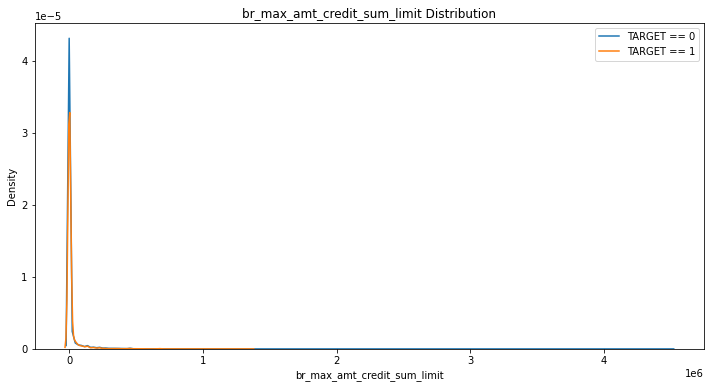

In [839]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

In [840]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_amt_credit_sum_limit  
0  52.715068                     0.000000  
1  49.490411                     0.000000  
2  54.898630                     0.000000  
3  38.290411                101390.760000  
4  35.726027                 19117.509747  

[5 rows x 92 columns]

In [841]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [842]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [843]:
app_train['br_max_amt_credit_sum_limit'].isnull().sum()

0

In [844]:
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.011259
br_max_amt_credit_sum_limit -0.011259                     1.000000

In [845]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.014548
br_max_amt_credit_sum_limit -0.014548                     1.000000

In [846]:
## 標準化
num_cols = ['br_max_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_amt_credit_sum_limit', 'TARGET']].corr()

br_max_amt_credit_sum_limit    TARGET
br_max_amt_credit_sum_limit                     1.000000 -0.014548
TARGET                                         -0.014548  1.000000

The correlation between br_max_amt_credit_sum_limit and the TARGET is -0.0145
Median value for loan that was not repaid = 0.0386
Median value for loan that was repaid =     0.0783


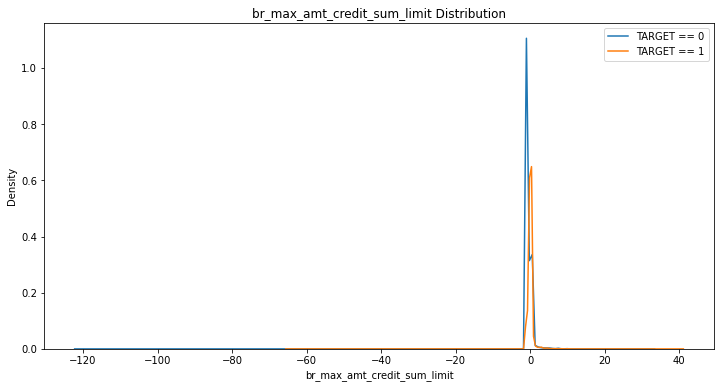

In [847]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

### br_sum_amt_credit_sum_limit

In [848]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.015135
br_sum_amt_credit_sum_limit -0.015135                     1.000000

In [849]:
app_train['br_sum_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_sum_amt_credit_sum_limit and the TARGET is -0.0151
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


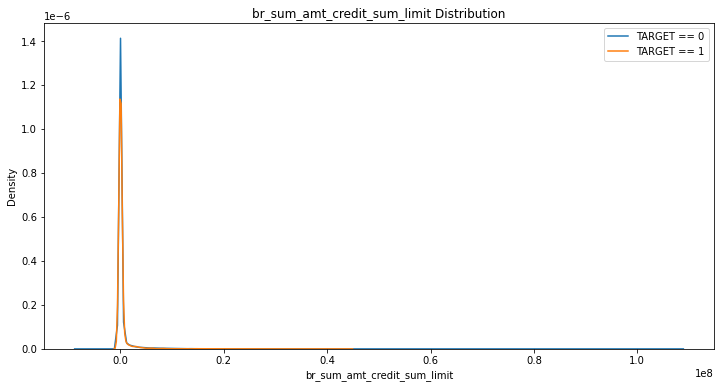

In [850]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

In [851]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_amt_credit_sum_limit  
0  52.715068                     0.000000  
1  49.490411                     0.000000  
2  54.898630                     0.000000  
3  38.290411                912516.840000  
4  35.726027                529900.052979  

[5 rows x 92 columns]

In [852]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [853]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [854]:
app_train['br_sum_amt_credit_sum_limit'].isnull().sum()

0

In [855]:
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.013672
br_sum_amt_credit_sum_limit -0.013672                     1.000000

In [856]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.015471
br_sum_amt_credit_sum_limit -0.015471                     1.000000

In [857]:
## 標準化
num_cols = ['br_sum_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_amt_credit_sum_limit', 'TARGET']].corr()

br_sum_amt_credit_sum_limit    TARGET
br_sum_amt_credit_sum_limit                     1.000000 -0.015471
TARGET                                         -0.015471  1.000000

The correlation between br_sum_amt_credit_sum_limit and the TARGET is -0.0155
Median value for loan that was not repaid = -0.0944
Median value for loan that was repaid =     -0.0560


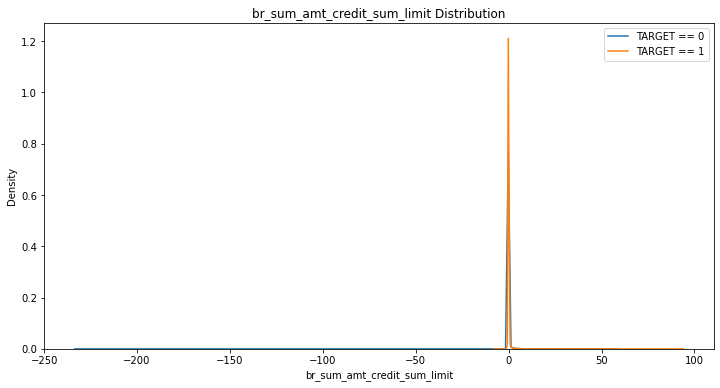

In [858]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

### br_avg_amt_credit_sum_limit

In [859]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

TARGET  br_avg_amt_credit_sum_limit
TARGET                       1.000000                    -0.011125
br_avg_amt_credit_sum_limit -0.011125                     1.000000

In [860]:
app_train['br_avg_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_avg_amt_credit_sum_limit and the TARGET is -0.0111
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


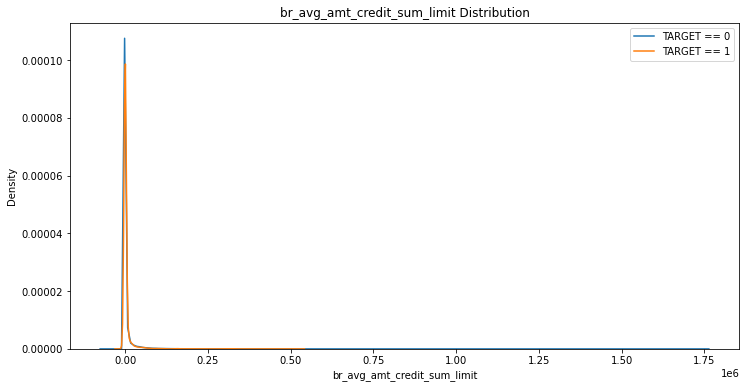

In [861]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_limit', app_train)

In [862]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [863]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [864]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [865]:
#app_train['br_avg_amt_credit_sum_limit'].isnull().sum()

In [866]:
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [867]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [868]:
## 標準化
#num_cols = ['br_avg_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_credit_sum_limit', 'TARGET']].corr()

In [869]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_limit', app_train)

In [870]:
columns = ['br_avg_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_amt_credit_sum_limit

In [871]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.033391
br_cnt_amt_credit_sum_limit -0.033391                     1.000000

In [872]:
app_train['br_cnt_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0334
Median value for loan that was not repaid = 48.0000
Median value for loan that was repaid =     60.0000


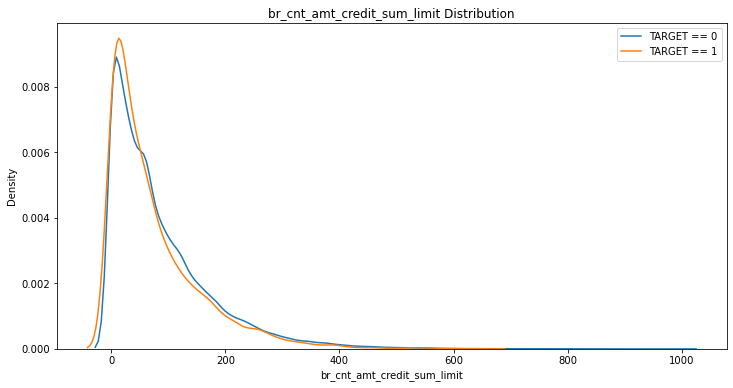

In [873]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

In [874]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum_limit  
0  52.715068                   161.000000  
1  49.490411                    21.000000  
2  54.898630                     0.000000  
3  38.290411                   299.000000  
4  35.726027                   109.542676  

[5 rows x 92 columns]

In [875]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [876]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [877]:
app_train['br_cnt_amt_credit_sum_limit'].isnull().sum()

0

In [878]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.039786
br_cnt_amt_credit_sum_limit -0.039786                     1.000000

In [879]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.045896
br_cnt_amt_credit_sum_limit -0.045896                     1.000000

In [880]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_limit', 'TARGET']].corr()

br_cnt_amt_credit_sum_limit    TARGET
br_cnt_amt_credit_sum_limit                     1.000000 -0.045896
TARGET                                         -0.045896  1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0459
Median value for loan that was not repaid = -0.0837
Median value for loan that was repaid =     0.0715


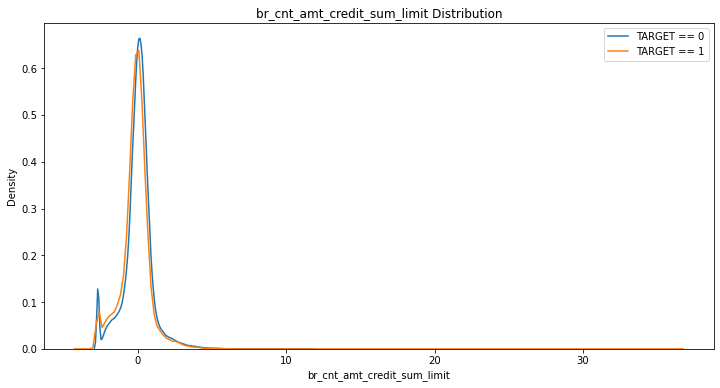

In [881]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

### br_stddev_amt_credit_sum_limit

In [882]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.000000                       -0.011589
br_stddev_amt_credit_sum_limit -0.011589                        1.000000

In [883]:
app_train['br_stddev_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


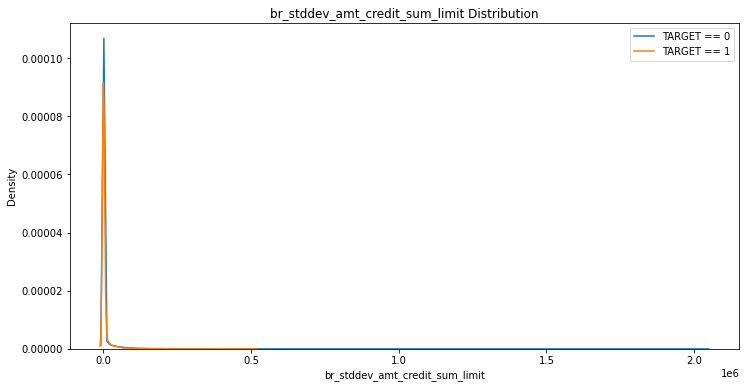

In [884]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [885]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [886]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [887]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [888]:
#app_train['br_stddev_amt_credit_sum_limit'].isnull().sum()

In [889]:
#app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

In [890]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

In [891]:
## 標準化
#num_cols = ['br_stddev_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_sum_limit', 'TARGET']].corr()

In [892]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [893]:
columns = ['br_stddev_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_sum_limit

In [894]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.000000   
br_stddev_pop_amt_credit_sum_limit -0.011589   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                       -0.011589  
br_stddev_pop_amt_credit_sum_limit                            1.000000

In [895]:
app_train['br_stddev_pop_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


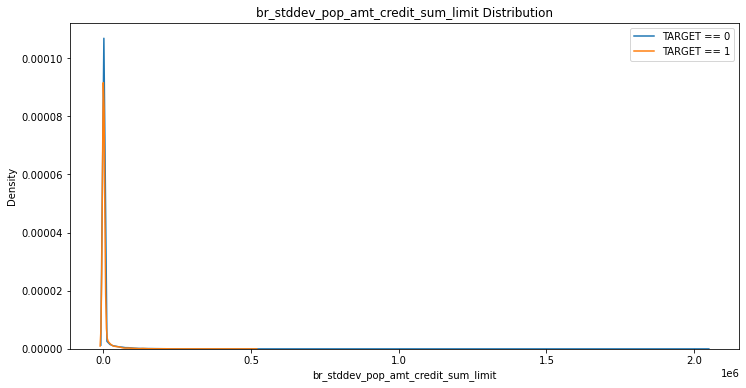

In [896]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [897]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [898]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [899]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [900]:
#app_train['br_stddev_pop_amt_credit_sum_limit'].isnull().sum()

In [901]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

In [902]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

In [903]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum_limit', 'TARGET']].corr()

In [904]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [905]:
columns = ['br_stddev_pop_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum_limit

In [906]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.004928
br_var_pop_amt_credit_sum_limit -0.004928                         1.000000

In [907]:
app_train['br_var_pop_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


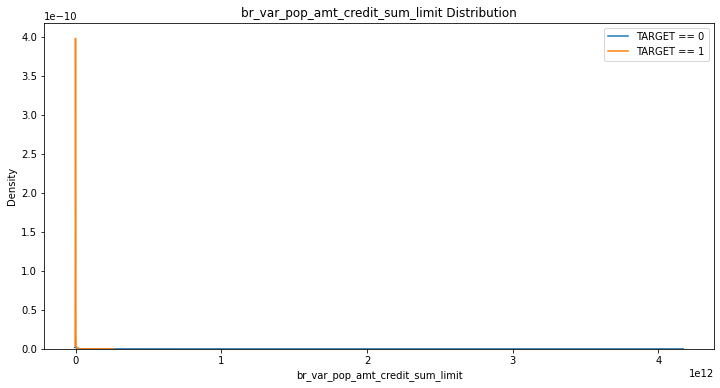

In [908]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

In [909]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_amt_credit_sum_limit  
0  52.715068                     0.000000e+00  
1  49.490411                     0.000000e+00  
2  54.898630                     0.000000e+00  
3  38.290411                     3.001200e+08  
4  35.726027                     7.279814e+08  

[5 rows x 92 columns]

In [910]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [911]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [912]:
app_train['br_var_pop_amt_credit_sum_limit'].isnull().sum()

0

In [913]:
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.004145
br_var_pop_amt_credit_sum_limit -0.004145                         1.000000

In [914]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.013809
br_var_pop_amt_credit_sum_limit -0.013809                         1.000000

In [915]:
## 標準化
num_cols = ['br_var_pop_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_amt_credit_sum_limit', 'TARGET']].corr()

br_var_pop_amt_credit_sum_limit    TARGET
br_var_pop_amt_credit_sum_limit                         1.000000 -0.013809
TARGET                                                 -0.013809  1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is -0.0138
Median value for loan that was not repaid = 0.0741
Median value for loan that was repaid =     0.0860


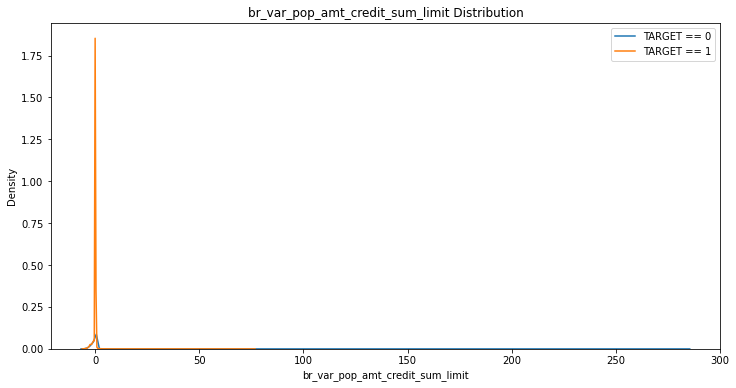

In [916]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

### br_var_samp_amt_credit_sum_limit

In [917]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.004898
br_var_samp_amt_credit_sum_limit -0.004898                          1.000000

In [918]:
app_train['br_var_samp_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


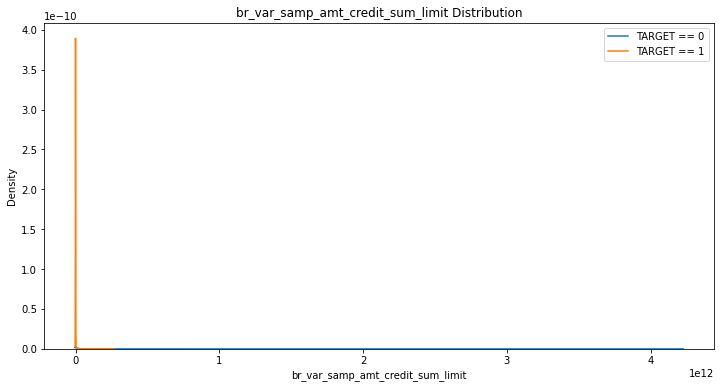

In [919]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

In [920]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_amt_credit_sum_limit  
0  52.715068                      0.000000e+00  
1  49.490411                      0.000000e+00  
2  54.898630                      0.000000e+00  
3  38.290411                      3.011271e+08  
4  35.726027                      7.369947e+08  

[5 rows x 92 columns]

In [921]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [922]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [923]:
app_train['br_var_samp_amt_credit_sum_limit'].isnull().sum()

0

In [924]:
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.004124
br_var_samp_amt_credit_sum_limit -0.004124                          1.000000

In [925]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.013728
br_var_samp_amt_credit_sum_limit -0.013728                          1.000000

In [926]:
## 標準化
num_cols = ['br_var_samp_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_amt_credit_sum_limit', 'TARGET']].corr()

br_var_samp_amt_credit_sum_limit    TARGET
br_var_samp_amt_credit_sum_limit                          1.000000 -0.013728
TARGET                                                   -0.013728  1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is -0.0137
Median value for loan that was not repaid = 0.0741
Median value for loan that was repaid =     0.0859


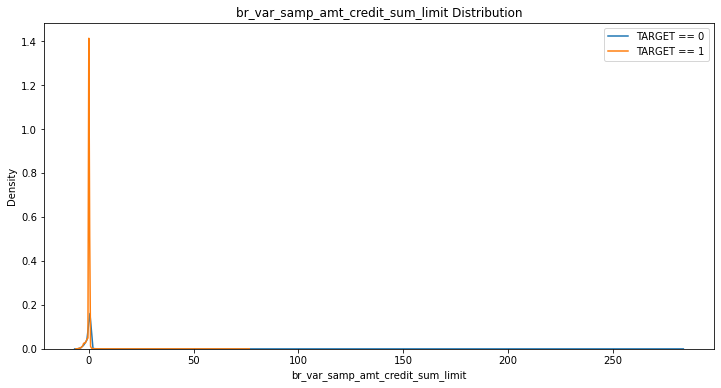

In [927]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

### br_variance_pop_amt_credit_sum_limit

In [928]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.004928   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.004928  
br_variance_pop_amt_credit_sum_limit                              1.000000

In [929]:
app_train['br_variance_pop_amt_credit_sum_limit'].isnull().sum()

215579

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


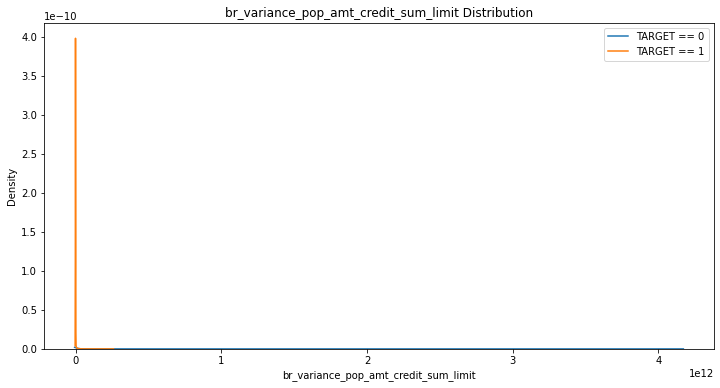

In [930]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

In [931]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_amt_credit_sum_limit  
0  52.715068                          0.000000e+00  
1  49.490411                          0.000000e+00  
2  54.898630                          0.000000e+00  
3  38.290411                          3.001200e+08  
4  35.726027                          7.279814e+08  

[5 rows x 92 columns]

In [932]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [933]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [934]:
app_train['br_variance_pop_amt_credit_sum_limit'].isnull().sum()

0

In [935]:
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.004145   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.004145  
br_variance_pop_amt_credit_sum_limit                              1.000000

In [936]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.013809   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.013809  
br_variance_pop_amt_credit_sum_limit                              1.000000

In [937]:
## 標準化
num_cols = ['br_variance_pop_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_amt_credit_sum_limit', 'TARGET']].corr()

br_variance_pop_amt_credit_sum_limit  \
br_variance_pop_amt_credit_sum_limit                              1.000000   
TARGET                                                           -0.013809   

                                        TARGET  
br_variance_pop_amt_credit_sum_limit -0.013809  
TARGET                                1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is -0.0138
Median value for loan that was not repaid = 0.0741
Median value for loan that was repaid =     0.0860


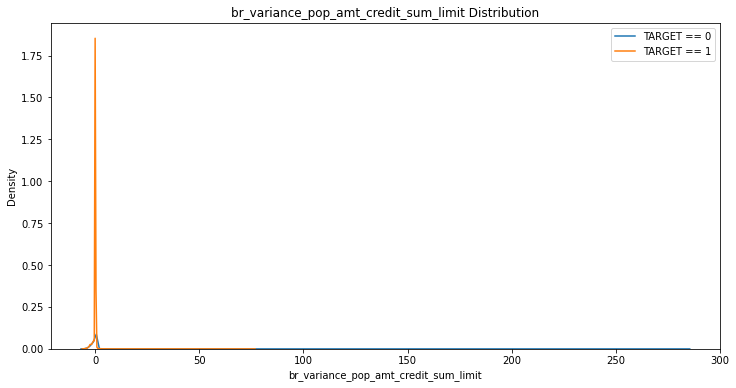

In [938]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

### br_min_amt_credit_sum_overdue

In [939]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                      -0.000443
br_min_amt_credit_sum_overdue -0.000443                       1.000000

In [940]:
app_train['br_min_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_min_amt_credit_sum_overdue and the TARGET is -0.0004
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


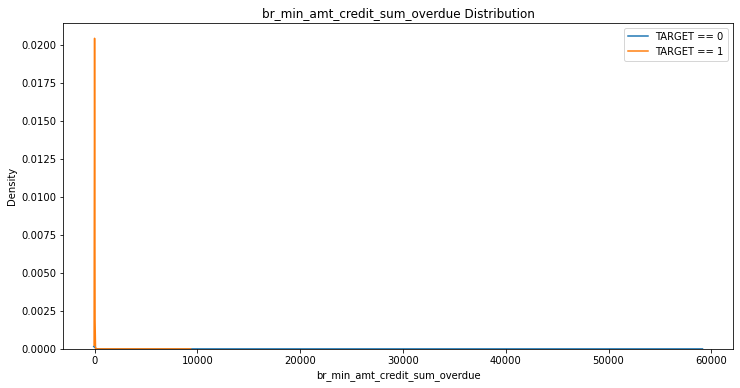

In [941]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [942]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_amt_credit_sum_overdue  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                       0.000000  
3  38.290411                       0.000000  
4  35.726027                      -0.855456  

[5 rows x 92 columns]

In [943]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [944]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [945]:
app_train['br_min_amt_credit_sum_overdue'].isnull().sum()

0

In [946]:
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                       0.000951
br_min_amt_credit_sum_overdue  0.000951                       1.000000

In [947]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                       0.020866
br_min_amt_credit_sum_overdue  0.020866                       1.000000

In [948]:
## 標準化
num_cols = ['br_min_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_amt_credit_sum_overdue', 'TARGET']].corr()

br_min_amt_credit_sum_overdue    TARGET
br_min_amt_credit_sum_overdue                       1.000000  0.020866
TARGET                                              0.020866  1.000000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is 0.0209
Median value for loan that was not repaid = 0.0354
Median value for loan that was repaid =     -0.0895


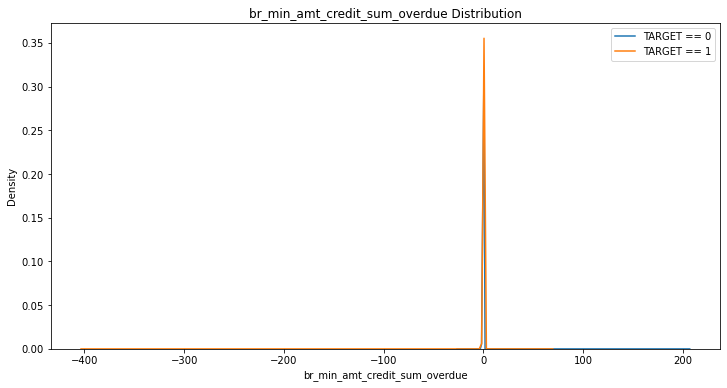

In [949]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

### br_max_amt_credit_sum_overdue

In [950]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.018012
br_max_amt_credit_sum_overdue  0.018012                       1.000000

In [951]:
app_train['br_max_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0180
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


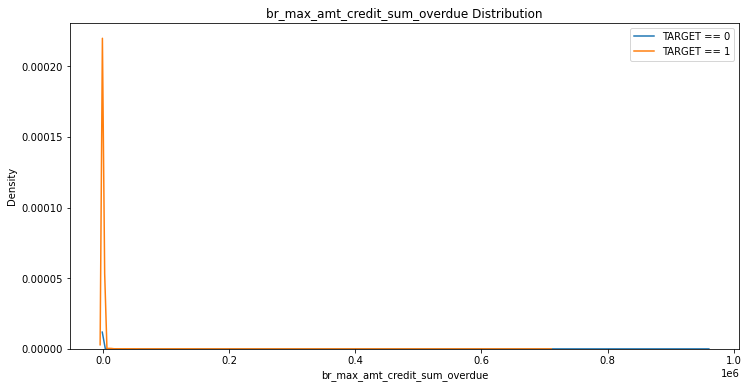

In [952]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

In [953]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_amt_credit_sum_overdue  
0  52.715068                        0.00000  
1  49.490411                        0.00000  
2  54.898630                        0.00000  
3  38.290411                        0.00000  
4  35.726027                       64.67556  

[5 rows x 92 columns]

In [954]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [955]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [956]:
app_train['br_max_amt_credit_sum_overdue'].isnull().sum()

0

In [957]:
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.010605
br_max_amt_credit_sum_overdue  0.010605                       1.000000

In [958]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.028437
br_max_amt_credit_sum_overdue  0.028437                       1.000000

In [959]:
## 標準化
num_cols = ['br_max_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_amt_credit_sum_overdue', 'TARGET']].corr()

br_max_amt_credit_sum_overdue    TARGET
br_max_amt_credit_sum_overdue                       1.000000  0.028437
TARGET                                              0.028437  1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0284
Median value for loan that was not repaid = 0.1775
Median value for loan that was repaid =     0.1297


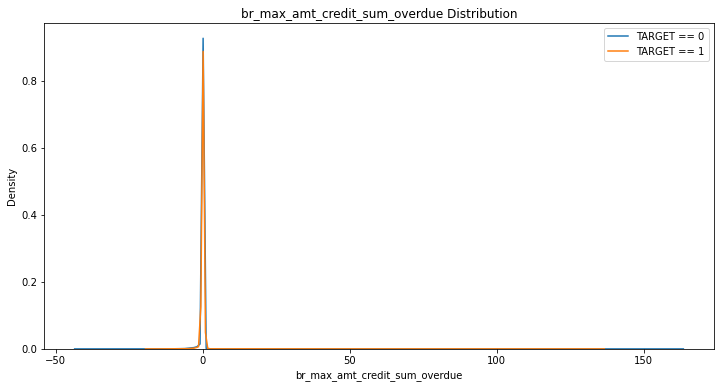

In [960]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

### br_sum_amt_credit_sum_overdue

In [961]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.006955
br_sum_amt_credit_sum_overdue  0.006955                       1.000000

In [962]:
app_train['br_sum_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0070
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


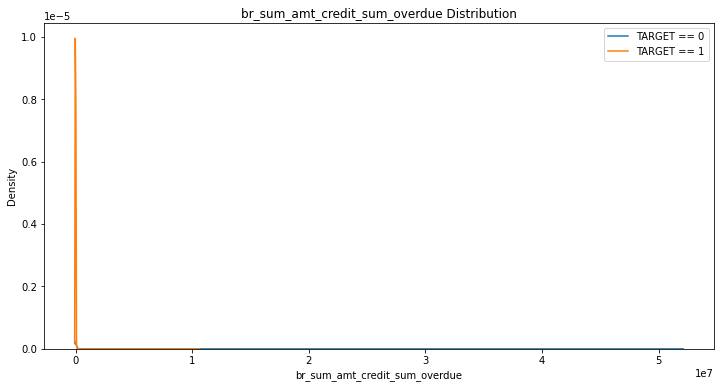

In [963]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [964]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [965]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [966]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [967]:
#app_train['br_sum_amt_credit_sum_overdue'].isnull().sum()

In [968]:
#app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

In [969]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

In [970]:
## 標準化
#num_cols = ['br_sum_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_sum_overdue', 'TARGET']].corr()

In [971]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [972]:
columns = ['br_sum_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_credit_sum_overdue

In [973]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.018425
br_avg_amt_credit_sum_overdue  0.018425                       1.000000

In [974]:
app_train['br_avg_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0184
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


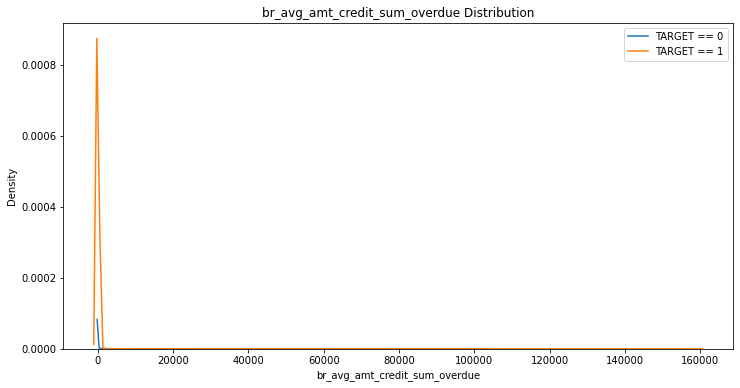

In [975]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

In [976]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_amt_credit_sum_overdue  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                       0.000000  
3  38.290411                       0.000000  
4  35.726027                      21.355551  

[5 rows x 92 columns]

In [977]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [978]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [979]:
app_train['br_avg_amt_credit_sum_overdue'].isnull().sum()

0

In [980]:
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.011193
br_avg_amt_credit_sum_overdue  0.011193                       1.000000

In [981]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.023856
br_avg_amt_credit_sum_overdue  0.023856                       1.000000

In [982]:
## 標準化
num_cols = ['br_avg_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_sum_overdue', 'TARGET']].corr()

br_avg_amt_credit_sum_overdue    TARGET
br_avg_amt_credit_sum_overdue                       1.000000  0.023856
TARGET                                              0.023856  1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0239
Median value for loan that was not repaid = 0.1154
Median value for loan that was repaid =     0.0393


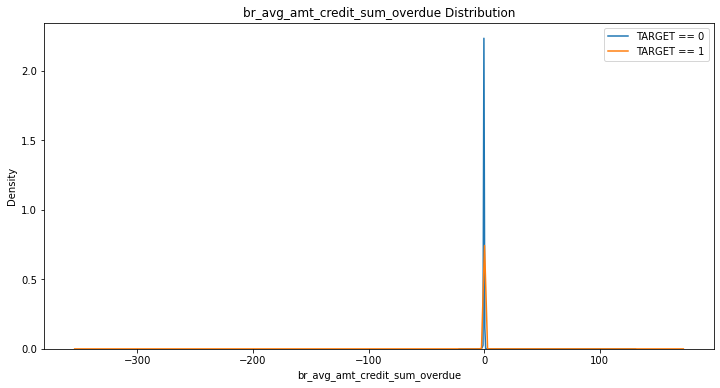

In [983]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

### br_cnt_amt_credit_sum_overdue

In [984]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.040412
br_cnt_amt_credit_sum_overdue -0.040412                       1.000000

In [985]:
app_train['br_cnt_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


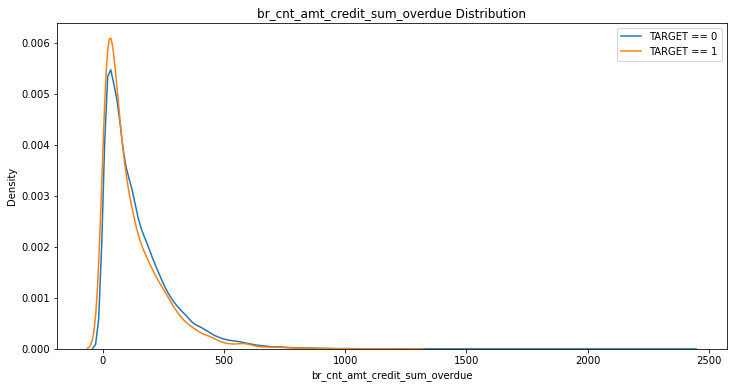

In [986]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

In [987]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum_overdue  
0  52.715068                     172.000000  
1  49.490411                      21.000000  
2  54.898630                     217.000000  
3  38.290411                     536.000000  
4  35.726027                     192.700818  

[5 rows x 92 columns]

In [988]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [989]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [990]:
app_train['br_cnt_amt_credit_sum_overdue'].isnull().sum()

0

In [991]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.048315
br_cnt_amt_credit_sum_overdue -0.048315                       1.000000

In [992]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.061147
br_cnt_amt_credit_sum_overdue -0.061147                       1.000000

In [993]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_overdue', 'TARGET']].corr()

br_cnt_amt_credit_sum_overdue    TARGET
br_cnt_amt_credit_sum_overdue                       1.000000 -0.061147
TARGET                                             -0.061147  1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


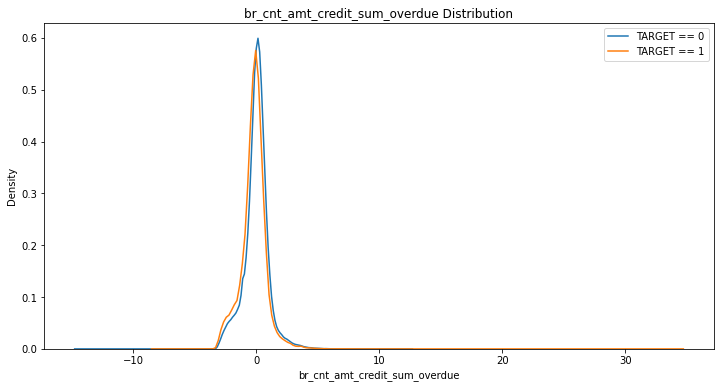

In [994]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

### br_stddev_amt_credit_sum_overdue

In [995]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.00000                           0.01918
br_stddev_amt_credit_sum_overdue  0.01918                           1.00000

In [996]:
app_train['br_stddev_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0192
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


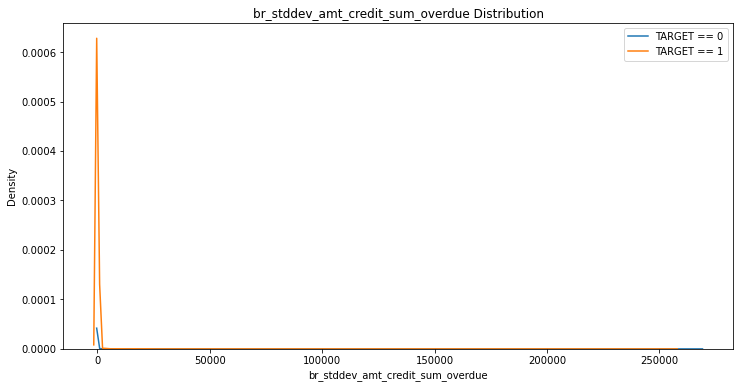

In [997]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

In [998]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_amt_credit_sum_overdue  
0  52.715068                          0.000000  
1  49.490411                          0.000000  
2  54.898630                          0.000000  
3  38.290411                          0.000000  
4  35.726027                         15.704169  

[5 rows x 92 columns]

In [999]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1000]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1001]:
app_train['br_stddev_amt_credit_sum_overdue'].isnull().sum()

0

In [1002]:
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.011309
br_stddev_amt_credit_sum_overdue  0.011309                          1.000000

In [1003]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.033967
br_stddev_amt_credit_sum_overdue  0.033967                          1.000000

In [1004]:
## 標準化
num_cols = ['br_stddev_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_amt_credit_sum_overdue', 'TARGET']].corr()

br_stddev_amt_credit_sum_overdue    TARGET
br_stddev_amt_credit_sum_overdue                          1.000000  0.033967
TARGET                                                    0.033967  1.000000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0340
Median value for loan that was not repaid = 0.2196
Median value for loan that was repaid =     0.1456


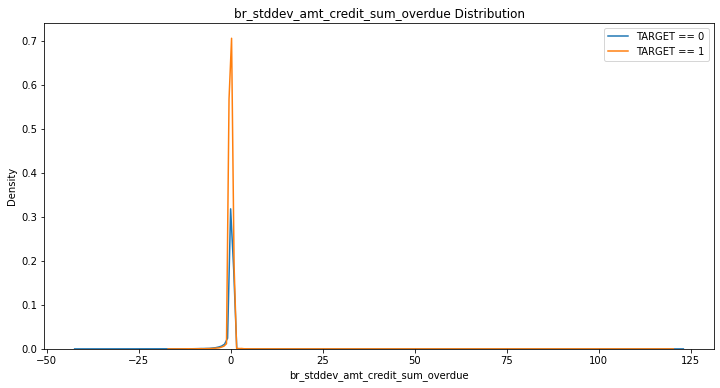

In [1005]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

### br_stddev_pop_amt_credit_sum_overdue

In [1006]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.00000   
br_stddev_pop_amt_credit_sum_overdue  0.01918   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                             0.01918  
br_stddev_pop_amt_credit_sum_overdue                               1.00000

In [1007]:
app_train['br_stddev_pop_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0192
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


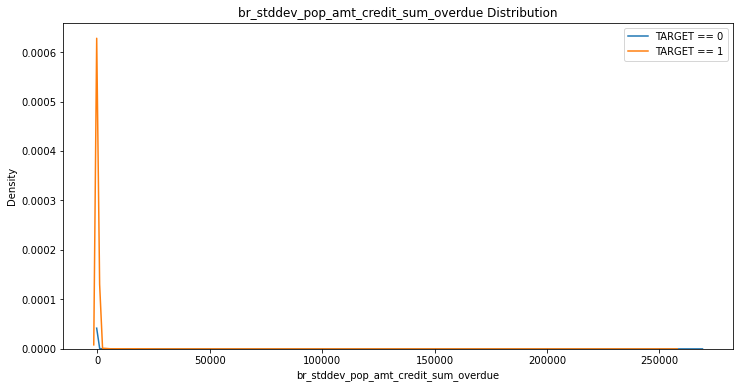

In [1008]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

In [1009]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_amt_credit_sum_overdue  
0  52.715068                              0.000000  
1  49.490411                              0.000000  
2  54.898630                              0.000000  
3  38.290411                              0.000000  
4  35.726027                             15.704169  

[5 rows x 92 columns]

In [1010]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1011]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1012]:
app_train['br_stddev_pop_amt_credit_sum_overdue'].isnull().sum()

0

In [1013]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.011309   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.011309  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

In [1014]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.033967   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.033967  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

In [1015]:
## 標準化
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_amt_credit_sum_overdue', 'TARGET']].corr()

br_stddev_pop_amt_credit_sum_overdue  \
br_stddev_pop_amt_credit_sum_overdue                              1.000000   
TARGET                                                            0.033967   

                                        TARGET  
br_stddev_pop_amt_credit_sum_overdue  0.033967  
TARGET                                1.000000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0340
Median value for loan that was not repaid = 0.2196
Median value for loan that was repaid =     0.1456


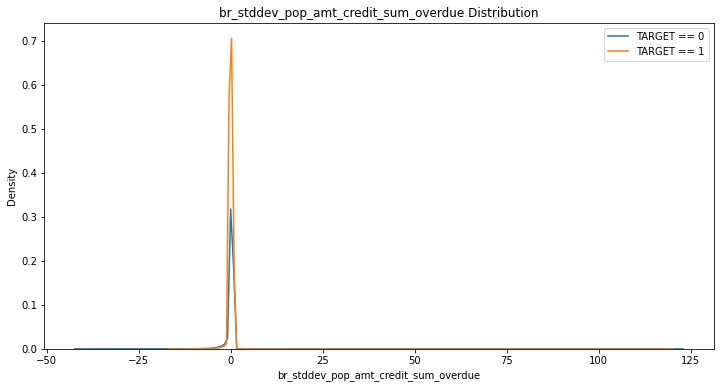

In [1016]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

### br_var_pop_amt_credit_sum_overdue

In [1017]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.007761
br_var_pop_amt_credit_sum_overdue  0.007761                           1.000000

In [1018]:
app_train['br_var_pop_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


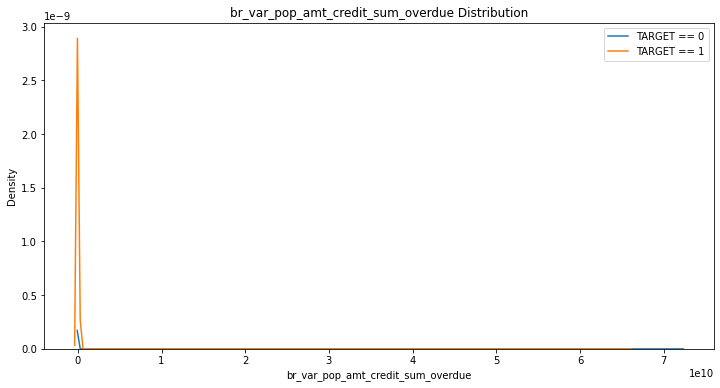

In [1019]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [1020]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1021]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1022]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1023]:
#app_train['br_var_pop_amt_credit_sum_overdue'].isnull().sum()

In [1024]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

In [1025]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.007761
br_var_pop_amt_credit_sum_overdue  0.007761                           1.000000

In [1026]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum_overdue', 'TARGET']].corr()

In [1027]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [1028]:
columns = ['br_var_pop_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum_overdue

In [1029]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_sum_overdue  0.007824   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                        0.007824  
br_var_samp_amt_credit_sum_overdue                            1.000000

In [1030]:
app_train['br_var_samp_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


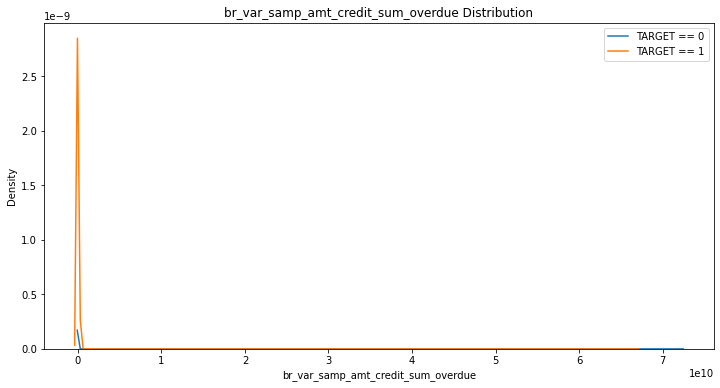

In [1031]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [1032]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1033]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1034]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1035]:
#app_train['br_var_samp_amt_credit_sum_overdue'].isnull().sum()

In [1036]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

In [1037]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

In [1038]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum_overdue', 'TARGET']].corr()

In [1039]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [1040]:
columns = ['br_var_samp_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum_overdue

In [1041]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_sum_overdue  0.007761   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                0.007761  
br_variance_pop_amt_credit_sum_overdue                                1.000000

In [1042]:
app_train['br_variance_pop_amt_credit_sum_overdue'].isnull().sum()

215579

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


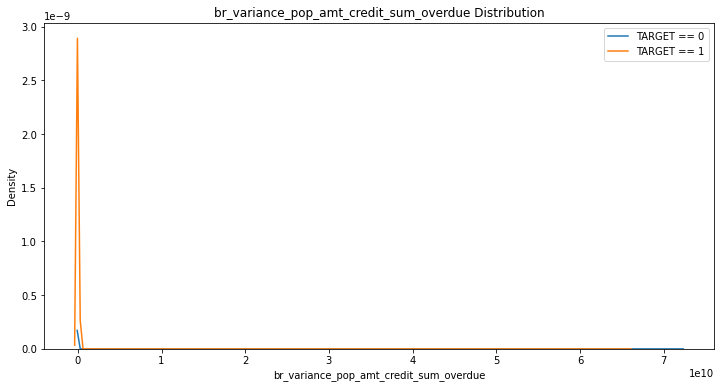

In [1043]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [1044]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1045]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1046]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1047]:
#app_train['br_variance_pop_amt_credit_sum_overdue'].isnull().sum()

In [1048]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

In [1049]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

In [1050]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_sum_overdue', 'TARGET']].corr()

In [1051]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [1052]:
columns = ['br_variance_pop_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_days_credit_update

In [1053]:
## 目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.051165
br_min_days_credit_update  0.051165                   1.000000

In [1054]:
app_train['br_min_days_credit_update'].isnull().sum()

215579

The correlation between br_min_days_credit_update and the TARGET is 0.0512
Median value for loan that was not repaid = -779.0000
Median value for loan that was repaid =     -971.0000


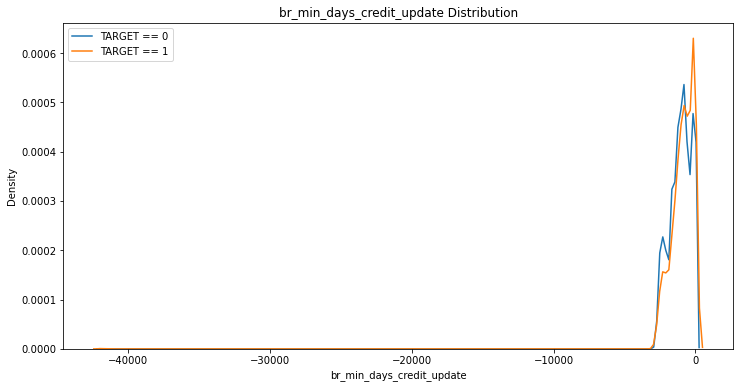

In [1055]:
## 特徴量の分布
kde_target('br_min_days_credit_update', app_train)

In [1056]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_days_credit_update  
0  52.715068                -155.000000  
1  49.490411                -121.000000  
2  54.898630               -1334.000000  
3  38.290411               -1564.000000  
4  35.726027               -1091.542884  

[5 rows x 92 columns]

In [1057]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1058]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1059]:
app_train['br_min_days_credit_update'].isnull().sum()

0

In [1060]:
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.072926
br_min_days_credit_update  0.072926                   1.000000

In [1061]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.081489
br_min_days_credit_update  0.081489                   1.000000

In [1062]:
## 標準化
num_cols = ['br_min_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_days_credit_update', 'TARGET']].corr()

br_min_days_credit_update    TARGET
br_min_days_credit_update                   1.000000  0.081489
TARGET                                      0.081489  1.000000

The correlation between br_min_days_credit_update and the TARGET is 0.0815
Median value for loan that was not repaid = 0.2036
Median value for loan that was repaid =     -0.1120


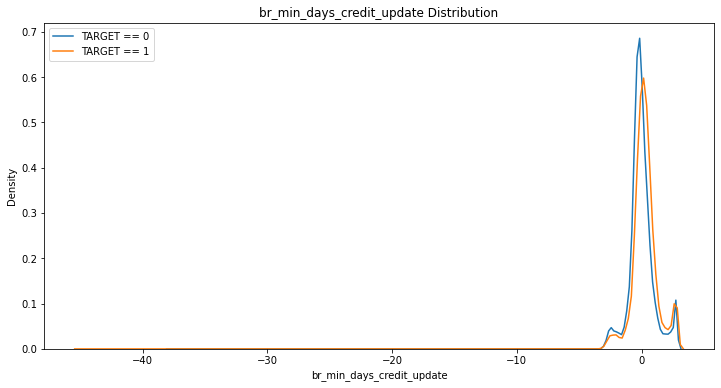

In [1063]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_update', app_train)

### br_max_days_credit_update

In [1064]:
## 目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.00000                    0.02751
br_max_days_credit_update  0.02751                    1.00000

In [1065]:
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.00000                    0.02751
br_max_days_credit_update  0.02751                    1.00000

The correlation between br_max_days_credit_update and the TARGET is 0.0275
Median value for loan that was not repaid = -13.0000
Median value for loan that was repaid =     -16.0000


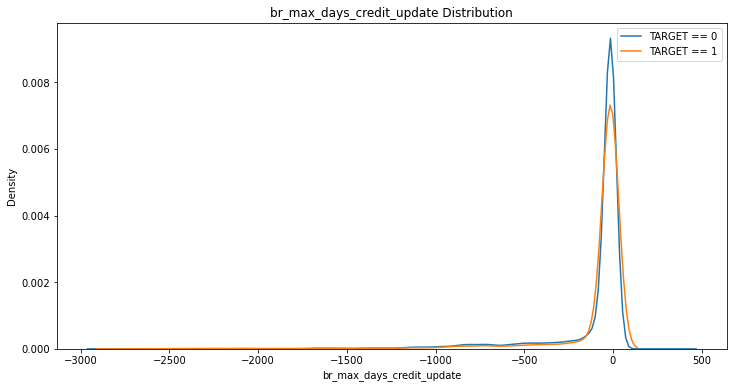

In [1066]:
## 特徴量の分布
kde_target('br_max_days_credit_update', app_train)

In [1067]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_days_credit_update  
0  52.715068                  -6.000000  
1  49.490411                 -11.000000  
2  54.898630                  -4.000000  
3  38.290411                 -20.000000  
4  35.726027                -120.828352  

[5 rows x 92 columns]

In [1068]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1069]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1070]:
app_train['br_max_days_credit_update'].isnull().sum()

0

In [1071]:
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.052624
br_max_days_credit_update  0.052624                   1.000000

In [1072]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.053831
br_max_days_credit_update  0.053831                   1.000000

In [1073]:
## 標準化
num_cols = ['br_max_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_credit_update', 'TARGET']].corr()

br_max_days_credit_update    TARGET
br_max_days_credit_update                   1.000000  0.053831
TARGET                                      0.053831  1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0538
Median value for loan that was not repaid = 0.2891
Median value for loan that was repaid =     0.0634


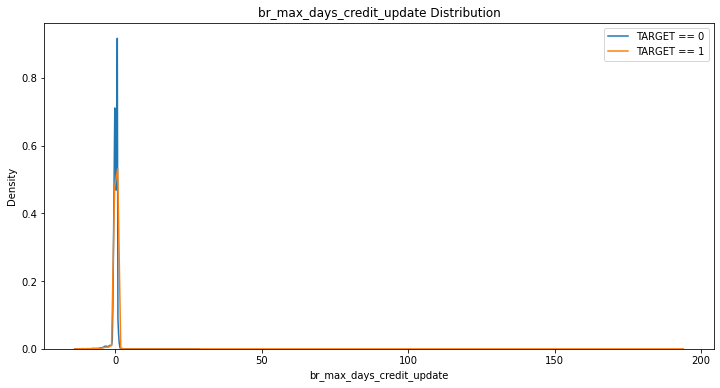

In [1074]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_update', app_train)

### br_sum_days_credit_update

In [1075]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.050243
br_sum_days_credit_update  0.050243                   1.000000

In [1076]:
app_train['br_sum_days_credit_update'].isnull().sum()

215579

The correlation between br_sum_days_credit_update and the TARGET is 0.0502
Median value for loan that was not repaid = -30879.0000
Median value for loan that was repaid =     -53714.0000


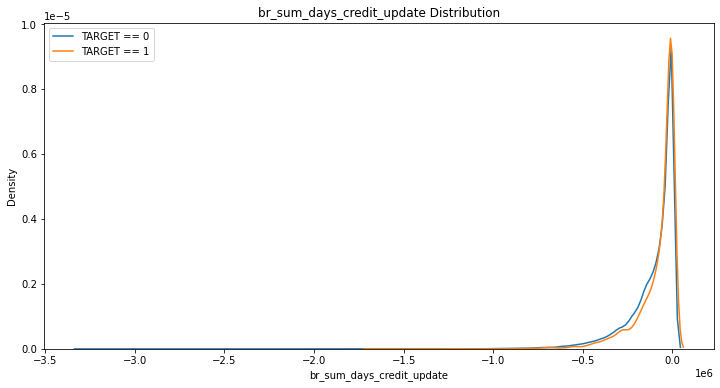

In [1077]:
## 特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

In [1078]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_days_credit_update  
0  52.715068              -21956.000000  
1  49.490411               -1721.000000  
2  54.898630             -185844.000000  
3  38.290411             -424403.000000  
4  35.726027             -161171.964937  

[5 rows x 92 columns]

In [1079]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1080]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1081]:
app_train['br_sum_days_credit_update'].isnull().sum()

0

In [1082]:
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.00000                    0.05107
br_sum_days_credit_update  0.05107                    1.00000

In [1083]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.056503
br_sum_days_credit_update  0.056503                   1.000000

In [1084]:
## 標準化
num_cols = ['br_sum_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_credit_update', 'TARGET']].corr()

br_sum_days_credit_update    TARGET
br_sum_days_credit_update                   1.000000  0.056503
TARGET                                      0.056503  1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0565
Median value for loan that was not repaid = 0.1791
Median value for loan that was repaid =     -0.0118


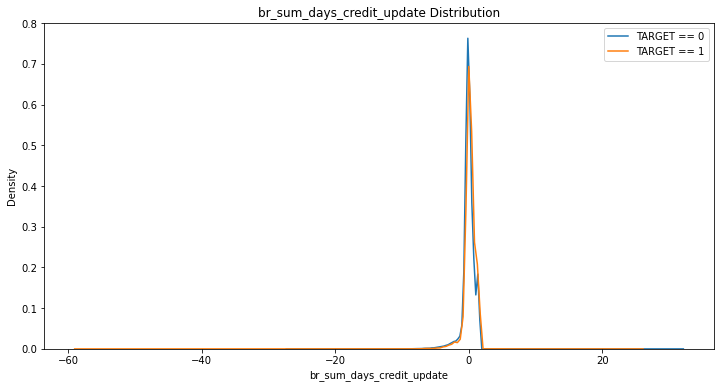

In [1085]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

### br_avg_days_credit_update

In [1086]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.065588
br_avg_days_credit_update  0.065588                   1.000000

In [1087]:
app_train['br_avg_days_credit_update'].isnull().sum()

215579

The correlation between br_avg_days_credit_update and the TARGET is 0.0656
Median value for loan that was not repaid = -380.9533
Median value for loan that was repaid =     -520.2543


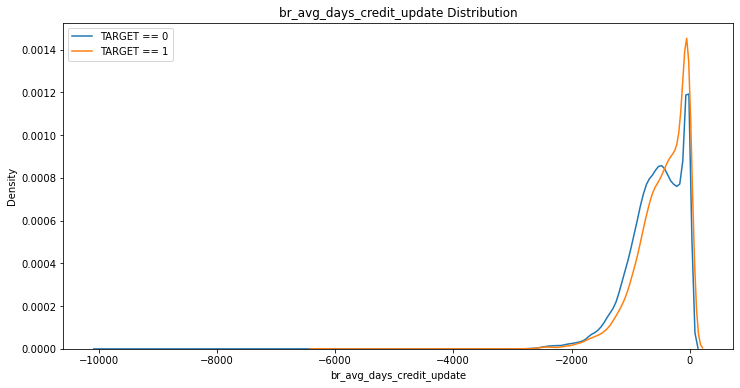

In [1088]:
## 特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

In [1089]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_days_credit_update  
0  52.715068                -127.651200  
1  49.490411                 -81.952400  
2  54.898630                -856.424000  
3  38.290411                -791.796600  
4  35.726027                -636.163647  

[5 rows x 92 columns]

In [1090]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1091]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1092]:
app_train['br_avg_days_credit_update'].isnull().sum()

0

In [1093]:
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.095273
br_avg_days_credit_update  0.095273                   1.000000

In [1094]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.097589
br_avg_days_credit_update  0.097589                   1.000000

In [1095]:
## 標準化
num_cols = ['br_avg_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_credit_update', 'TARGET']].corr()

br_avg_days_credit_update    TARGET
br_avg_days_credit_update                   1.000000  0.097589
TARGET                                      0.097589  1.000000

The correlation between br_avg_days_credit_update and the TARGET is 0.0976
Median value for loan that was not repaid = 0.2894
Median value for loan that was repaid =     -0.0980


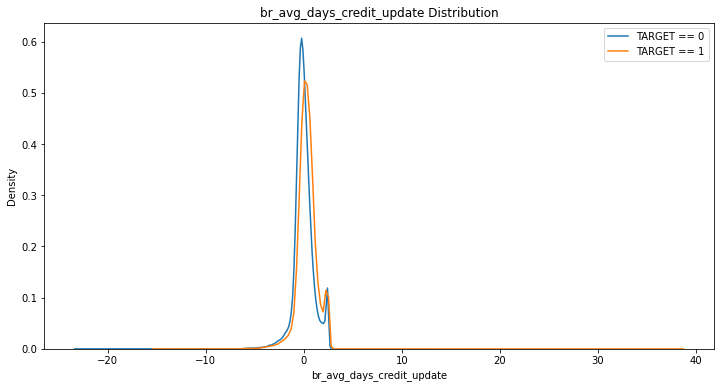

In [1096]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

### br_cnt_days_credit_update

In [1097]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.040412
br_cnt_days_credit_update -0.040412                   1.000000

In [1098]:
app_train['br_cnt_days_credit_update'].isnull().sum()

215579

The correlation between br_cnt_days_credit_update and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


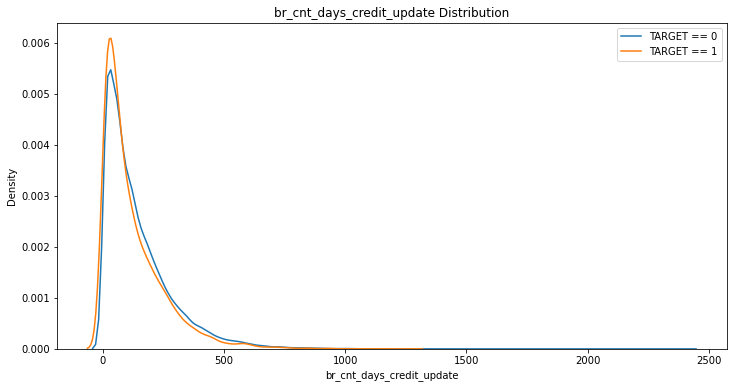

In [1099]:
## 特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

In [1100]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_days_credit_update  
0  52.715068                 172.000000  
1  49.490411                  21.000000  
2  54.898630                 217.000000  
3  38.290411                 536.000000  
4  35.726027                 192.700818  

[5 rows x 92 columns]

In [1101]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1102]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1103]:
app_train['br_cnt_days_credit_update'].isnull().sum()

0

In [1104]:
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.048315
br_cnt_days_credit_update -0.048315                   1.000000

In [1105]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.061147
br_cnt_days_credit_update -0.061147                   1.000000

In [1106]:
## 標準化
num_cols = ['br_cnt_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_credit_update', 'TARGET']].corr()

br_cnt_days_credit_update    TARGET
br_cnt_days_credit_update                   1.000000 -0.061147
TARGET                                     -0.061147  1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


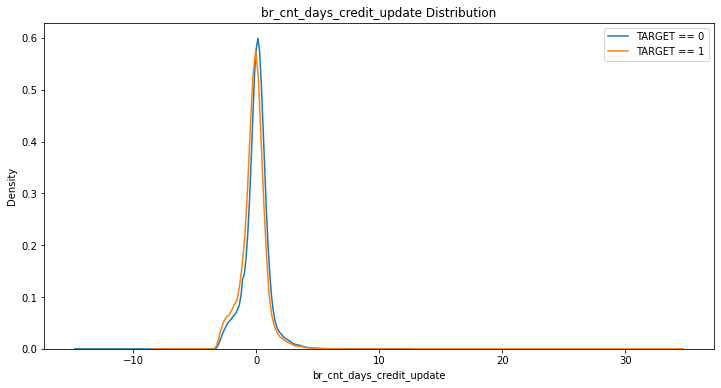

In [1107]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

### br_stddev_days_credit_update

In [1108]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.040617
br_stddev_days_credit_update -0.040617                      1.000000

In [1109]:
app_train['br_stddev_days_credit_update'].isnull().sum()

215579

The correlation between br_stddev_days_credit_update and the TARGET is -0.0406
Median value for loan that was not repaid = 253.5000
Median value for loan that was repaid =     310.0636


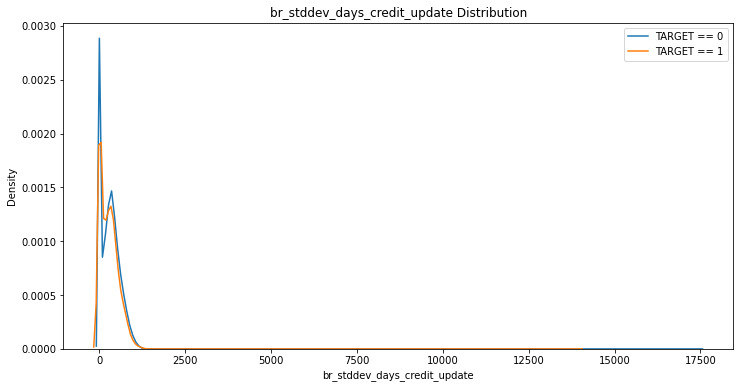

In [1110]:
## 特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

In [1111]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_days_credit_update  
0  52.715068                     57.216799  
1  49.490411                     50.133608  
2  54.898630                    508.087047  
3  38.290411                    459.146578  
4  35.726027                    357.369229  

[5 rows x 92 columns]

In [1112]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1113]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1114]:
app_train['br_stddev_days_credit_update'].isnull().sum()

0

In [1115]:
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.00000                      -0.05313
br_stddev_days_credit_update -0.05313                       1.00000

In [1116]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.058244
br_stddev_days_credit_update -0.058244                      1.000000

In [1117]:
## 標準化
num_cols = ['br_stddev_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_credit_update', 'TARGET']].corr()

br_stddev_days_credit_update    TARGET
br_stddev_days_credit_update                      1.000000 -0.058244
TARGET                                           -0.058244  1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0582
Median value for loan that was not repaid = -0.1072
Median value for loan that was repaid =     0.1055


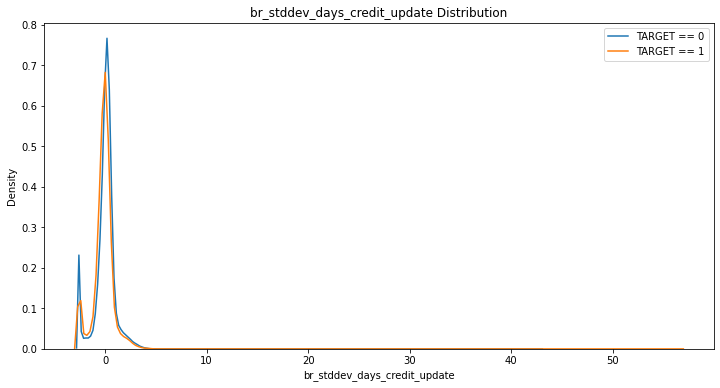

In [1118]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

### br_stddev_pop_days_credit_update

In [1119]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.040617
br_stddev_pop_days_credit_update -0.040617                          1.000000

In [1120]:
app_train['br_stddev_pop_days_credit_update'].isnull().sum()

215579

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0406
Median value for loan that was not repaid = 253.5000
Median value for loan that was repaid =     310.0636


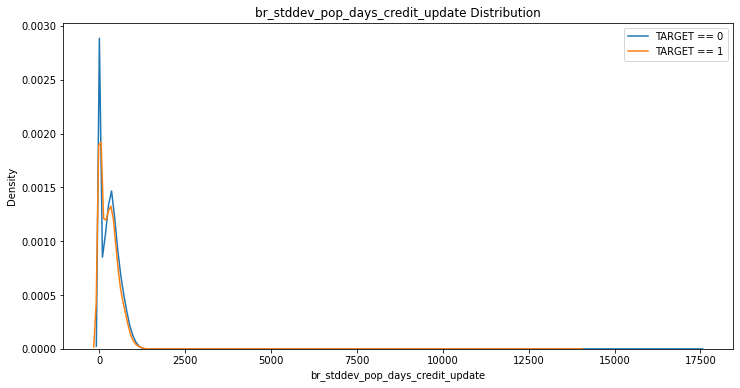

In [1121]:
## 特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

In [1122]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_days_credit_update  
0  52.715068                         57.216799  
1  49.490411                         50.133608  
2  54.898630                        508.087047  
3  38.290411                        459.146578  
4  35.726027                        357.369229  

[5 rows x 92 columns]

In [1123]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1124]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1125]:
app_train['br_stddev_pop_days_credit_update'].isnull().sum()

0

In [1126]:
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.00000                          -0.05313
br_stddev_pop_days_credit_update -0.05313                           1.00000

In [1127]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.058244
br_stddev_pop_days_credit_update -0.058244                          1.000000

In [1128]:
## 標準化
num_cols = ['br_stddev_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_credit_update', 'TARGET']].corr()

br_stddev_pop_days_credit_update    TARGET
br_stddev_pop_days_credit_update                          1.000000 -0.058244
TARGET                                                   -0.058244  1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0582
Median value for loan that was not repaid = -0.1072
Median value for loan that was repaid =     0.1055


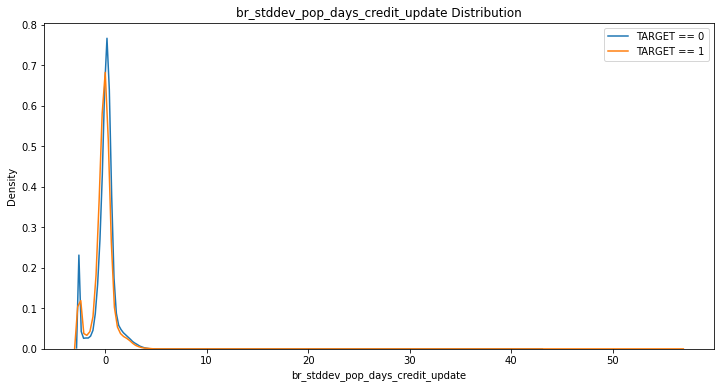

In [1129]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

### br_var_pop_days_credit_update

In [1130]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                      -0.000117
br_var_pop_days_credit_update -0.000117                       1.000000

In [1131]:
app_train['br_var_pop_days_credit_update'].isnull().sum()

215579

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0001
Median value for loan that was not repaid = 64262.2500
Median value for loan that was repaid =     96139.4612


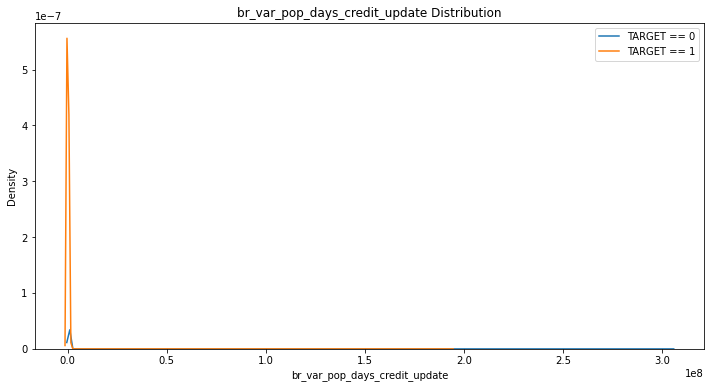

In [1132]:
## 特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

In [1133]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_days_credit_update  
0  52.715068                    3273.762034  
1  49.490411                    2513.378685  
2  54.898630                  258152.446983  
3  38.290411                  210815.579914  
4  35.726027                  195633.618019  

[5 rows x 92 columns]

In [1134]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1135]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1136]:
app_train['br_var_pop_days_credit_update'].isnull().sum()

0

In [1137]:
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.00000                       -0.00391
br_var_pop_days_credit_update -0.00391                        1.00000

In [1138]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                      -0.021735
br_var_pop_days_credit_update -0.021735                       1.000000

In [1139]:
## 標準化
num_cols = ['br_var_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_credit_update', 'TARGET']].corr()

br_var_pop_days_credit_update    TARGET
br_var_pop_days_credit_update                       1.000000 -0.021735
TARGET                                             -0.021735  1.000000

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0217
Median value for loan that was not repaid = -0.0386
Median value for loan that was repaid =     0.0424


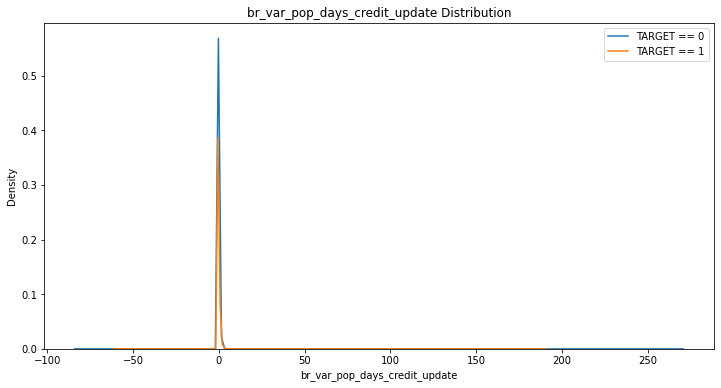

In [1140]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

### br_var_samp_days_credit_update

In [1141]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.000037
br_var_samp_days_credit_update -0.000037                        1.000000

In [1142]:
app_train['br_var_samp_days_credit_update'].isnull().sum()

215579

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0000
Median value for loan that was not repaid = 65324.8336
Median value for loan that was repaid =     97233.0059


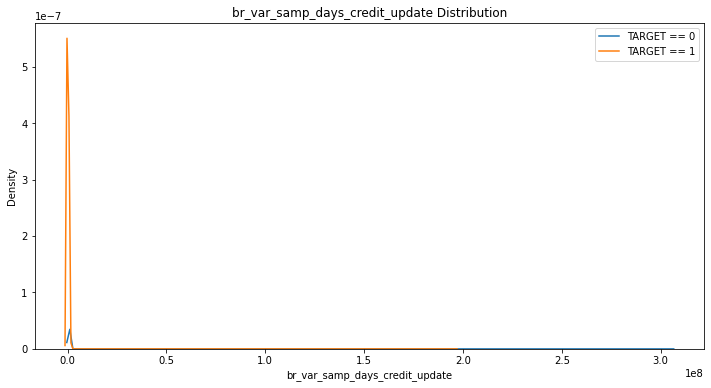

In [1143]:
## 特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

In [1144]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_days_credit_update  
0  52.715068                     3292.906841  
1  49.490411                     2639.047619  
2  54.898630                   259347.597201  
3  38.290411                   211209.627727  
4  35.726027                   196602.509619  

[5 rows x 92 columns]

In [1145]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1146]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1147]:
app_train['br_var_samp_days_credit_update'].isnull().sum()

0

In [1148]:
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.003848
br_var_samp_days_credit_update -0.003848                        1.000000

In [1149]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.021651
br_var_samp_days_credit_update -0.021651                        1.000000

In [1150]:
## 標準化
num_cols = ['br_var_samp_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_credit_update', 'TARGET']].corr()

br_var_samp_days_credit_update    TARGET
br_var_samp_days_credit_update                        1.000000 -0.021651
TARGET                                               -0.021651  1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0217
Median value for loan that was not repaid = -0.0379
Median value for loan that was repaid =     0.0427


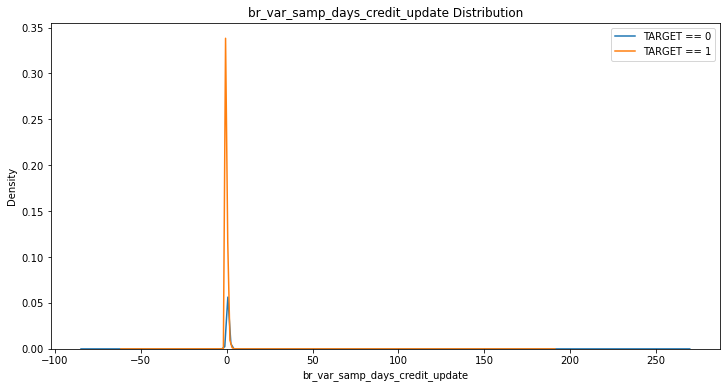

In [1151]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

### br_variance_pop_days_credit_update

In [1152]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update -0.000117   

                                    br_variance_pop_days_credit_update  
TARGET                                                       -0.000117  
br_variance_pop_days_credit_update                            1.000000

In [1153]:
app_train['br_variance_pop_days_credit_update'].isnull().sum()

215579

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0001
Median value for loan that was not repaid = 64262.2500
Median value for loan that was repaid =     96139.4612


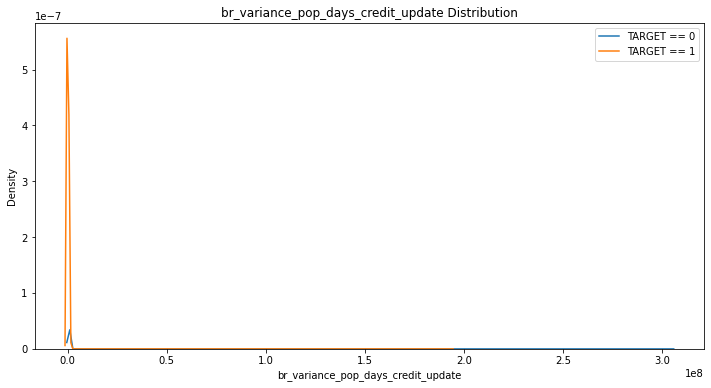

In [1154]:
## 特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

In [1155]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_days_credit_update  
0  52.715068                         3273.762034  
1  49.490411                         2513.378685  
2  54.898630                       258152.446983  
3  38.290411                       210815.579914  
4  35.726027                       195633.618019  

[5 rows x 92 columns]

In [1156]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1157]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1158]:
app_train['br_variance_pop_days_credit_update'].isnull().sum()

0

In [1159]:
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.00000   
br_variance_pop_days_credit_update -0.00391   

                                    br_variance_pop_days_credit_update  
TARGET                                                        -0.00391  
br_variance_pop_days_credit_update                             1.00000

In [1160]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update -0.021735   

                                    br_variance_pop_days_credit_update  
TARGET                                                       -0.021735  
br_variance_pop_days_credit_update                            1.000000

In [1161]:
## 標準化
num_cols = ['br_variance_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_credit_update', 'TARGET']].corr()

br_variance_pop_days_credit_update  \
br_variance_pop_days_credit_update                            1.000000   
TARGET                                                       -0.021735   

                                      TARGET  
br_variance_pop_days_credit_update -0.021735  
TARGET                              1.000000

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0217
Median value for loan that was not repaid = -0.0386
Median value for loan that was repaid =     0.0424


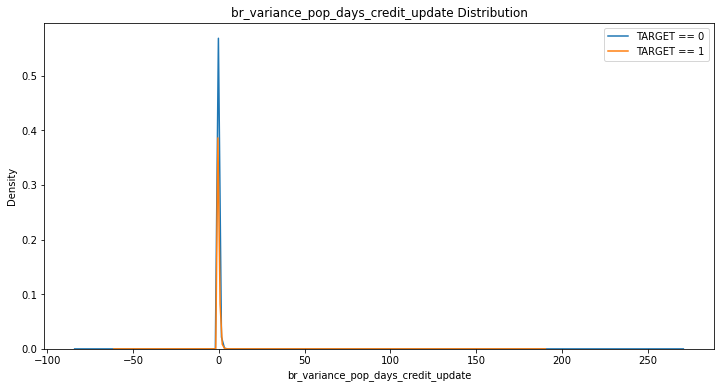

In [1162]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

### br_min_amt_annuity

In [1163]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.00000            -0.00252
br_min_amt_annuity -0.00252             1.00000

In [1164]:
app_train['br_min_amt_annuity'].isnull().sum()

277156

The correlation between br_min_amt_annuity and the TARGET is -0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


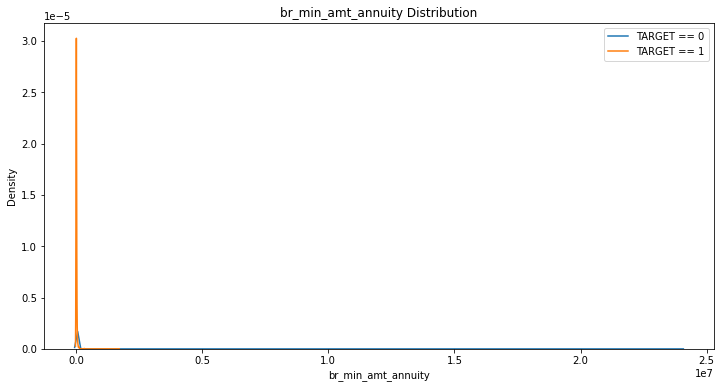

In [1165]:
## 特徴量の分布
kde_target('br_min_amt_annuity', app_train)

In [1166]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1167]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1168]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1169]:
#app_train['br_min_amt_annuity'].isnull().sum()

In [1170]:
#app_train[['TARGET', 'br_min_amt_annuity']].corr()

In [1171]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_annuity']].corr()

In [1172]:
## 標準化
#num_cols = ['br_min_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_annuity', 'TARGET']].corr()

In [1173]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_annuity', app_train)

In [1174]:
columns = ['br_min_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_annuity

In [1175]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.001964
br_max_amt_annuity  0.001964            1.000000

In [1176]:
app_train['br_max_amt_annuity'].isnull().sum()

228061

The correlation between br_max_amt_annuity and the TARGET is 0.0020
Median value for loan that was not repaid = 8502.5700
Median value for loan that was repaid =     8370.0000


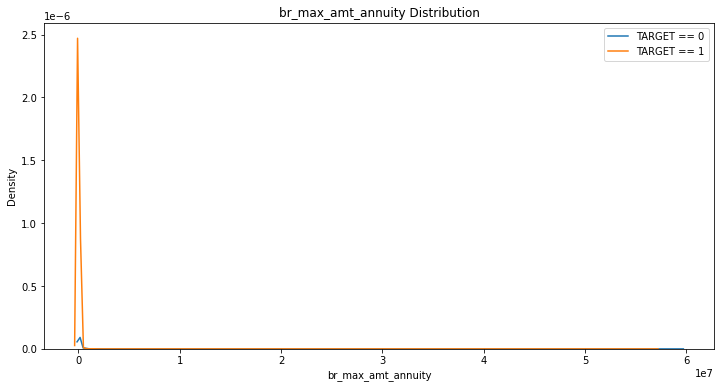

In [1177]:
## 特徴量の分布
kde_target('br_max_amt_annuity', app_train)

In [1178]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1179]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1180]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1181]:
#app_train['br_max_amt_annuity'].isnull().sum()

In [1182]:
#app_train[['TARGET', 'br_max_amt_annuity']].corr()

In [1183]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_annuity']].corr()

In [1184]:
## 標準化
#num_cols = ['br_max_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_annuity', 'TARGET']].corr()

In [1185]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_annuity', app_train)

In [1186]:
columns = ['br_max_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_annuity

In [1187]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000           -0.002962
br_sum_amt_annuity -0.002962            1.000000

In [1188]:
app_train['br_sum_amt_annuity'].isnull().sum()

215579

The correlation between br_sum_amt_annuity and the TARGET is -0.0030
Median value for loan that was not repaid = 166500.0000
Median value for loan that was repaid =     149920.8750


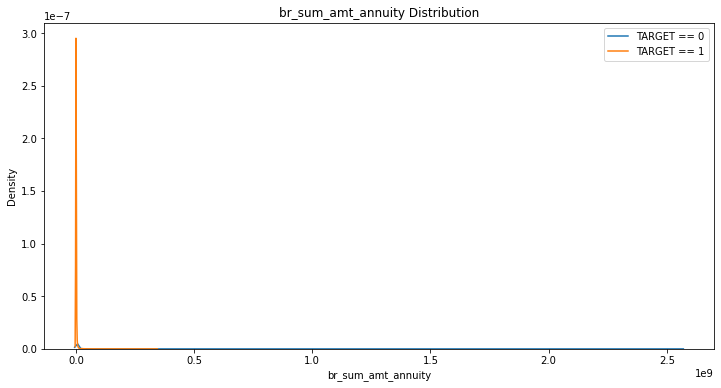

In [1189]:
## 特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

In [1190]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1191]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1192]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1193]:
#app_train['br_sum_amt_annuity'].isnull().sum()

In [1194]:
#app_train[['TARGET', 'br_sum_amt_annuity']].corr()

In [1195]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_annuity']].corr()

In [1196]:
## 標準化
#num_cols = ['br_sum_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_annuity', 'TARGET']].corr()

In [1197]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_annuity', app_train)

In [1198]:
columns = ['br_sum_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_annuity

In [1199]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000           -0.001003
br_avg_amt_annuity -0.001003            1.000000

In [1200]:
app_train['br_avg_amt_annuity'].isnull().sum()

215579

The correlation between br_avg_amt_annuity and the TARGET is -0.0010
Median value for loan that was not repaid = 2799.9047
Median value for loan that was repaid =     1818.5339


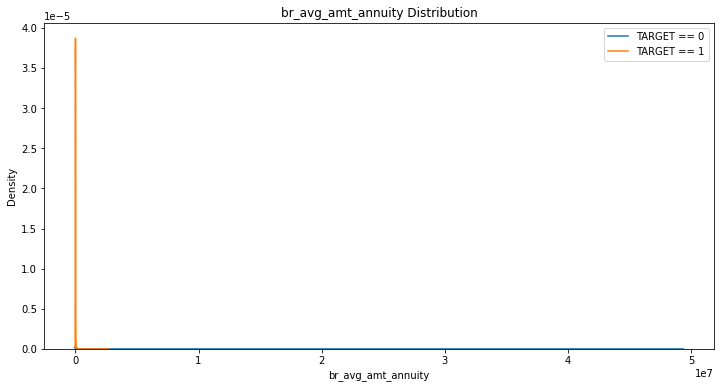

In [1201]:
## 特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

In [1202]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1203]:
# 欠損値を補完した列を再結合
#app_rain[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1204]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1205]:
#app_train['br_avg_amt_annuity'].isnull().sum()

In [1206]:
#app_train[['TARGET', 'br_avg_amt_annuity']].corr()

In [1207]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_annuity']].corr()

In [1208]:
## 標準化
#num_cols = ['br_avg_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_annuity', 'TARGET']].corr()

In [1209]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_annuity', app_train)

In [1210]:
columns = ['br_avg_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_amt_annuity

In [1211]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.040412
br_cnt_amt_annuity -0.040412            1.000000

In [1212]:
app_train['br_cnt_amt_annuity'].isnull().sum()

215579

The correlation between br_cnt_amt_annuity and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


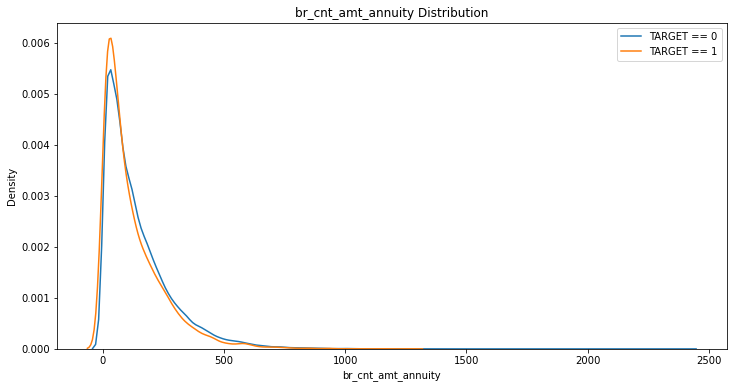

In [1213]:
## 特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

In [1214]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_annuity')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_annuity  
0  52.715068          172.000000  
1  49.490411           21.000000  
2  54.898630          217.000000  
3  38.290411          536.000000  
4  35.726027          192.700818  

[5 rows x 92 columns]

In [1215]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1216]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1217]:
app_train['br_cnt_amt_annuity'].isnull().sum()

0

In [1218]:
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.048315
br_cnt_amt_annuity -0.048315            1.000000

In [1219]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.061147
br_cnt_amt_annuity -0.061147            1.000000

In [1220]:
## 標準化
num_cols = ['br_cnt_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_annuity', 'TARGET']].corr()

br_cnt_amt_annuity    TARGET
br_cnt_amt_annuity            1.000000 -0.061147
TARGET                       -0.061147  1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


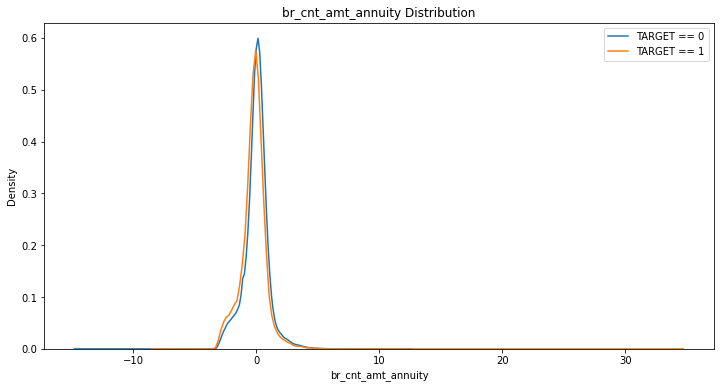

In [1221]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

### br_stddev_amt_annuity

In [1222]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.000000               0.000211
br_stddev_amt_annuity  0.000211               1.000000

In [1223]:
app_train['br_stddev_amt_annuity'].isnull().sum()

215579

The correlation between br_stddev_amt_annuity and the TARGET is 0.0002
Median value for loan that was not repaid = 1972.6737
Median value for loan that was repaid =     1162.4758


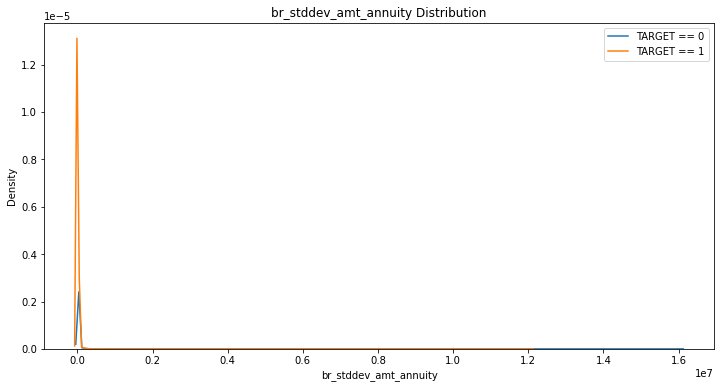

In [1224]:
## 特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

In [1225]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1226]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1227]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1228]:
#app_train['br_stddev_amt_annuity'].isnull().sum()

In [1229]:
#app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

In [1230]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

In [1231]:
## 標準化
#num_cols = ['br_stddev_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_annuity', 'TARGET']].corr()

In [1232]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_annuity', app_train)

In [1233]:
columns = ['br_stddev_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_annuity

In [1234]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.000000                   0.000211
br_stddev_pop_amt_annuity  0.000211                   1.000000

In [1235]:
app_train['br_stddev_pop_amt_annuity'].isnull().sum()

215579

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0002
Median value for loan that was not repaid = 1972.6737
Median value for loan that was repaid =     1162.4758


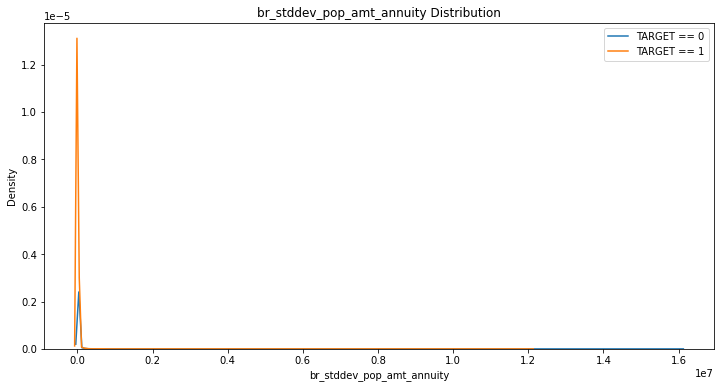

In [1236]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

In [1237]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1238]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1239]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1240]:
#app_train['br_stddev_pop_amt_annuity'].isnull().sum()

In [1241]:
#app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

In [1242]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

In [1243]:
## 標準化
#num_cols = ['br_stddev_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_annuity', 'TARGET']].corr()

In [1244]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_annuity', app_train)

In [1245]:
columns = ['br_stddev_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_annuity

In [1246]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.000318
br_var_pop_amt_annuity  0.000318                1.000000

In [1247]:
app_train['br_var_pop_amt_annuity'].isnull().sum()

215579

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0003
Median value for loan that was not repaid = 3891441.3524
Median value for loan that was repaid =     1351350.0286


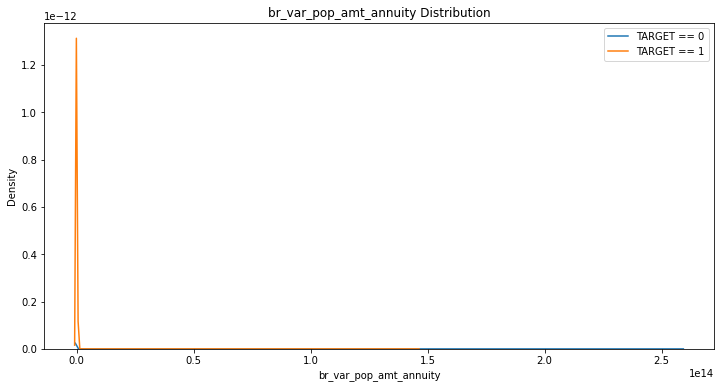

In [1248]:
## 特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

In [1249]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1250]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1251]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1252]:
#app_train['br_var_pop_amt_annuity'].isnull().sum()

In [1253]:
#app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

In [1254]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

In [1255]:
## 標準化
#num_cols = ['br_var_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_annuity', 'TARGET']].corr()

In [1256]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_annuity', app_train)

In [1257]:
columns = ['br_var_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_annuity

In [1258]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.000318
br_var_samp_amt_annuity  0.000318                 1.000000

In [1259]:
app_train['br_var_samp_amt_annuity'].isnull().sum()

215579

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0003
Median value for loan that was not repaid = 3966016.6123
Median value for loan that was repaid =     1371602.5501


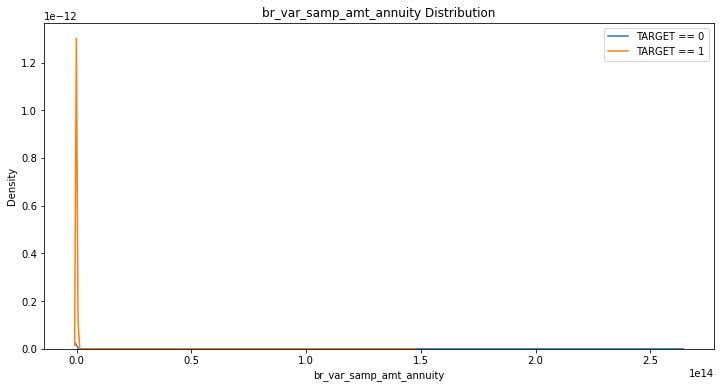

In [1260]:
## 特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

In [1261]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1262]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1263]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1264]:
#app_train['br_var_samp_amt_annuity'].isnull().sum()

In [1265]:
#app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

In [1266]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

In [1267]:
## 標準化
#num_cols = ['br_var_samp_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_annuity', 'TARGET']].corr()

In [1268]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_annuity', app_train)

In [1269]:
columns = ['br_var_samp_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_annuity

In [1270]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.000318
br_variance_pop_amt_annuity  0.000318                     1.000000

In [1271]:
app_train['br_variance_pop_amt_annuity'].isnull().sum()

215579

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0003
Median value for loan that was not repaid = 3891441.3524
Median value for loan that was repaid =     1351350.0286


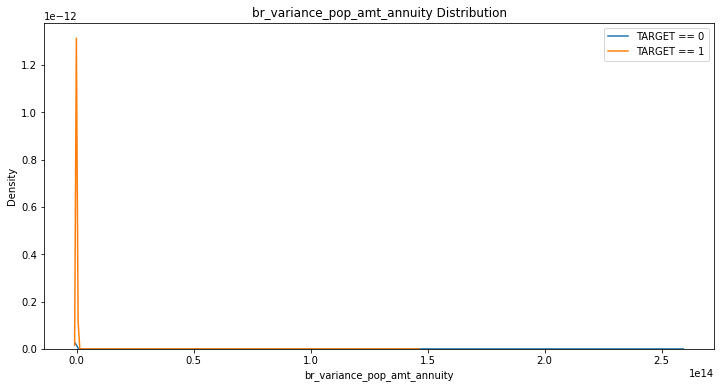

In [1272]:
## 特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [1273]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1274]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1275]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1276]:
#app_train['br_variance_pop_amt_annuity'].isnull().sum()

In [1277]:
#app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

In [1278]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

In [1279]:
## 標準化
#num_cols = ['br_variance_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_annuity', 'TARGET']].corr()

In [1280]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_annuity', app_train)

In [1281]:
columns = ['br_variance_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

## CSVをEXPORT

In [1282]:
app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  br_max_days_credit_update  \
0               0.0  ...                   0.649734   
1               0.0  ...                   0.621003   
2               0.0  ...                   0.661379   
3               0.0  ...                   0.570116   
4               0.0  ...                   0.022556   

   br_sum_days_credit_update  br_avg_days_credit_update  \
0                   1.102972                   1.789634   
1                   1.487686                   2.020291   
2                  -1.059161                  -1.006109   
3                  -3.639005                  -0.787671   
4                  -0.767754                  -0.246569   

   br_cnt_days_credit_update  br_stddev_days_credit_update  \
0                   0.474472                     -1.831834   
1                  -2.070071                     -1.902323   
2                   0.944533                      1.091615   
3                   3.351362                      0.834405   
4                   0.697899                      0.271934   

   br_stddev_pop_days_credit_update  br_var_pop_days_credit_update  \
0                         -1.831834                      -0.798636   
1                         -1.902323                      -0.805873   
2                          1.091615                       0.307240   
3                          0.834405                       0.141319   
4                          0.271934                       0.086369   

   br_var_samp_days_credit_update  br_variance_pop_days_credit_update  \
0                       -0.802866                           -0.798636   
1                       -0.809055                           -0.805873   
2                        0.304942                            0.307240   
3                        0.136762                            0.141319   
4                        0.084060                            0.086369   

   br_cnt_amt_annuity  
0            0.474472  
1           -2.070071  
2            0.944533  
3            3.351362  
4            0.697899  

[5 rows x 153 columns]

In [1283]:
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  br_max_days_credit_update  br_sum_days_credit_update  \
0  ...                   0.643950                   0.396317   
1  ...                   0.364822                  -0.003298   
2  ...                  -0.648144                  -0.145166   
3  ...                  -0.309597                  -0.119459   
4  ...                  -0.345510                  -0.457668   

   br_avg_days_credit_update  br_cnt_days_credit_update  \
0                  -0.231633                  -0.296737   
1                   0.301921                   0.227196   
2                  -1.102623                   0.725518   
3                  -0.341181                   0.135581   
4                  -0.334401                  -0.024498   

   br_stddev_days_credit_update  br_stddev_pop_days_credit_update  \
0                      0.907943                          0.907943   
1                      0.179679                          0.179679   
2                      0.430483                          0.430483   
3                      0.145091                          0.145091   
4                      0.135612                          0.135612   

   br_var_pop_days_credit_update  br_var_samp_days_credit_update  \
0                       0.187322                        0.188485   
1                       0.049736                        0.049772   
2                       0.144801                        0.145271   
3                       0.062957                        0.063276   
4                       0.221142                        0.220988   

   br_variance_pop_days_credit_update  br_cnt_amt_annuity  
0                            0.187322           -0.296737  
1                            0.049736            0.227196  
2                            0.144801            0.725518  
3                            0.062957            0.135581  
4                            0.221142           -0.024498  

[5 rows x 154 columns]

In [1284]:
remove_columns = list(app_test_origin.columns)
remove_columns.remove('SK_ID_CURR')
remove_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_M

In [1285]:
app_train.drop(remove_columns, axis=1, inplace=True)
app_test.drop(remove_columns, axis=1, inplace=True)
app_br_train = app_train.copy()
app_br_test = app_test.copy()
app_br_test.head()

SK_ID_CURR  br_cnt_credit_day_overdue  br_stddev_credit_day_overdue  \
0      100001                   0.474472                     -0.267268   
1      100005                  -2.070071                     -0.267268   
2      100013                   0.944533                     -0.267268   
3      100028                   3.351362                     -0.267268   
4      100038                   0.697899                     -0.031667   

   br_stddev_pop_credit_day_overdue  br_min_days_credit_enddate  \
0                         -0.267268                   -0.574850   
1                         -0.267268                    1.132705   
2                         -0.267268                   -1.173975   
3                         -0.267268                   -1.424791   
4                         -0.031667                   -0.106127   

   br_max_days_credit_enddate  br_sum_days_credit_enddate  \
0                   -0.483817                   -0.541057   
1                   -0.580516                    0.051019   
2                   -1.484021                   -1.717699   
3                    4.285669                    5.509050   
4                    0.217548                    0.138635   

   br_avg_days_credit_enddate  br_cnt_days_credit_enddate  \
0                   -0.721923                    0.572764   
1                    0.000854                   -1.979217   
2                   -1.613635                    1.051374   
3                    1.174957                    3.227836   
4                    0.113396                    0.701838   

   br_stddev_days_credit_enddate  ...  br_max_days_credit_update  \
0                      -0.540696  ...                   0.649734   
1                      -0.613208  ...                   0.621003   
2                      -0.703205  ...                   0.661379   
3                       4.514010  ...                   0.570116   
4                       0.145702  ...                   0.022556   

   br_sum_days_credit_update  br_avg_days_credit_update  \
0                   1.102972                   1.789634   
1                   1.487686                   2.020291   
2                  -1.059161                  -1.006109   
3                  -3.639005                  -0.787671   
4                  -0.767754                  -0.246569   

   br_cnt_days_credit_update  br_stddev_days_credit_update  \
0                   0.474472                     -1.831834   
1                  -2.070071                     -1.902323   
2                   0.944533                      1.091615   
3                   3.351362                      0.834405   
4                   0.697899                      0.271934   

   br_stddev_pop_days_credit_update  br_var_pop_days_credit_update  \
0                         -1.831834                      -0.798636   
1                         -1.902323                      -0.805873   
2                          1.091615                       0.307240   
3                          0.834405                       0.141319   
4                          0.271934                       0.086369   

   br_var_samp_days_credit_update  br_variance_pop_days_credit_update  \
0                       -0.802866                           -0.798636   
1                       -0.809055                           -0.805873   
2                        0.304942                            0.307240   
3                        0.136762                            0.141319   
4                        0.084060                            0.086369   

   br_cnt_amt_annuity  
0            0.474472  
1           -2.070071  
2            0.944533  
3            3.351362  
4            0.697899  

[5 rows x 62 columns]

In [1286]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_train_axis-60.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1287]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_test_axis-60.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1288]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [1289]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [1290]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[16:58:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.66959	eval-auc:0.65205
[1]	train-auc:0.68362	eval-auc:0.66113
[2]	train-auc:0.68893	eval-auc:0.66266
[3]	train-auc:0.69258	eval-auc:0.66553
[4]	train-auc:0.69654	eval-auc:0.66713
[5]	train-auc:0.69949	eval-auc:0.66797
[6]	train-auc:0.70282	eval-auc:0.66878
[7]	train-auc:0.70572	eval-auc:0.66961
[8]	train-auc:0.70752	eval-auc:0.66979
[9]	train-auc:0.70915	eval-auc:0.67022
[10]	train-auc:0.71160	eval-auc:0.67084
[11]	train-auc:0.71407	eval-auc:0.67061
[12]	train-auc:0.71600	eval-auc:0.67054
[13]	train-auc:0.71738	eval-auc:0.67084
[14

[12]	train-auc:0.71517	eval-auc:0.67522
[13]	train-auc:0.71681	eval-auc:0.67531
[14]	train-auc:0.71829	eval-auc:0.67628
[15]	train-auc:0.71990	eval-auc:0.67651
[16]	train-auc:0.72172	eval-auc:0.67648
[17]	train-auc:0.72332	eval-auc:0.67638
[18]	train-auc:0.72467	eval-auc:0.67637
[19]	train-auc:0.72597	eval-auc:0.67687
[20]	train-auc:0.72761	eval-auc:0.67709
[21]	train-auc:0.72925	eval-auc:0.67780
[22]	train-auc:0.73130	eval-auc:0.67784
[23]	train-auc:0.73205	eval-auc:0.67831
[24]	train-auc:0.73341	eval-auc:0.67813
[25]	train-auc:0.73516	eval-auc:0.67829
[26]	train-auc:0.73663	eval-auc:0.67781
[27]	train-auc:0.73824	eval-auc:0.67818
[28]	train-auc:0.73969	eval-auc:0.67825
[29]	train-auc:0.74099	eval-auc:0.67859
[30]	train-auc:0.74313	eval-auc:0.67866
[31]	train-auc:0.74489	eval-auc:0.67860
[32]	train-auc:0.74643	eval-auc:0.67857
[33]	train-auc:0.74785	eval-auc:0.67895
[34]	train-auc:0.74932	eval-auc:0.67953
[35]	train-auc:0.75105	eval-auc:0.67959
[36]	train-auc:0.75274	eval-auc:0.67945


In [1291]:
remove_columns = ['TARGET']
app_br_train.drop(remove_columns, axis=1, inplace=True)
app_br_train.head()

SK_ID_CURR  br_cnt_credit_day_overdue  br_stddev_credit_day_overdue  \
0      100002                  -0.296737                     -0.267268   
1      100003                   0.227196                     -0.022761   
2      100004                   0.725518                      0.255020   
3      100006                   0.135581                      0.146010   
4      100007                  -0.024498                      0.257197   

   br_stddev_pop_credit_day_overdue  br_min_days_credit_enddate  \
0                         -0.267268                   -0.179397   
1                         -0.022761                    0.406904   
2                          0.255020                   -0.026747   
3                          0.146010                    0.046102   
4                          0.257197                   -0.471993   

   br_max_days_credit_enddate  br_sum_days_credit_enddate  \
0                   -0.702158                   -0.263375   
1                    0.249076                    0.297307   
2                   -0.057326                   -0.100922   
3                   -0.032408                   -0.022153   
4                   -0.022709                   -0.090824   

   br_avg_days_credit_enddate  br_cnt_days_credit_enddate  \
0                   -0.717493                   -0.507400   
1                    0.356002                    0.217945   
2                    0.029206                    0.731349   
3                    0.068150                    0.145893   
4                   -0.087052                   -0.005642   

   br_stddev_days_credit_enddate  ...  br_max_days_credit_update  \
0                      -0.553078  ...                   0.643950   
1                       0.243727  ...                   0.364822   
2                      -0.525412  ...                  -0.648144   
3                      -0.032082  ...                  -0.309597   
4                      -0.164210  ...                  -0.345510   

   br_sum_days_credit_update  br_avg_days_credit_update  \
0                   0.396317                  -0.231633   
1                  -0.003298                   0.301921   
2                  -0.145166                  -1.102623   
3                  -0.119459                  -0.341181   
4                  -0.457668                  -0.334401   

   br_cnt_days_credit_update  br_stddev_days_credit_update  \
0                  -0.296737                      0.907943   
1                   0.227196                      0.179679   
2                   0.725518                      0.430483   
3                   0.135581                      0.145091   
4                  -0.024498                      0.135612   

   br_stddev_pop_days_credit_update  br_var_pop_days_credit_update  \
0                          0.907943                       0.187322   
1                          0.179679                       0.049736   
2                          0.430483                       0.144801   
3                          0.145091                       0.062957   
4                          0.135612                       0.221142   

   br_var_samp_days_credit_update  br_variance_pop_days_credit_update  \
0                        0.188485                            0.187322   
1                        0.049772                            0.049736   
2                        0.145271                            0.144801   
3                        0.063276                            0.062957   
4                        0.220988                            0.221142   

   br_cnt_amt_annuity  
0           -0.296737  
1            0.227196  
2            0.725518  
3            0.135581  
4           -0.024498  

[5 rows x 62 columns]

In [1292]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  br_max_days_credit_update  br_sum_days_credit_update  \
0  ...                   0.643950                   0.396317   
1  ...                   0.364822                  -0.003298   
2  ...                  -0.648144                  -0.145166   
3  ...                  -0.309597                  -0.119459   
4  ...                  -0.345510                  -0.457668   

   br_avg_days_credit_update  br_cnt_days_credit_update  \
0                  -0.231633                  -0.296737   
1                   0.301921                   0.227196   
2                  -1.102623                   0.725518   
3                  -0.341181                   0.135581   
4                  -0.334401                  -0.024498   

   br_stddev_days_credit_update  br_stddev_pop_days_credit_update  \
0                      0.907943                          0.907943   
1                      0.179679                          0.179679   
2                      0.430483                          0.430483   
3                      0.145091                          0.145091   
4                      0.135612                          0.135612   

   br_var_pop_days_credit_update  br_var_samp_days_credit_update  \
0                       0.187322                        0.188485   
1                       0.049736                        0.049772   
2                       0.144801                        0.145271   
3                       0.062957                        0.063276   
4                       0.221142                        0.220988   

   br_variance_pop_days_credit_update  br_cnt_amt_annuity  
0                            0.187322           -0.296737  
1                            0.049736            0.227196  
2                            0.144801            0.725518  
3                            0.062957            0.135581  
4                            0.221142           -0.024498  

[5 rows x 154 columns]

In [1293]:
columns = list(app_train.columns)
columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVIN

In [1294]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [1295]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [1296]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[16:58:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.73668	eval-auc:0.71983
[1]	train-auc:0.74638	eval-auc:0.72504
[2]	train-auc:0.75365	eval-auc:0.72886
[3]	train-auc:0.75869	eval-auc:0.73089
[4]	train-auc:0.76192	eval-auc:0.73226
[5]	train-auc:0.76504	eval-auc:0.73299
[6]	train-auc:0.76745	eval-auc:0.73429
[7]	train-auc:0.76935	eval-auc:0.73528
[8]	train-auc:0.77135	eval-auc:0.73614
[9]	train-auc:0.77304	eval-auc:0.73618
[10]	train-auc:0.77579	eval-auc:0.73730
[11]	train-auc:0.77816	eval-auc:0.73847
[12]	train-auc:0.77987	eval-auc:0.73827
[13]	train-auc:0.78201	eval-auc:0.73916
[14

[12]	train-auc:0.78163	eval-auc:0.73854
[13]	train-auc:0.78352	eval-auc:0.73893
[14]	train-auc:0.78491	eval-auc:0.73916
[15]	train-auc:0.78659	eval-auc:0.73952
[16]	train-auc:0.78854	eval-auc:0.74020
[17]	train-auc:0.79028	eval-auc:0.74039
[18]	train-auc:0.79187	eval-auc:0.74095
[19]	train-auc:0.79316	eval-auc:0.74123
[20]	train-auc:0.79445	eval-auc:0.74162
[21]	train-auc:0.79577	eval-auc:0.74214
[22]	train-auc:0.79780	eval-auc:0.74276
[23]	train-auc:0.79949	eval-auc:0.74319
[24]	train-auc:0.80117	eval-auc:0.74344
[25]	train-auc:0.80267	eval-auc:0.74425
[26]	train-auc:0.80470	eval-auc:0.74428
[27]	train-auc:0.80638	eval-auc:0.74477
[28]	train-auc:0.80794	eval-auc:0.74522
[29]	train-auc:0.81008	eval-auc:0.74546
[30]	train-auc:0.81122	eval-auc:0.74569
[31]	train-auc:0.81259	eval-auc:0.74631
[32]	train-auc:0.81357	eval-auc:0.74640
[33]	train-auc:0.81508	eval-auc:0.74672
[34]	train-auc:0.81668	eval-auc:0.74704
[35]	train-auc:0.81854	eval-auc:0.74758
[36]	train-auc:0.82015	eval-auc:0.74775


In [1297]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1298]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1299]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1300]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1301]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1302]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [1303]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.042282       0.069118       0.049412       0.055383       0.083726
1       0.102182       0.118439       0.096883       0.144673       0.102297
2       0.020933       0.019264       0.017786       0.017546       0.029515
3       0.050403       0.034740       0.029703       0.043730       0.030099
4       0.123131       0.122337       0.111039       0.137543       0.143964

In [1304]:
submit_all = app_test[["SK_ID_CURR"]].astype(int).copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.059984
1      100005  0.112895
2      100013  0.021009
3      100028  0.037735
4      100038  0.127603

In [1305]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_br_main_test_axis-60.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.011997
1      100005  0.022579
2      100013  0.004202
3      100028  0.007547
4      100038  0.025521

In [1306]:
submit_all.count()

SK_ID_CURR    48744
TARGET        48744
dtype: int64